In [1]:
%run ./const
%run ./param
import sys
import csv
import numpy as np
import glob
from scipy import integrate, interpolate
import matplotlib
import math
import copy
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 1.5

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import optimize
import cmasher as cmr
import matplotlib.font_manager
from numpy import random
from scipy.stats import lognorm
from scipy.stats import norm
import scipy.optimize as opt

from scipy.sparse import diags
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
# from ipynb.fs.full.utils import Matrix3D
from sklearn.linear_model import LinearRegression
import time

###########################
gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0      = 67.74*km/s/Mpc
Om      = 0.3075
OL      = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
fb      = 0.158
keV     = 1.60218e-9
###########################


###########################
mu          = 0.62
metallicity = 10**-2  #10**-0.5
muH         = 1/0.75
###########################

const = Const()
pm = Param("Inputs", const).paramDict

linestyle_tuple = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [2]:
class FrozenDict(dict):
    def __init__(self, *args, **kwargs):
        self._frozen = False
        dict.__init__(self, *args, **kwargs)
    def freeze(self):
        self._frozen = True
    def __setitem__(self, key, value):
        if (self._frozen):
            raise TypeError("Attempted assignment to a frozen dict")
        else:
            return dict.__setitem__(self, key, value)

In [3]:
class EvolveControl:
    def __init__(self, const, pm):
        self.terminate = False
        self.inject_mode = pm['CLOUD_INJECTION_MODE']
        self.inject_start = pm['CLOUD_INJECTION_START']
        self.inject_end = pm['CLOUD_INJECTION_END']
        self.inject_min_steps = pm['CLOUD_MIN_INJECTION_STEP']
        self.nbs_inject_clouds = 0
        self.r_min = pm['R_MIN']
        r_delta = pm['R_DELTA']
        self.sonic_point = pm['SONIC_POINT']
        self.r_wind = self.inject_start
        self.r_cloud = self.inject_start
        self.cfl_m0 = []
        self.cfl_m1 = []
        self.cfl_v0 = []
        self.cfl_v1 = []
        self.delta_r = 0
            
    def get_wind_r_info(self):
        r_curr = self.r_wind
        r_next = r_curr + self.delta_r
        r_next = np.where(r_next < r_max, r_next, r_max)
        if self.inject_mode == 1:
            r_next = np.where(r_curr < self.inject_end and r_next >= self.inject_end, self.inject_end, r_next)
            r_next = min(r_next, r_curr + self.inject_min_steps)
            self.delta_r = r_next - r_curr
        dr = r_next - r_curr
        self.terminate = np.where(r_next < r_max, False, True)
#            dvol = 4/3 * np.pi * (r_next**3 - r_curr**3)             
        return r_curr, r_next, dr, # dvol

    def get_cloud_r_info(self):
        r_curr = self.r_cloud
        r_next = r_curr + self.delta_r
        r_next = np.where(r_next < r_max, r_next, r_max)
        if self.inject_mode == 1:
            r_next = np.where(r_curr < self.inject_end and r_next >= self.inject_end, self.inject_end, r_next)
            r_next = min(r_next, r_curr + self.inject_min_steps)
            self.delta_r = r_next - r_curr
        dr = r_next - r_curr
        self.terminate = np.where(r_next < r_max, False, True)
#            dvol = 4/3 * np.pi * (r_next**3 - r_curr**3)             
        return r_curr, r_next, dr #dvol        



In [4]:
class Cooling:
    def __init__(self, fname, const):
        file = glob.glob(fname) ## CHANGE FOR WHERE YOU WANT TO KEEP IT
        if len(file) > 0:
            data = np.load(file[0])
            Lambda_tab = data['Lambda_tab']
            redshifts  = data['redshifts']
            Zs         = data['Zs']
            log_Tbins  = data['log_Tbins']
            log_nHbins = data['log_nHbins']    
            self.Lambda     = interpolate.RegularGridInterpolator((log_nHbins,log_Tbins,Zs,redshifts), Lambda_tab, bounds_error=False, fill_value=1e-30)
            self.Lambda_cool = lambda T,Z : 5e-22 * (T/2e5)**np.where(T>2e5, -2/3., 1/2.) * Z
        else:
            print("Cooling curve file not found")
            
    def tcool_P(self, T,P,Z):
        mu = const.mu
        muH = const.muH
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        return 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), Z,0)))

In [5]:
class Transfer:
    
    drag_coeff = pm['DRAG_COEFF']
    M_cloud_min = pm['M_CLOUD_MIN']
    
    def __init__(self, const, pm):
        self.wind_source = {}
        self.cloud_info = {}
        self.cloud_live = {}
        self.cloud_retire = {}
        self.wind = {}
        self.integrateDelta = np.array([])
        return

    def update_wind_source(self, rho_dot, p_dot, e_dot, rhoZ_dot):
        self.wind_source['rho'] = rho_dot
        self.wind_source['p'] = p_dot
        self.wind_source['e'] = e_dot
        self.wind_source['rhoZ'] = rhoZ_dot
        return
     
    def update_cloud(self, Mdot_grow, Mdot_loss, cloud_live, cloud_retire):
        self.cloud_live['M']=cloud_live['M']
        self.cloud_live['v']=cloud_live['v']
        self.cloud_live['n']=cloud_live['n']
        self.cloud_live['Z']=cloud_live['Z']        
        self.cloud_live['Mdot_grow'] = Mdot_grow
        self.cloud_live['Mdot_loss'] = Mdot_loss        
        self.cloud_retire['M'] = cloud_retire['M']
        self.cloud_retire['v'] = cloud_retire['v']
        self.cloud_retire['n'] = cloud_retire['n']
        self.cloud_retire['Z'] = cloud_retire['Z']        
        return
    
    def update_wind(self, v, rho, P, rhoz):
        self.wind['v'] = v
        self.wind['rho'] = rho
        self.wind['P'] = P
        self.wind['rhoZ'] = rhoz
        return
        

    def calc_wind_source(self, Phir, cloud):
        v = self.wind['v']
        rho = self.wind['rho']
        P = self.wind['P']
        rhoz = self.wind['rhoZ']
        Mdot_grow = cloud['Mdot_grow']
        Mdot_loss = cloud['Mdot_loss']
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        n_cloud = cloud['n']
        Z_cloud = cloud['Z']
        rho_cloud = cloud['rho']
        r_cloud = cloud['r']
        p_dot_drag = cloud['pdot_drag']
        
        Z_wind = rhoz / rho
        dpdt_drag    = (n_cloud * p_dot_drag)        
        rho_dot_plus = Mdot_loss * n_cloud
        rho_dot_minus = Mdot_grow * n_cloud
        rho_dot = rho_dot_plus - rho_dot_minus
        p_dot = rho_dot_plus*v_cloud - rho_dot_minus*v - dpdt_drag
        vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho + Phir
        vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud + Phir
        epsilon_dot = rho_dot_plus * vB_cloud_2 - rho_dot_minus * vB_2 - dpdt_drag * v_cloud
        rhoz_dot = Z_cloud * rho_dot_plus - Z_wind * rho_dot_minus 
        if dump_source == 1: print(rho_dot, p_dot, epsilon_dot, rhoz_dot)
        return rho_dot, p_dot, epsilon_dot, rhoz_dot 


    def updateSource(self, r, dr, pm):
        _, Phir, _ = Utils.get_vcir2_Phi_vesc2(r,pm)
        retire = copy.deepcopy(self.cloud_retire)
        retire['rho'], retire['r'], retire['pdot_drag'] = Utils.get_cloud_rho_r_pdotdrag(self.wind, retire, const, pm)
        dt = abs(dr / retire['v'])
        retire['Mdot_loss'] = retire['M']/dt
        retire['Mdot_grow'] = 0
        rho_dot0, p_dot0, e_dot0, rhoZ_dot0 = self.calc_wind_source(Phir, retire)
        
        live = copy.deepcopy(self.cloud_live)
        live['rho'], live['r'], live['pdot_drag'] = Utils.get_cloud_rho_r_pdotdrag(self.wind, live, const, pm)
        rho_dot1, p_dot1, e_dot1, rhoZ_dot1 = self.calc_wind_source(Phir, live)
        
        rho_dot = sum(rho_dot0) + sum(rho_dot1)
        p_dot = sum(p_dot0) + sum(p_dot1)
        e_dot = sum(e_dot0) + sum(e_dot1)
        rhoZ_dot = sum(rhoZ_dot0) + sum(rhoZ_dot1)
#        print(rho_dot, p_dot, e_dot, rhoZ_dot)
        self.update_wind_source(rho_dot, p_dot, e_dot, rhoZ_dot)
         
        return rho_dot, p_dot, e_dot, rhoZ_dot
        
    def updateSourceFD(self, r, dr, pm):
        _, Phir, _ = Utils.get_vcir2_Phi_vesc2(r,pm)
        retire = copy.deepcopy(self.cloud_retire)
        retire['rho'], retire['r'], retire['pdot_drag'] = Utils.get_cloud_rho_r_pdotdrag(self.wind, retire, const, pm)
        dt = abs(dr / retire['v'])
        retire['Mdot_loss'] = retire['M']/dt
        retire['Mdot_grow'] = 0
        rho_dot0, p_dot0, e_dot0, rhoZ_dot0 = self.calc_wind_source(Phir, retire)
        
        live = copy.deepcopy(self.cloud_live)
        live['rho'], live['r'], live['pdot_drag'] = Utils.get_cloud_rho_r_pdotdrag(self.wind, live, const, pm)
        rho_dot1, p_dot1, e_dot1, rhoZ_dot1 = self.calc_wind_source(Phir, live)
        
        dmdv = transfer.integrateDelta
        rho_dot = sum(rho_dot0 * dmdv) + sum(rho_dot1 * dmdv)
        p_dot = sum(p_dot0 * dmdv) + sum(p_dot1 * dmdv)
        e_dot = sum(e_dot0 * dmdv) + sum(e_dot1 * dmdv)
        rhoZ_dot = sum(rhoZ_dot0 * dmdv) + sum(rhoZ_dot1 * dmdv)
        
        self.update_wind_source(rho_dot, p_dot, e_dot, rhoZ_dot)
         
        return rho_dot, p_dot, e_dot, rhoZ_dot
        
        

In [6]:
class Utils:
    
    @staticmethod
    def genGrid(xmin, xmax, nbs, log, unit):
        delta = (xmax - xmin)/nbs
        boundary = [xmin]
        for i in range(nbs):
            boundary.append(xmin+(i+1)*delta)
        boundary = np.array(boundary)
        if (log==True):
            bndry = 10**boundary * unit
        else:
            bndry = boundary * unit
        center = np.array([0.5 * (bndry[i] + bndry[i+1])for i in range(nbs)])
        delta = np.array([bndry[i+1] - bndry[i] for i in range(nbs)])
        return center, bndry, delta

    @staticmethod
    def pseudo_lognormal(bmin, bmax, nbs_bins, mu, sigma, unit, mtotal):
        bin_size = (bmax-bmin)/(nbs_bins+2)
        logbins = np.arange(bmin,bmax,bin_size)
        bins = 10**logbins * unit
        mu = mu + np.log10(unit)
        z=(np.log10(bins[1:-1])-mu)/sigma
        f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        _delta = bins[1:]-bins[:-1]
        delta_b = _delta[:-1]
        delta_f = _delta[1:]
        return f, bins[1:-1], delta_b, delta_f     
    
    @staticmethod    
    def lognormal(bmin, bmax, nbs_bins, mu, sigma, unit):
        center, bndry, delta = Utils.genGrid(bmin, bmax, nbs_bins, True, unit) 
        mu = mu + np.log10(unit)
        z=(np.log10(center)-mu)/sigma
        f = np.log10(np.e) / ( center * sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
#        f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
        return f, center, delta, bndry            

    @staticmethod
    def normal(bmin, bmax, nbs_bins, mu, sigma, unit):
        center, bndry, delta = Utils.genGrid(bmin, bmax, nbs_bins, False, unit)
        z = (center/unit - mu)/(sigma)
        f=1/(sigma * unit * np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2) 
        return f, center, delta, bndry        
    
    @staticmethod
    def gen_uniform_dist(nbsample, mini, maxi, unit):
        return random.uniform(mini, maxi, nbsample)*unit

    @staticmethod
    def gen_lognormal_dist(nbsample, logmean, logstd, unit):
        sample=random.normal(logmean, logstd, nbsample)
        return 10 ** sample * unit

    @staticmethod
    def gen_normal_dist(nbsample, mean, std, unit):
        sample=random.normal(mean, std, nbsample)
        return sample * unit

    @staticmethod
    def gen_powerlaw(nbsample, xmin, xmax, power, unit):
        r = np.random.random(size=nbsample)
        ag, bg = xmin**power, xmax**power
        return (ag + (bg - ag)*r) ** (1./power) * unit    

    @staticmethod
    def gen_normal_weighted(nbsample, mu, sigma, cutoff, unit):
        mu *= unit
        sigma *= unit
        cutoff *= unit
        xmin_nocutoff = mu-4*sigma
        xmin = np.where(xmin_nocutoff < cutoff, cutoff, xmin_nocutoff)
        xmax = mu+4*sigma
        u = (xmax-xmin) * np.random.random(size=nbsample) + xmin
        n = 1/(sigma * unit * np.sqrt(2*np.pi)) * np.exp(-0.5*((u-mu)/sigma)**2)
        return u, n

    @staticmethod
    def gen_powerlaw_weighted(nbsample, xmin, xmax, power, unit):
        logr = (xmax-xmin) * np.random.random(size=nbsample) + xmin
        r = 10**logr * unit
        b = 10**xmax * unit
        a = 10**xmin * unit
        power += 1
        n = power * r**(power-1) / (b**power - a**power) 
        return r, n  

    @staticmethod    
    def dot_cloud_calc(wind, cloud, tcool_P, pm):   
        # cloud transfer rates
        T_cloud = pm['CLOUD_TEMP']
        f_turb0 = pm['F_TURB0']
        TurbulentVelocityChiPower = pm['TURBULENT_VELOCITY_CHI_POWER'] 
        geometric_factor  = pm['GEOMETRIC_FACTOR']
        CoolingAreaChiPower  = pm['COOLING_AREA_CHI_POWER']
        ColdTurbulenceChiPower = pm['COLD_TURBULENCE_CHI_POWER'] 
        Mdot_coefficient = pm['MDOT_COEFFICIENT']
        drag_coeff = pm['DRAG_COEFF']
        vc = pm['V_CIR']
        M_cloud_min = pm['M_CLOUD_MIN']
        retire_mass = pm['RETIREMENT_MASS']

        Pressure = wind['P']
        v_wind = wind['v']
        rho_wind = wind['rho']
        rhoz_wind = wind['rhoZ']
        
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        Z_cloud = cloud['Z']
        Z_wind = rhoz_wind / rho_wind
        rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) # + [0]*M_cloud # cloud in pressure equilibrium
        chi          = rho_cloud / rho_wind
        r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
        v_rel        = (v_wind-v_cloud)
        v_turb0       = f_turb0 * v_rel * chi**TurbulentVelocityChiPower
        v_turb       = np.where(v_turb0 <=0, 0.001, v_turb0)
        T_wind       = Pressure/kb * (mu*mp/rho_wind)
        T_mix        = (T_wind*T_cloud)**0.5
        Z_mix        = (Z_wind*Z_cloud)**0.5
        t_cool_layer = tcool_P(T_mix, Pressure/kb, Z_mix/const.ZSun)[()]
        t_cool_layer = np.where(t_cool_layer<0, 1e10*Myr, t_cool_layer)
        ksi          = r_cloud / (v_turb * t_cool_layer)
        AreaBoost    = geometric_factor * chi**CoolingAreaChiPower
        v_turb_cold  = v_turb * chi**ColdTurbulenceChiPower
        Mdot_grow    = Mdot_coefficient * 3.0 * M_cloud * v_turb * AreaBoost / (r_cloud * chi) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
        Mdot_loss    = Mdot_coefficient * 3.0 * M_cloud * v_turb_cold / r_cloud 
        Mdot_cloud   = np.where(M_cloud > M_cloud_min, Mdot_grow - Mdot_loss, 0) 
        if dump_Mdot == 1: print(Mdot_grow, Mdot_loss)
        info = {}
        info['rho_cloud'] = rho_cloud
        info['r_cloud'] = r_cloud
        info['v_rel'] = v_rel
        info['v_turb'] = v_turb
        info['t_cool_layer'] = t_cool_layer
        info['ksi'] = ksi
        return Mdot_grow, Mdot_loss, rho_cloud, r_cloud, info   

    
    def dot_cloud_calc1(wind, cloud, tcool_P, pm):        
        T_cloud = pm['CLOUD_TEMP']
        f_turb0 = pm['F_TURB0']
        Mdot_chi_power = pm['MDOT_CHI_POWER']

        
        P = wind['P']
        v = wind['v']
        rho = wind['rho']
        
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        
        Lambda_cool = lambda T : 5e-22 * (T/2e5)**np.where(T>2e5, -2/3., 1/2.)        
        # cloud_radius(M_cloud,v_cloud):
        rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
        chi         = rho_cloud / rho

        r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
        # layer_turbulent_velocity(M_cloud,v_cloud):
        
        v_turb0      = f_turb0*(v-v_cloud)
        v_turb = np.where(v_turb0 <=0, 0.001, v_turb0)
                
        T_wind  = P/kb * (mu*mp/rho)
        T_mix   = np.sqrt(T_wind*T_cloud)

        # layer_cooling_time
        T = T_mix
        T = np.where(T>10**8.98, 10**8.98, T)
        T = np.where(T<10**2, 10**2, T)
        nH_actual = P/kb/T*(mu/muH)
        nH = np.where(nH_actual>1, 1, nH_actual)
        nH = np.where(nH<10**-8, 10**-8, nH)
        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * Lambda_cool(T_mix))        

#        t_cool_layer = 1.5 * (muH/mu)**2 * kb * T / ( nH_actual * self.Lambda((np.log10(nH),np.log10(T), metallicity,0)))        
#        t_cool_layer = self.cool.tcool_P(T_mix, P/kb, self.metallicity, self.mu, self.muH)    
#        t_cool_layer = self.t_cool_layer    

        # cloud_ksi(M_cloud,v_cloud):        
        ksi     = r_cloud / (v_turb * t_cool_layer)

        # Mdot_cloud_grow(M_cloud,v_cloud):
        Mdot_grow   =  3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
        Mdot_loss   = -3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) 
        force_from_transfer = (v-v_cloud)*Mdot_grow

        Mdot = (Mdot_grow + Mdot_loss)
        vdot = (force_from_transfer/M_cloud)
        return Mdot_grow, Mdot_loss, rho_cloud, r_cloud  
    
    
    
    
    @staticmethod
    def get_cloud_rho_r_pdotdrag(wind, cloud, const, pm):
        T_cloud = pm['CLOUD_TEMP']
        drag_coeff = pm['DRAG_COEFF']
        M_cloud_min = pm['M_CLOUD_MIN']

        Pressure = wind['P']
        v_wind = wind['v']
        rho_wind = wind['rho']
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) # + [0]*M_cloud # cloud in pressure equilibrium
        r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
        v_rel = v_wind - v_cloud
        pdot_drag   = 0.5 * drag_coeff * rho_wind * np.pi * v_rel**2 * r_cloud**2 * np.where(M_cloud>M_cloud_min, 1, 0)
        return rho_cloud, r_cloud, pdot_drag
    
    @staticmethod
    def get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind, cloud, pm):
        rho_cloud, r_cloud, pdot_drag = Utils.get_cloud_rho_r_pdotdrag(wind, cloud, const, pm)
        M_cloud_min = pm['M_CLOUD_MIN']
        v_wind = wind['v']
        rho_wind = wind['rho']
        rhoZ_wind = wind['rhoZ']
        M_cloud = cloud['M']
        v_cloud = cloud['v']
        Z_cloud = cloud['Z']
        (vc_sqr, _, _) = Utils.get_vcir2_Phi_vesc2(r, pm)
        Mdot = (Mdot_grow - Mdot_loss)
        v_rel = v_wind - v_cloud
        vdot = (pdot_drag + v_rel*Mdot_grow - M_cloud * vc_sqr/r) / M_cloud * np.where(M_cloud>M_cloud_min, 1, 0)
        Z_wind = rhoZ_wind / rho_wind
        Zdot = (Z_wind-Z_cloud) * Mdot_grow / M_cloud
        return Mdot, vdot, Zdot, pdot_drag
    
    
    

        
    @staticmethod
    def retireCloud(clouds, pm):
        retire_mass = pm['RETIREMENT_MASS']
        id_clouds = clouds['id']
        M_clouds = clouds['M']
        v_clouds = clouds['v']
        n_clouds = clouds['n']
        z_clouds = clouds['Z']
        M_clouds = np.where(M_clouds <=retire_mass, retire_mass, M_clouds)  #assume the mass of retired cloud to retire mass 
        cloud_stack = np.column_stack((id_clouds, M_clouds, v_clouds, n_clouds, z_clouds))
        cloud_live = np.array([list(item) for item in cloud_stack if item[1] > retire_mass])
        cloud_retire = np.array([list(item) for item in cloud_stack if item[1] <= retire_mass])
        if cloud_retire.size == 0: cloud_retire = np.array([[-1,0,1e-100,0,0]])
        return cloud_live, cloud_retire

    
    @staticmethod        
    def read_cloud(cloud):
        return cloud['M'], cloud['v'], cloud['n'], cloud['Z']
    @staticmethod            
    def read_wind(wind):
        return wind['v'], wind['rho'], wind['P'], wind['rhoZ']

    @staticmethod        
    def write_cloud(M, v, n, Z):
        cloud={}
        cloud['M'] = M
        cloud['v'] = v
        cloud['n'] = n
        cloud['Z'] = Z
        return cloud
    @staticmethod            
    def write_wind(v, rho, P, rhoZ):
        wind={}
        wind['v'] = v
        wind['rho'] = rho
        wind['P'] = P
        wind['rhoZ'] = rhoZ
        return wind
    
    
    
    @staticmethod        
    def getdr_MC(r_curr, CLF_MC, CLF_VC, cloud, Mdot_grow, Mdot_loss, vdot, const):
        r = r_curr/const.pc
        index = max([i for i, item in enumerate(beta) if r > item[0]])
        beta_m = CLF_MC * beta[index][1]
        beta_v = CLF_VC * beta[index][1]
        M_clouds, v_clouds, _, _ = Utils.read_cloud(cloud)
        Mdot = Mdot_grow - Mdot_loss
        dr_M = beta_m * min(abs(M_clouds * v_clouds / Mdot))
        dr_v = beta_v * min(abs(v_clouds * v_clouds / vdot))
        dr = min(dr_M,dr_v)
        return dr

    @staticmethod    
    def binnings_MC(i, res, mp):
        clouds = res.clouds_info_MC[i]
        Mcells = pm['M_CELLS']
        vcells = pm['V_CELLS']    
        Mmin = pm['M_MIN']
        Mmax = pm['M_MAX']
        vmin = pm['V_MIN']
        vmax = pm['V_MAX']
        M_bins, mbndry, dm = Utils.genGrid(Mmin, Mmax, Mcells, True, const.Msun)
        v_bins, vbndry, dv = Utils.genGrid(vmin, vmax, vcells, False, const.km)
        M_cloud = np.tile(M_bins, vcells)
        v_cloud = np.repeat(v_bins, Mcells)    

        nbs_vbin= len(mbndry[:-1])
        nbs_Mbin= len(vbndry[:-1])

        #M_cloud = np.tile(M_bins, nbs_vbin)
        #v_cloud = np.repeat(v_bins, nbs_Mbin)


        f=np.reshape(np.zeros(nbs_vbin * nbs_Mbin),(nbs_vbin,nbs_Mbin))
        v_min = min(vbndry[:-1])
        v_max = max(vbndry[:-1])
        M_min = min(mbndry[:-1])
        M_max = max(mbndry[:-1])


        for item in np.r_['1,2,0', clouds['M'], clouds['v'], clouds['n']]:
            if (item[1]>=vbndry[0]) and (item[1]<=vbndry[-1]) and (item[0]>=mbndry[0]) and (item[0]<=mbndry[-1]):
                v_idx = np.max(np.where(vbndry[:-1] <= item[1]))
                M_idx = np.max(np.where(mbndry[:-1] <= item[0]))
                f[v_idx][M_idx]+=item[2]
        return f, M_bins, v_bins    
    
    
    
    @staticmethod
    def array2ntuple(array):
        return list(zip(*array))

    @staticmethod
    def ntuple2array(ntuple):
        return [np.array(item) for item in list(zip(*ntuple))]    
    
    
    @staticmethod
    def get_vcir2_Phi_vesc2(r, pm):
        v_circ0 = pm['V_CIR']
        r0 = pm['SONIC_POINT']
        vc_sqr = v_circ0**2 * np.where(r<r0, 0, 1.0)        
        Phir = -vc_sqr * np.where(r<r0, 0.5 * (r/r0)**2, np.log(r/r0)) 
        vesc_sqr = -2 * Phir
        return vc_sqr, Phir, vesc_sqr

    @staticmethod    
    def plot_wind(data, axes, const):
        matplotlib.rcParams['xtick.direction'] = 'in'
        matplotlib.rcParams['ytick.direction'] = 'in'
        matplotlib.rcParams['xtick.top'] = True
        matplotlib.rcParams['ytick.right'] = True
        matplotlib.rcParams['xtick.minor.visible'] = True
        matplotlib.rcParams['ytick.minor.visible'] = True
        matplotlib.rcParams['lines.dash_capstyle'] = "round"
        matplotlib.rcParams['lines.solid_capstyle'] = "round"
        matplotlib.rcParams['legend.handletextpad'] = 0.4
        matplotlib.rcParams['axes.linewidth'] = 0.6
        matplotlib.rcParams['ytick.major.width'] = 0.6
        matplotlib.rcParams['xtick.major.width'] = 0.6
        matplotlib.rcParams['ytick.minor.width'] = 0.45
        matplotlib.rcParams['xtick.minor.width'] = 0.45
        matplotlib.rcParams['ytick.major.size'] = 2.75
        matplotlib.rcParams['xtick.major.size'] = 2.75
        matplotlib.rcParams['ytick.minor.size'] = 1.75
        matplotlib.rcParams['xtick.minor.size'] = 1.75
        matplotlib.rcParams['legend.handlelength'] = 2
        matplotlib.rcParams["figure.dpi"] = 200


        def v_plot(res, ax):
            if ax is None:
                ax = plt.gca()
            _r = [item[0] for item in res.pre_wind_info]
            r_ = [item[0] for item in res.post_wind_info]
            r = np.r_[_r,r_]/const.kpc
            _v = [item[1] for item in res.pre_wind_info]
            v_ = [item[1] for item in res.post_wind_info]
            v = np.r_[_v,v_]
            ax.loglog(r,v/const.km)
            ax.set_xlabel(r'$r\; [{\rm kpc}]$')
            ax.set_ylabel(r'$v \; [{\rm km/s}]$')
            ax.set_title('Velocity')
            return ax

        def rho_plot(res, ax):
            if ax is None:
                ax = plt.gca()
            _r = [item[0] for item in res.pre_wind_info]
            r_ = [item[0] for item in res.post_wind_info]
            r = np.r_[_r,r_]/const.kpc
            _rho = [item[2] for item in res.pre_wind_info]
            rho_ = [item[2] for item in res.post_wind_info]
            rho = np.r_[_rho,rho_]
            ax.loglog(r,rho/(const.mu*const.mp))
            ax.set_xlabel(r'$r\; [{\rm kpc}]$')
            ax.set_ylabel(r'$n \; [{\rm cm}^{-3}]$')
            ax.set_title('Density')
            return ax

        def P_plot(res, ax):
            if ax is None:
                ax = plt.gca()
            _r = [item[0] for item in res.pre_wind_info]
            r_ = [item[0] for item in res.post_wind_info]
            r = np.r_[_r,r_]/const.kpc
            _P = [item[3] for item in res.pre_wind_info]
            P_ = [item[3] for item in res.post_wind_info]
            P = np.r_[_P,P_]
            ax.loglog(r,P/const.kb, label='123')
            ax.set_xlabel(r'$r\; [{\rm kpc}]$')
            ax.set_ylabel(r'$P \; [{\rm K cm}^{-3}]$')
            ax.set_title('Pressure')
            return ax

        def rhoZ_plot(res, ax):
            if ax is None:
                ax = plt.gca()
            _r = [item[0] for item in res.pre_wind_info]
            r_ = [item[0] for item in res.post_wind_info]
            r = np.r_[_r,r_]/const.kpc
            _rhoZ = [item[4] for item in res.pre_wind_info]
            rhoZ_ = [item[4] for item in res.post_wind_info]
            rhoZ = np.r_[_rhoZ,rhoZ_]
            _rho = [item[2] for item in res.pre_wind_info]
            rho_ = [item[2] for item in res.post_wind_info]
            rho = np.r_[_rho,rho_]
            ax.loglog(r,rhoZ / rho / const.ZSun)
            ax.set_xlabel(r'$r\; [{\rm kpc}]$')
            ax.set_ylabel(r'$Z \; [Z_\odot]$')
            ax.set_title('Metallicity')
            return ax

        for item in data:
            ax1 = v_plot(item, axes[0])
            ax2 = rho_plot(item, axes[1])
            ax3 = P_plot(item, axes[2])
            ax4 = rhoZ_plot(item, axes[3])
        return ax1, ax2, ax3, ax4

    

In [7]:
class Wind:      
    
    rstart = pm['CLOUD_INJECTION_START']
    state = {}
    
    def __init__(self, control, const, pm, res, transfer):
#        control.wind_i = 0
        r0 = control.sonic_point   # sonic point
        r_min = control.r_min
        r_start = control.inject_start
        self.gamma = 5/3     # adiabatic index
        epsilon = 1e-5   
        Mach0 = 1       
        Mach = Mach0 * (1+epsilon)     
        self.v_cir=pm['V_CIR']
        self.metallicity = pm['WIND_METALLICITY']
        beta = pm['BETA']      # mass loading 
        alpha = pm['ALPHA']     # energy loading
        SFR = pm['SFR']       # star formation rate
        Mdot = pm['MDOT']        # mass injection rate
        Edot = pm['EDOT']    # energy injection rate
        
        if (const.reconcile == 1):
            v0 = (Mdot / Edot * (1/2 + 1/((gamma - 1) * Mach)))**(-1/2)  # velocity at sonic point        
        else:
            v0 = (Mdot / Edot * (1/2 + 1/((gamma - 1) * Mach**2)))**(-1/2)  # velocity at sonic point        

        rho0 = Mdot / (4 * np.pi * r0**2 * v0)   # density at sonic point        

        if (const.reconcile == 1):
            P0 = rho0*v0**2 / Mach**2 / gamma
        else:
            P0 = rho0 * (gamma - 1)/gamma * (Edot/Mdot - v0**2/2)   # pressure at sonic point
        
        rhoz0 = rho0 * self.metallicity

        Vol = 4/3 * np.pi * r0**3         
        self.Mdot_per_Vol = Mdot / Vol    
        self.Edot_per_Vol = Edot / Vol

        
        
        def supersonic(r,z):
            return z[0]/np.sqrt(gamma*z[2]/z[1]) - 1.001

        supersonic.terminal = True
        supersonic.direction = -1        
        
        
                
        # transverse the wind to starting position
        if r_start > r0:

            # subsonic
            transfer.update_wind_source(0,0,0,0)
            dv_dr, drho_dr, dP_dr, drhoz_dr = self.evolve(r0, (v0,rho0,P0, rhoz0))
    
            dlogvdlogr = dv_dr * r0/v0
            dlogrhodlogr = drho_dr * r0/rho0
            dlogPdlogr = dP_dr * r0/P0
            dlogrhozdlogr = drhoz_dr * r0/rhoz0

            dlogr0 = 1e-8

            v0_sub = 10**(np.log10(v0) - dlogvdlogr * dlogr0)
            rho0_sub = 10**(np.log10(rho0) - dlogrhodlogr * dlogr0)
            P0_sub = 10**(np.log10(P0) - dlogPdlogr * dlogr0)
            rhoz0_sub = 10**(np.log10(rhoz0) - dlogrhozdlogr * dlogr0)
                        
            # subsonic
            transfer.update_wind_source(self.Mdot_per_Vol, 0, self.Edot_per_Vol, self.metallicity * self.Mdot_per_Vol)
            sol_sub = solve_ivp(self.evolve, [10**(np.log10(r0)-dlogr0), r_min], [v0_sub,rho0_sub, P0_sub, rhoz0_sub],
                events=supersonic, dense_output=True, rtol=1e-12, atol=[1e-3, 1e-7*mp, 1e-2*kb,1e-7])                        

            
            # supersonic
            transfer.update_wind_source(0,0,0,0) 
            if (const.reconcile == 1):
                v0_sup = 10**(np.log10(v0) + dlogvdlogr * dlogr0)
                rho0_sup = 10**(np.log10(rho0) + dlogrhodlogr * dlogr0)
                P0_sup = 10**(np.log10(P0) + dlogPdlogr * dlogr0)
                rhoz0_sup = 10**(np.log10(rhoz0) + dlogrhozdlogr * dlogr0)               
                sol_sup = solve_ivp(self.evolve, [10**(np.log10(r0)+dlogr0), r_start], [v0_sup,rho0_sup, P0_sup, rhoz0_sup],
                    events=supersonic, dense_output=True, rtol=1e-12, atol=[1e-3, 1e-7*mp, 1e-2*kb,1e-7])                        
            else:                
                sol_sup = solve_ivp(self.evolve, [r0, r_start], 
                                [v0,rho0,P0,rhoz0], dense_output=True, 
                                rtol=1e-12, atol=[1, 1e-7*mp, 1e-2*kb, 1])  
        
        r_wind = sol_sup.t[-1]
        v_wind = sol_sup.y[0][-1]
        rho_wind = sol_sup.y[1][-1]
        P_wind = sol_sup.y[2][-1]
        rhoZ_wind = sol_sup.y[3][-1]

        self.update_state(sol_sup.y[0][-1], sol_sup.y[1][-1], sol_sup.y[2][-1], sol_sup.y[3][-1])
        
               
        res.add_pre_wind_info((np.append(sol_sub.t[::-1], sol_sup.t[:-1]), 
                              np.append(sol_sub.y[0][::-1],sol_sup.y[0][:-1]), 
                              np.append(sol_sub.y[1][::-1], sol_sup.y[1][:-1]), 
                              np.append(sol_sub.y[2][::-1], sol_sup.y[2][:-1]),
                              np.append(sol_sub.y[3][::-1], sol_sup.y[3][:-1])))
        res.add_post_wind_info((sol_sup.t[-1], sol_sup.y[0][-1], sol_sup.y[1][-1], 
                               sol_sup.y[2][-1],sol_sup.y[3][-1]))
        res.last_wind_r_save = sol_sup.t[-1]
        if dump_wind == 1: print('WIND', int(r_wind/pc), v_wind, rho_wind, P_wind, rhoZ_wind)

        return
    

    def update_state(self, v, rho, P, rhoz):
        if P < 0: sys.exit('Negative Pressure')
        if rho < 0: sys.exit('Negative Mass Density')
        self.state['v']=v
        self.state['rho']= rho
        self.state['P'] = P
        self.state['rhoZ'] = rhoz
        transfer.update_wind(v, rho, P, rhoz)
        return

        
    def evolve(self, r, states):
        v, rho, P, rhoz = states
        r0 = pm['SONIC_POINT']
        r1 = pm['SONIC_POINT']
        dr = control.delta_r
        P_wind = P
        rho_wind = rho
        v_wind = v
        rhoZ_wind = rhoz        
        Z_wind = rhoZ_wind / rho_wind   
        
       

        gamma = self.gamma
        r1 = self.rstart          
        Mdot_per_Vol = self.Mdot_per_Vol
        Edot_per_Vol = self.Edot_per_Vol
            
            
        cs_sqr = gamma * P_wind / rho_wind
        mach_sqr = v_wind**2 / cs_sqr

        vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
#        print(vesc_sqr)

        rho_dot = transfer.wind_source['rho']
        p_dot = transfer.wind_source['p']
        e_dot = transfer.wind_source['e']
        rhoz_dot = transfer.wind_source['rhoZ']

            
        
        dv_dr  = 2/mach_sqr
        dv_dr += -vc_sqr/v_wind**2
        dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
        dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


        drho_dr  = -2
        drho_dr += vc_sqr/v_wind**2
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
        drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

        dP_dr  = -2
        dP_dr += vc_sqr/v_wind**2
        dP_dr += rho_dot/(rho_wind*v_wind/r)
        dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
        dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
        dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
        dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))

        drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind 

        return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr]
        
        
    

    def step(self, transfer):
        v_wind = self.state['v']
        rho_wind = self.state['rho']
        P_wind = self.state['P']
        rhoz_wind = self.state['rhoZ']
        r_sonic = control.sonic_point
        
        r0, r1, dr = control.get_wind_r_info()
        
        transfer.updateSource(r0, dr, pm)
                
#        res.add_wind_dot_info(r0, transfer)
        
        dwind_dr = self.evolve(r0, (v_wind, rho_wind, P_wind, rhoz_wind))
#        dr = r1 - r0
#        r_wind_next = r1
#        v_wind_next = v_wind + dwind_dr[0]*dr  
#        rho_wind_next = rho_wind + dwind_dr[1]*dr  
#        P_wind_next = P_wind + dwind_dr[2]*dr  
#        rhoZ_wind_next = rhoz_wind + dwind_dr[3]*dr  
 

        
#        self.update_state(v_wind_next, rho_wind_next, P_wind_next, rhoZ_wind_next)
#        if (r_wind_next - res.last_wind_r_save) >= res.save_interval or (r_wind_next == control.inject_end) or (r_wind_next == r_max):
#            res.add_post_wind_info((r_wind_next, v_wind_next, rho_wind_next, P_wind_next, rhoZ_wind_next))
#            res.last_wind_r_save = r_wind_next
#        control.r_wind = r1
        return dwind_dr * dr


In [8]:
class Cloud:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    gamma = pm['GAMMA']  
    T_cloud = pm['CLOUD_TEMP']
    metallicity = pm['CLOUD_METALLICITY'] 
    f_turb0 = pm['F_TURB0']
    Mdot_chi_power = pm['MDOT_CHI_POWER']
    rho_source_target = pm['CLOUD_ALPHA'] * pm['SFR']
    t_cool_layer = 1  * Myr
    retire_mass = pm['RETIREMENT_MASS']
    retire_flag = pm['RETIRE_FLAG']
    r_start = pm['CLOUD_INJECTION_START']
    two_faces = pm['TWO_FACES']
    cool = Cooling(pm['COOL_FILE'],const)
    
    
    cool = Cooling(pm['COOL_FILE'],const)
    coolcurve = cool.tcool_P
    
    def gen_cloud(self): 
        mf, mbin, dm, mbndry = Utils.lognormal(self.M_min, self.M_max, self.ncells_M, 
                                               self.M_mu, self.M_sigma, const.Msun)
        vf, vbin, dv, vbndry = Utils.normal(self.v_min, self.v_max, self.ncells_v, 
                                            self.v_mu, self.v_sigma, const.km) 
        integrateDelta = np.tile(dm, self.ncells_v) * np.repeat(dv, self.ncells_M)
        M_cloud = np.tile(mbin, self.ncells_v)
        v_cloud = np.repeat(vbin, self.ncells_M)
        M_left = np.where(self.two_faces == 1, np.tile(mbndry[:-1], self.ncells_v), M_cloud)
        M_right = np.where(self.two_faces == 1, np.tile(mbndry[1:], self.ncells_v), M_cloud)
        v_left = np.where(self.two_faces == 1, np.repeat(vbndry[:-1], self.ncells_M), v_cloud)
        v_right = np.where(self.two_faces == 1, np.repeat(vbndry[1:], self.ncells_M), v_cloud)
        indices = [(i,j) for j in range(self.ncells_v) for i in range(self.ncells_M)]                
        n_cloud=np.array([mf[item[0]] * vf[item[1]] for item in indices])    

#        print(sum(n_cloud * integrateDelta)) 
        Z_cloud = [self.metallicity for item in n_cloud]
        M_cloud_info = {'M_mid': M_cloud, 'M_left': M_left, 'M_right': M_right}
        v_cloud_info = {'v_mid': v_cloud, 'v_left': v_left, 'v_right': v_right}
        
#        cloud = {'M': M_cloud, 'v': v_cloud, 'n': n_cloud, 'Z': Z_cloud}
#        (Mdot_grow, Mdot_loss, _, _) = Utils.dot_cloud_calc(transfer.wind, cloud, self.cool.tcool_P, pm) 
#        rhodot = abs((Mdot_grow - Mdot_loss) * n_cloud)
        
        mdot_cloud = 4 * np.pi * self.r_start**2 * sum(n_cloud * M_cloud * v_cloud * integrateDelta)
        alpha = self.rho_source_target / mdot_cloud
#        alpha = self.rho_source_target / sum(rhodot * integrateDelta)
        n_cloud *= alpha
        m_grid_info = (mbin, dm, mbndry)
        v_grid_info = (vbin, dv, vbndry)
        return (M_cloud_info, v_cloud_info, n_cloud, Z_cloud, m_grid_info, v_grid_info, integrateDelta)

        
    def __init__(self, control, const, pm, res, transfer):
        control.cloud_i = 0
 #       curr_r, next_r, dr = control.get_cloud_r_info()
 #       v_wind, rho_wind, P_wind, rhoz_wind = transfer.read_wind_info()
 #       r_start = control.r_schedule[0]  
        
        self.M_info, self.v_info, self.n_cloud, self.Z_cloud, mgrid, vgrid, self.integrateDelta = self.gen_cloud()
        self.mbin, self.dm, self.mbndry = mgrid
        self.vbin, self.dv, self.vbndry = vgrid
        
        n_live = np.where(self.M_info['M_mid'] < self.retire_mass , 0, self.n_cloud)
        n_retire = np.where(self.M_info['M_mid'] >= self.retire_mass , 0, self.n_cloud)
        self.live = {'M': self.M_info['M_mid'], 'v': self.v_info['v_mid'], 'n': n_live, 'Z': self.Z_cloud}
        self.live_left = {'M': self.M_info['M_left'], 'v': self.v_info['v_left'], 'n': n_live, 'Z': self.Z_cloud}
        self.live_right = {'M': self.M_info['M_right'], 'v': self.v_info['v_right'], 'n': n_live, 'Z': self.Z_cloud}
        self.retire = {'M': self.M_info['M_mid'], 'v': self.v_info['v_mid'], 'n': n_retire, 'Z': self.Z_cloud}        
        transfer.integrateDelta = self.integrateDelta
        res.add_cloud_r(self.r_start)
        res.add_cloud_f(self.live['n'])
        return


    
#    def dot_cloud(self, P, v, rho, r, dvol, dr):
    def dot_cloud(self, P, v, rho, rhoz, r, dvol, dr):

#        M_left_dot, v_left_dot, _, _, _ = Utils.dot_cloud_calc( P, v, rho, self.m_left, self.v_left, pm)
#        M_right_dot, v_right_dot, _, _, _ = Utils.dot_cloud_calc(P, v, rho, self.m_right, self.v_right, pm)        
#        Mdot, vdot, Mdot_grow, Mdot_loss, rho_cloud = Utils.dot_cloud_calc(P, v, rho, self.M_cloud, self.v_cloud, pm)
        
        wind = {'P': P, 'v': v, 'rho': rho, 'rhoZ': rhoz}
        M_left_dot, v_left_dot,_,_, _, _,_ = Utils.dot_cloud_calc(wind, self.m_left, self.v_left, self.Z_cloud, pm)
        M_right_dot, v_right_dot,_, _, _,_,_ = Utils.dot_cloud_calc(wind, self.m_right, self.v_right, self.Z_cloud, pm)        
        Mdot, vdot, pdot_drag, Mdot_grow, Mdot_loss, rho_cloud, r_cloud = Utils.dot_cloud_calc(wind, self.M_cloud, self.v_cloud, self.Z_cloud, pm)
            
        Mdot_over_v = Mdot /self.v_cloud 
        vdot_over_v = vdot /self.v_cloud 
        
        n_cloud = self.f / dvol        
        rhodot_grow = Mdot_grow * n_cloud
        rhodot_loss = Mdot_loss * n_cloud
        rhodot = rhodot_grow - rhodot_loss
        pdot = (v * Mdot_grow - self.v_cloud * Mdot_loss) * n_cloud
        vB_2 = 0.5 * v**2 + self.gamma / (self.gamma - 1) * P / rho   # leave out escape velocity
        vB_cloud_2 = 0.5 * self.v_cloud**2 + self.gamma / (self.gamma - 1) * P / rho_cloud
        epsilondot = (vB_2 * Mdot_grow - vB_cloud_2 * Mdot_loss) * n_cloud
        return Mdot_over_v, vdot_over_v, rhodot, pdot, epsilondot,\
                M_left_dot, M_right_dot, v_left_dot, v_right_dot, rhodot_grow, rhodot_loss   
    
    

#    def upwind(self, dot, dr, control):
    def upwind(self, r_curr, r_next, vdot, dr, control):
        
#        (mdot_over_v, vdot_over_v, _, _, _, M_left_dot,M_right_dot, v_left_dot, v_right_dot,_,_) = dot
        
        (_, _, M_left_dot, v_left_dot) = self.get_dot_info(self.live_left)
        (_, _, M_right_dot, v_right_dot) = self.get_dot_info(self.live_right)
        
#        print(M_left_dot,M_right_dot, v_left_dot, v_right_dot)
        
        dm = np.tile(self.dm, self.ncells_v)
        dv = np.repeat(self.dv, self.ncells_M)   
 
        
        v_cloud = np.repeat(self.vbin, self.ncells_M)
#        v_cloud = self.live['v']
        vdot_over_v = vdot/v_cloud
#        v_cloud = np.repeat(self.vbin, self.ncells_M)
        v_pre = v_cloud - 0.5 * vdot_over_v * dr
        v_next = v_cloud + 0.5 * vdot_over_v * dr
#        v_pre = v_cloud 
#        v_next = v_cloud + vdot_over_v * dr
        
        vol_over_surface = (r_next**2 + r_next*r_curr + r_curr**2) / (3 * r_curr**2) 
        
        K = dr / (dm * v_pre) * vol_over_surface
        L = dr / (dv * v_pre) * vol_over_surface

        M11 = np.where(M_right_dot >=0, M_right_dot * K, 0)
        Fij = np.where(M_right_dot < 0, M_right_dot * K, 0)
        Eij = np.where(M_left_dot >= 0, M_left_dot * -K, 0)
        M00 = np.where(M_left_dot < 0, M_left_dot * K, 0)
        v11 = np.where(v_right_dot >=0, v_right_dot * L,0)
        Hij = np.where(v_right_dot <0, v_right_dot * L,0)
        Gij = np.where(v_left_dot >=0, v_left_dot * -L, 0)
        v00 = np.where(v_left_dot < 0, v_left_dot * L, 0)
             
        control.cfl_m0.append(0.5 * (np.abs(Eij) + np.abs(M00)))
        control.cfl_m1.append(0.5 * (np.abs(M11) + np.abs(Fij)))
        control.cfl_v0.append(0.5 * (np.abs(Gij) + np.abs(v00)))
        control.cfl_v1.append(0.5 * (np.abs(v11) + np.abs(Hij)))


        M_pos_band = Fij
        M_neg_band = Eij
        v_pos_band = Hij
        v_neg_band = Gij

        # zero out location to avoid wrapping around 
        M_neg_band = np.array([np.where(i%self.ncells_M==0, 0, M_neg_band[i]) for i in range(len(M_neg_band))]) 
        M_pos_band = np.concatenate([[0],M_pos_band])
        M_pos_band = np.array([np.where(i%self.ncells_M==0, 0, M_pos_band[i]) for i in range(len(M_pos_band))]) 
        M_pos_band = M_pos_band[1:]
        
        diagonal = (r_next**2 *v_next)/(r_curr**2 * v_pre) + M11 - M00 + v11 - v00        

        v_pos_band = v_pos_band[:-self.ncells_M]
        M_pos_band = M_pos_band[:-1]
        M_neg_band = M_neg_band[1:]
        v_neg_band = v_neg_band[self.ncells_M:]        
        
        return diags([v_pos_band, M_pos_band, diagonal, M_neg_band, v_neg_band],[self.ncells_M, 1, 0,-1,-self.ncells_M])
    
    
    def get_dot_info(self, cloud):
        (Mdot_grow, Mdot_loss, rho_clouds, r_clouds) = Utils.dot_cloud_calc(transfer.wind, cloud, 
                                                                            self.cool.tcool_P, pm)         

        (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(control.r_cloud, Mdot_grow, Mdot_loss, 
                                                                 transfer.wind, cloud, pm)
        return Mdot_grow, Mdot_loss, Mdot, vdot


    def step(self, transfer):
#        print(self.live)
        Mdot_grow, Mdot_loss, Mdot, vdot = self.get_dot_info(self.live)        
        
        r_curr, r_next, dr = control.get_cloud_r_info()

        transfer.update_cloud(Mdot_grow, Mdot_loss, self.live, self.retire)

        
#        dot = self.dot_cloud(P_wind, v_wind, rho_wind, rhoz_wind, r_curr, dvol, dr) 
        self.upwind_mtrx = self.upwind(r_curr, r_next, vdot, dr, control)
        n_next = spsolve(self.upwind_mtrx,self.live['n'])

#        transfer.cloudFD_retire = np.column_stack((self.M_cloud, self.v_cloud, new_f))

        n_next_live = np.where(self.live['M'] < self.retire_mass, 0, n_next)
        n_next_retire = np.where(self.live['M'] >= self.retire_mass, 0, n_next)
        self.live['n'] = n_next_live
        self.live_left['n'] = n_next_live
        self.live_right['n'] = n_next_live
        self.retire['n'] = n_next_retire
    
        # correction of number flux
#        new_integrand = new_f * np.repeat(self.vbin, self.ncells_M)
#        new_Nflux = sum(new_integrand * self.integrateDelta)
#        integrand = self.f * np.repeat(self.vbin, self.ncells_M)
#        target_Nflux = sum(integrand * self.integrateDelta)
#        factor = np.where(pm['FLUX_CORRECTION'] == 1, target_Nflux / new_Nflux, 1) 
#        self.f = new_f * factor


#        res.add_cloud_f(self.f)
        res.add_cloud_f(self.live['n'])
        res.add_cloud_r(r_next)
        control.r_cloud = r_next
        control.cloud_i +=1
    
        

In [9]:
class CloudMC:
    ncells_v=pm['V_CELLS']
    ncells_M=pm['M_CELLS']
    ncells_r=pm['R_CELLS']
    nbs_cloud = pm['NBS_CLOUD']
    v_max = pm['V_MAX']
    v_min = pm['V_MIN']
    v_mu = pm['V_MU']
    v_sigma = pm['V_SIGMA']
    M_max = pm['M_MAX']
    M_min = pm['M_MIN']
    M_mu = pm['M_MU']
    M_sigma = pm['M_SIGMA']
    gamma = pm['GAMMA']
    metallicity = pm['CLOUD_METALLICITY']    
    T_cloud = pm['CLOUD_TEMP']
    f_turb0 = pm['F_TURB0']
    Mdot_chi_power = pm['MDOT_CHI_POWER']
    rho_source_target = pm['CLOUD_ALPHA'] * pm['SFR']
    retire_mass = pm['RETIREMENT_MASS']
    retire_flag = pm['RETIRE_FLAG']
    CFL_MC = pm['CFL_MC']
    CFL_VC = pm['CFL_VC']
    power_M_max = pm['POWER_LAW_MAX_MASS']
    power_M_min = pm['POWER_LAW_MIN_MASS']
    power_slope = pm['POWER_LAW_SLOPE']
    v_cir = pm['V_CIR']
    r0 = pm['SONIC_POINT']
    r1 = pm['CLOUD_INJECTION_START']
    last_inject_r = r1
    cool = Cooling(pm['COOL_FILE'],const)

    live = {}
    retire = {}
    state = {}
    
    last_cloud_id = 0


    
    def __init__(self, control, const, pm, res, transfer):
#        control.cloud_i = 0
        r_start = control.inject_start        
        
        (self.vbin,self.vbndry,_) = Utils.genGrid(self.v_min, self.v_max,self.ncells_v, False, const.km)
        (self.mbin,self.mbndry,_) = Utils.genGrid(self.M_min, self.M_max,self.ncells_M, True, const.Msun)


        id_dist, M_dist, v_dist, n_dist, z_dist = self.gen_cloud_power_M_normal_v(self.nbs_cloud, r_start, r_start, self.rho_source_target)
        
        cloud = {'id': id_dist, 'M': M_dist, 'v': v_dist, 'n': n_dist, 'Z': z_dist}
        self.update_state(cloud, pm)
        
        if dump_cloud == 1: print('CLOUD', r_start, M_dist[0], v_dist[0], n_dist[0], z_dist[0])     

        res.add_clouds_info_MC(r_start,self.live)
        res.last_cloud_r_save = r_start
        return

    def gen_cloud_power_M_normal_v(self, nbs_tot, r0, r1, Mdot_target): 
        if control.inject_mode == 1:
            acc_nbs = int(nbs_tot * (r1**3 - control.inject_start**3) / (control.inject_end**3 - control.inject_start**3))
            nbs = np.where(acc_nbs <= control.nbs_inject_clouds, 1, acc_nbs - control.nbs_inject_clouds) 
            control.nbs_inject_clouds = acc_nbs
        else:
            nbs = nbs_tot
        M_dist, nm_dist = Utils.gen_powerlaw_weighted(nbs, self.power_M_min, self.power_M_max, self.power_slope, const.Msun)
        v_dist, nv_dist = Utils.gen_normal_weighted(nbs, self.v_mu, self.v_sigma, 1, const.km)
        z_dist = np.array([self.metallicity for item in M_dist])

        n_dist = nm_dist*nv_dist
        rhodot_cloud = sum(n_dist * M_dist * v_dist)
        if control.inject_mode == 1:
            target = Mdot_target / (4 * np.pi * r0**2) * nbs/nbs_tot
        else:
            target = Mdot_target / (4 * np.pi * r0**2)
        alpha = target / rhodot_cloud
        n_dist *= alpha
        id_dist = np.array([count+self.last_cloud_id for count, value in enumerate(M_dist)])
        self.last_cloud_id = id_dist[-1]+1
        return (id_dist, M_dist, v_dist, n_dist, z_dist)
    
    def update_state(self, cloud, pm):
        cloud_live, cloud_retire = Utils.retireCloud(cloud, pm)
        live = Utils.ntuple2array(cloud_live)
        retire = Utils.ntuple2array(cloud_retire)       
        self.live['id']=live[0]
        self.live['M']=live[1]
        self.live['v']=live[2]
        self.live['n']=live[3]
        self.live['Z']=live[4]
        self.retire['id']=retire[0]
        self.retire['M']=retire[1]
        self.retire['v']=retire[2]
        self.retire['n']=retire[3]
        self.retire['Z']=retire[4]
        return

    def evolve(self, dr, r_curr, r_next, cloud, Mdot, vdot, Zdot):
        M_clouds = cloud['M']
        v_clouds = cloud['v']
        n_clouds = cloud['n']
        Z_clouds = cloud['Z']
        M_clouds_next = M_clouds + Mdot * dr / v_clouds
        v_clouds_next = v_clouds + vdot * dr / v_clouds
        n_clouds_next = n_clouds * (r_curr / r_next)**2 * v_clouds / v_clouds_next    
        Z_clouds_next = Z_clouds + Zdot * dr / v_clouds
        cloud_next = {'id': cloud['id'],
                      'M': M_clouds_next, 
                      'v': v_clouds_next, 
                      'n': n_clouds_next, 
                      'Z': Z_clouds_next}
        return cloud_next
    
    
      
    
    
    def step(self, transfer, RK4):
        (Mdot_grow, Mdot_loss, rho_clouds, r_clouds, info) = Utils.dot_cloud_calc(transfer.wind, self.live, self.cool.tcool_P, pm)
        
        if RK4 == 1:
            r_cloud = control.r_cloud
        elif RK4 == 2 or RK4 == 3:
            r_cloud = control.r_cloud + control.delta_r / 2
        elif RK4 == 4:
            r_cloud = control.r_cloud + control.delta_r
        (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r_cloud, Mdot_grow, Mdot_loss, transfer.wind, self.live, pm)
        
        if RK4 == 1:
            control.delta_r = Utils.getdr_MC(control.r_cloud, self.CFL_MC, self.CFL_VC, self.live, Mdot_grow, Mdot_loss, vdot, const)
                    
        dr = control.delta_r               
        
        transfer.update_cloud(Mdot_grow, Mdot_loss, self.live, self.retire)    
    
        v_clouds = self.live['v']
        k_M = Mdot * dr / v_clouds
        k_v = vdot * dr / v_clouds
        k_Z = Zdot * dr / v_clouds
        
#        cloud_next = self.evolve(dr, r_curr, r_next, self.live, Mdot, vdot, Zdot)
        
#        if control.inject_mode == 1 and r_curr>=control.inject_start and r_next <= control.inject_end \
#           and (r_curr-self.last_inject_r) > 1 * const.pc:
#            id_dist, M_dist, v_dist, n_dist, z_dist = self.gen_cloud_power_M_normal_v(self.nbs_cloud, r_curr, r_next, self.rho_source_target)
#            cloud_next['id']= np.r_[cloud_next['id'], id_dist]
#            cloud_next['M'] = np.r_[cloud_next['M'],M_dist]
#            cloud_next['v'] = np.r_[cloud_next['v'],v_dist]
#            cloud_next['n'] = np.r_[cloud_next['n'],n_dist]
#            cloud_next['Z'] = np.r_[cloud_next['Z'],z_dist]
#            self.last_inject_r = r_curr
                  
#        self.update_state(cloud_next, pm)
            
#        if ((r_next - res.last_cloud_r_save) >= res.save_interval) or (r_next == control.inject_end) or (r_next == r_max):
#            res.add_clouds_info_MC(r_next,self.live)
#            res.add_ksi(r_curr, info['ksi'])
#            res.last_cloud_r_save = r_next
#        control.r_cloud = r_next

        return k_M, k_v, k_Z
    


In [10]:
class RK4:
    def __init__(self, cloud, wind, transfer, control, res):
        self.wind_state = copy.deepcopy(wind.state)
        self.cloud_state = copy.deepcopy(cloud.live)
        return
    
    def get_k(self, RK4):
        k_M, k_v, k_Z = cloud.step(transfer, RK4)
        r_curr, r_next, dr = control.get_cloud_r_info()
        if RK4 == 1 or RK4 == 2:
            k_M_next = k_M / 2
            k_v_next = k_v / 2
            k_Z_next = k_Z / 2
        else:
            k_M_next = k_M
            k_v_next = k_v
            k_Z_next = k_Z
        cloud.live['M'] = self.cloud_state['M'] + k_M_next
        cloud.live['v'] = self.cloud_state['v'] + k_v_next
        cloud.live['n'] = self.cloud_state['n'] * (r_curr / r_next) **2 * self.cloud_state['v'] / cloud.live['v']
        cloud.live['Z'] = self.cloud_state['Z'] + k_Z_next
        k_u, k_rho, k_P, k_rhoZ = wind.step(transfer)
        if RK4 == 1 or RK4==2:
            k_u_next = k_u / 2
            k_rho_next = k_rho / 2
            k_P_next = k_P / 2
            k_rhoZ_next = k_rhoZ / 2
        else:
            k_u_next = k_u
            k_rho_next = k_rho
            k_P_next = k_P
            k_rhoZ_next = k_rhoZ
        u_next = self.wind_state['v'] + k_u_next
        rho_next = self.wind_state['rho'] + k_rho_next
        P_next = self.wind_state['P'] + k_P_next
        rhoZ_next = self.wind_state['rhoZ'] + k_rhoZ_next
        wind.update_state(u_next, rho_next, P_next, rhoZ_next)
        return k_M, k_v, k_Z, k_u, k_rho, k_P, k_rhoZ
    
    def step(self):
        k1 = self.get_k(1)
        k2 = self.get_k(2)
        k3 = self.get_k(3)
        k4 = self.get_k(4)
        r_curr, r_next, dr = control.get_cloud_r_info()
        cloud.live['M'] = self.cloud_state['M'] + k1[0]/6 + k2[0]/3 + k3[0]/3 + k4[0]/6
        cloud.live['v'] = self.cloud_state['v'] + k1[1]/6 + k2[1]/3 + k3[1]/3 + k4[1]/6
        cloud.live['n'] = self.cloud_state['n'] * (r_curr / r_next) **2 * self.cloud_state['v'] / cloud.live['v']
        cloud.live['Z'] = self.cloud_state['Z'] + k1[2]/6 + k2[2]/3 + k3[2]/3 + k4[2]/6
        u = self.wind_state['v'] + k1[3]/6 + k2[3]/3 + k3[3]/3 + k4[3]/6
        rho = self.wind_state['rho'] + k1[4]/6 + k2[4]/3 + k3[4]/3 + k4[4]/6
        P = self.wind_state['P'] + k1[5]/6 + k2[5]/3 + k3[5]/3 + k4[5]/6
        rhoZ = self.wind_state['rhoZ'] + k1[6]/6 + k2[6]/3 + k3[6]/3 + k4[6]/6
        wind.update_state(u, rho, P, rhoZ)
        if control.inject_mode == 1 and r_curr>=control.inject_start and r_next <= control.inject_end \
           and (r_curr-cloud.last_inject_r) > 1 * const.pc:
            id_dist, M_dist, v_dist, n_dist, z_dist = cloud.gen_cloud_power_M_normal_v(cloud.nbs_cloud, r_curr, r_next, cloud.rho_source_target)
            cloud.live['id']= np.r_[cloud.live['id'], id_dist]
            cloud.live['M'] = np.r_[cloud.live['M'],M_dist]
            cloud.live['v'] = np.r_[cloud.live['v'],v_dist]
            cloud.live['n'] = np.r_[cloud.live['n'],n_dist]
            cloud.live['Z'] = np.r_[cloud.live['Z'],z_dist]
            cloud.last_inject_r = r_curr 

        cloud.update_state(cloud.live, pm)
            
        if ((r_next - res.last_cloud_r_save) >= res.save_interval) or (r_next == control.inject_end) or (r_next == r_max):
            res.add_clouds_info_MC(r_next,cloud.live)
#            res.add_ksi(r_curr, info['ksi'])
            res.last_cloud_r_save = r_next
        control.r_cloud = r_next
        
        if (r_next - res.last_wind_r_save) >= res.save_interval or (r_next == control.inject_end) or (r_next == r_max):
            res.add_post_wind_info((r_next, u, rho, P, rhoZ))
            res.last_wind_r_save = r_next
        control.r_wind = r_next

In [11]:
class Result:
    def __init__(self, const, pm):
        self.cloud_f = []
        self.clouds = []
        self.cloud_vdot = [0]
        self.pre_wind_info = []
        self.post_wind_info = [] 
        self.check = []
        self.clouds_info_MC = []
        self.ksi = []
        self.last_wind_r_save = 0
        self.last_cloud_r_save = 0
        self.save_interval = 25 * const.pc
        self.wind_dot_info = []
        self.wind_outputs = []
        self.cloud_outputs = []
        

    def add_wind_outputs(self, r, output):
        info = copy.deepcopy(output)
        info['r'] = r
        self.wind_outputs.append(info)

    def add_cloud_outputs(self, r, output):
        info = copy.deepcopy(output)
        info['r'] = r
        self.cloud_outputs.append(info)

        
        
    def add_wind_dot_info(self, r, transfer):
        dot_info = copy.deepcopy(transfer.wind_source)
        dot_info['r'] = r
        self.wind_dot_info.append(dot_info)
        
    def add_ksi(self, r, ksi):
        ksi_info = {'r':r, 'ksi':ksi}
        self.ksi.append(ksi_info)
        
    def add_clouds_info_MC(self, r, clouds):
        clouds_info = copy.deepcopy(clouds)
        clouds_info['r'] = r
        self.clouds_info_MC.append(clouds_info)
        
    def add_check(self, check):
        self.check.append(check)    

        
    def add_pre_wind_info(self, data):
        self.pre_wind_info=Utils.array2ntuple(data)
        return
    def read_pre_wind_info(self):
        return Utils.ntuple2array(self.pre_wind_info)

    def add_post_wind_info(self, data):
        self.post_wind_info.append(data)
    def read_post_wind_info(self):
        return Utils.ntuple2array(self.post_wind_info)
        
    def add_cloud_vdot(self, vdot):
        self.cloud_vdot.append(vdot)    
        
    def add_wind_rho_dot(self, rho_dot):
        self.wind_rho_dot = np.append(self.wind_rho_dot, rho_dot)

    def add_wind_p_dot(self, p_dot):
        self.wind_p_dot = np.append(self.wind_p_dot, p_dot)
        
    def add_wind_epsilon_dot(self, epsilon_dot):
        self.wind_epsilon_dot = np.append(self.wind_epsilon_dot, epsilon_dot)                

                    
    def add_cloud_f(self, f):
        self.cloud_f.append(f)

    def add_clouds(self, clouds):
        self.clouds.append(clouds)

    def plot_cloud_evo(self, rlist, cnormal, cmap, save):
        matplotlib.rcParams['xtick.direction'] = 'in'
        matplotlib.rcParams['ytick.direction'] = 'in'
        matplotlib.rcParams['xtick.top'] = True
        matplotlib.rcParams['ytick.right'] = True
        matplotlib.rcParams['xtick.minor.visible'] = True
        matplotlib.rcParams['ytick.minor.visible'] = True
        matplotlib.rcParams['lines.dash_capstyle'] = "round"
        matplotlib.rcParams['lines.solid_capstyle'] = "round"
        matplotlib.rcParams['legend.handletextpad'] = 0.4
        matplotlib.rcParams['axes.linewidth'] = 0.6
        matplotlib.rcParams['ytick.major.width'] = 0.6
        matplotlib.rcParams['xtick.major.width'] = 0.6
        matplotlib.rcParams['ytick.minor.width'] = 0.45
        matplotlib.rcParams['xtick.minor.width'] = 0.45
        matplotlib.rcParams['ytick.major.size'] = 2.75
        matplotlib.rcParams['xtick.major.size'] = 2.75
        matplotlib.rcParams['ytick.minor.size'] = 1.75
        matplotlib.rcParams['xtick.minor.size'] = 1.75
        matplotlib.rcParams['legend.handlelength'] = 2
        matplotlib.rcParams["figure.dpi"] = 200
        if cnormal == 1:
            colormap_n = colors.Normalize()
        else:
            colormap_n = colors.LogNorm()
        if cmap == 1:
            colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
        else:
            colormap_r = palettable.scientific.sequential.Oslo_20_r.mpl_colormap

        cloud_info = self.clouds_info_MC
        r = np.array([item['r']+0 for item in cloud_info])
        i1 = min(np.where(r>=(rlist[0]*pc))[0])
        i2 = min(np.where(r>=(rlist[1]*pc))[0])
        i3 = min(np.where(r>=(rlist[2]*pc))[0])
        i4 = min(np.where(r>=(rlist[3]*pc))[0])
        i5 = min(np.where(r>=(rlist[4]*pc))[0])
        i6 = min(np.where(r>=(rlist[5]*pc))[0])
    #    fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,sharex=True, sharey=True,constrained_layout=True)
        fig,axes = plt.subplots(2,3,sharex=True, sharey=True,constrained_layout=True)

        def getMassFlux(i):
            f,Mbins,vbins = Utils.binnings_MC(i, self, pm)
            dlogM = (pm['M_MAX']-pm['M_MIN'])/pm['M_CELLS']
            dv = (pm['V_MAX']-pm['V_MIN'])/pm['V_CELLS']
            mass = 4 * np.pi * cloud_info[i]['r']**2 * f * Mbins
            massFlux = (mass.T * vbins).T
            return massFlux / (dlogM * dv), Mbins, vbins

        massFlux1, Mbins, vbins = getMassFlux(i1)
        axes[0][0].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux1, 
            norm=colormap_n, #color limits
            cmap=colormap_r) #color map
        massFlux2, Mbins, vbins = getMassFlux(i2)
        axes[0][1].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux2, 
            norm=colormap_n, #color limits
            cmap=colormap_r) #color map
        massFlux3, Mbins, vbins = getMassFlux(i3)
        axes[0][2].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux3, 
            norm=colormap_n, #color limits
            cmap=colormap_r) #color map
        massFlux4, Mbins, vbins = getMassFlux(i4)
        axes[1][0].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux4, 
            norm=colormap_n, #color limits
            cmap=colormap_r) #color map
        massFlux5, Mbins, vbins = getMassFlux(i5)
        axes[1][1].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux5, 
            norm=colormap_n, #color limits
            cmap=colormap_r) #color map
        massFlux6, Mbins, vbins = getMassFlux(i6)
        im=axes[1][2].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux6, 
            norm=colormap_n, #color limits
            cmap=colormap_r) #color map
        plt.xscale('log')
        fig.text(0.45, -0.04, 'cloud mass [M$_\odot$]', ha='center')
        fig.text(-0.04, 0.5, 'cloud velocity [km/s]', va='center', rotation='vertical')
        cb = fig.colorbar(im, ax=axes.ravel().tolist(), location="right", shrink=0.7)
        label = ' Mass flux [kg km s$^{-1}$ cm$^2$]'
        cb.set_label(label,size='small') ### PUT YOUR LABEL HERE
        cb.ax.tick_params(labelsize='small')
        cb.ax.minorticks_off()
        plt.setp(axes, xticks=[1, 1e3, 1e6])
        axes[0][0].annotate('r=' + str(rlist[0]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
        axes[0][1].annotate('r=' + str(rlist[1]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
        axes[0][2].annotate('r=' + str(rlist[2]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
        axes[1][0].annotate('r=' + str(rlist[3]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
        axes[1][1].annotate('r=' + str(rlist[4]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
        axes[1][2].annotate('r=' + str(rlist[5]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
        if save == 1:
            plt.savefig('Cloud_evolution', bbox_inches='tight')
            plt.clf()
        return
        
    def plot_contour(self, i, contour_scale, c_loc, barmax, barmin, infoarg):
        windinfo = self.post_wind_info[i]

        Mmin = pm['M_MIN']
        Mmax = pm['M_MAX']
        Mcells = pm['M_CELLS']
        vmin = pm['V_MIN']
        vmax = pm['V_MAX']
        vcells = pm['V_CELLS']
        cool = Cooling(pm['COOL_FILE'],const)
        M_bins, mbndry, dm = Utils.genGrid(Mmin, Mmax, Mcells, True, const.Msun)
        v_bins, vbndry, dv = Utils.genGrid(vmin, vmax, vcells, False, const.km)
        M_cloud = np.tile(M_bins, vcells)
        v_cloud = np.repeat(v_bins, Mcells)
        wind = {}
        wind['v'] = windinfo[1]
        wind['rho']= windinfo[2]
        wind['P']= windinfo[3]
        wind['rhoZ']=windinfo[4]
        cloud = {}
        cloud['M'] = M_cloud
        cloud['v'] = v_cloud
        cloud['n'] = 1
        cloud['Z'] = 0.02
        _,_,_,_,info = Utils.dot_cloud_calc(wind, cloud, cool.tcool_P, pm)
#        f,_ , _ = Utils.binnings_MC2(i, res, M_bins, v_bins)
        f,_ , _ = Utils.binnings_MC(i, res, mp)

        r = windinfo[0]
        f_mass_rate = 4 * np.pi * r**2 * f * M_bins * const.pc / const.Msun

        fig,ax=plt.subplots(1,1,constrained_layout=True, figsize=(6,6))
        colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
        plot = plt.pcolormesh(M_bins/const.Msun, v_bins/const.km, f_mass_rate.reshape((vcells,Mcells)), 
            norm=colors.LogNorm(), #color limits
            vmax = barmax, 
            vmin = barmin,                          
            cmap=colormap_r) #color map
        cb = fig.colorbar(plot, ax=ax, location="right")
        label = 'Volumetric Mass [M$_\odot$] per parsec at {:2.2f} kpc'.format(r/const.kpc)
        cb.set_label(label) ### PUT YOUR LABEL HERE
#        cb.set_label(r'Volumetric Mass [M$_\odot$]') ### PUT YOUR LABEL HERE
        cb.ax.minorticks_off()
        sc=contour_scale
        levels = [1/sc**5, 1/sc**4, 1/sc**3,1/sc**2, 1/sc, 1, sc, sc**2 , sc**3, sc**4, sc**5]
        contour = ax.contourf(M_bins/const.Msun,v_bins/const.km, info[infoarg].reshape((150,150)), 
                              levels = levels, cmap=cmr.iceburn, 
                              norm=colors.LogNorm(), 
                              #origin = origin, 
                              alpha=0.5, extend='both')
        cb = fig.colorbar(contour, ax=ax, location="top")
        cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
        cb.set_label(r'$\xi = \frac{r_{cl}}{v_{turb} \tau_{cool}}$')
        manual_loc = [(1e1,c_loc), (1e3,c_loc),(1e4,c_loc),(1e5,c_loc), (1e6,c_loc)]
        ax.clabel(contour, fmt='%2.2f', colors='black', fontsize=12, 
                  inline_spacing=1,
                  manual = manual_loc, 
                  inline=0)
        plt.xscale('log')
        plt.title("Density of cloud mass vs cloud velocity")  
        print(info)
        return

        
        
        
    def plot_wind(self):
        wind_info = res.pre_wind_info + res.post_wind_info
        r, wind_v, wind_rho, wind_P, wind_rhoz = np.array(list(zip(*wind_info)))
        
        R=pm['SONIC_POINT']
        u_star = wind_v/(pm['MDOT']**-0.5 * pm['EDOT']**0.5)
        rho_star = wind_rho/(pm['MDOT']**1.5 * pm['EDOT']**-0.5 * R**-2)
        P_star = wind_P/(pm['MDOT']**0.5 * pm['EDOT']**0.5 * R**-2)
        plt.figure(figsize=(6,6))
        plt.plot(np.log(r/R),np.log(u_star), label='Nomalized velocity')
        plt.plot(np.log(r/R),np.log(rho_star), label = 'Normalized density')
        plt.plot(np.log(r/R),np.log(P_star), label = 'Normalized pressure')
        plt.legend()
        plt.title('Numerical Solutions for Hot Wind')
    
        
    def plot_cloud(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))
            plt.pcolormesh(np.log10(cloud.mbin/const.Msun),cloud.vbin/const.km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((cloud.M_min,cloud.M_max))
        plt.ylim((cloud.v_min,cloud.v_max))

    def plot_cloud1(self, i, cloud):
        plt.figure(figsize=(6,6))        
        f=self.cloud_f[i]
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))


        plt.pcolormesh(cloud.mbin/const.Msun,cloud.vbin/const.km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((cloud.M_min,cloud.M_max))
        plt.ylim((cloud.v_min,cloud.v_max))
        

    def plot_mass(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        norm = np.reshape(self.cloud_f[0],(cloud.ncells_v,cloud.ncells_M)).sum(axis=0).max()        
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))        
            m = phase.sum(axis=0)
            plt.plot(np.log10(cloud.mbin/const.Msun), m/norm, label = 'mass PDF for r='+str(i))
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'Normalized Number Density')
        plt.xlim(cloud.M_min, cloud.M_max)
        plt.legend()
        
    def plot_NFlux(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f=self.cloud_f[i] * np.repeat(cloud.vbin, cloud.ncells_M) * 4 * np.pi * self.cloud_r[i]**2
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))        
            m = phase.sum(axis=0)
            plt.plot((cloud.mbin * cloud.vbin) / const.Msun / const.km, m, label = 'mass PDF for r='+str(i))
        plt.xlabel(r'$\log M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'Normalized Number Density')
#        plt.xlim(cloud.M_min, cloud.M_max)
        plt.legend()
        
        
    def plot_velocity(self, i_arr, cloud):
        plt.figure(figsize=(6,6))
        norm = np.reshape(self.cloud_f[0],(cloud.ncells_v,cloud.ncells_M)).sum(axis=1).max()   
        for i in i_arr:
            f=self.cloud_f[i]
            phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))           
            v= phase.sum(axis =1)
            plt.plot(cloud.vbin/km, v/norm, label = 'velocity PDF for r='+str(i))
        plt.xlabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.ylabel(r'Normalized Number Density')
        plt.legend()
        
    def integrateNFlux(self, i_arr, cloud):
        flux=[]
        for i in i_arr:
            f = self.cloud_f[i]
            r = self.cloud_r[i]
#            integrand = f * np.repeat(cloud.vbin, cloud.ncells_M) * 4 * np.pi * r**2
###############
            integrand = f * np.repeat(cloud.vbin, cloud.ncells_M)
#            integrand = f 
###############    
    
            flux.append(sum(integrand * cloud.integrateDelta) )
        return flux   
    
    
    def save_grid(self, filename, f, cloud):
        phase = np.reshape(f,(cloud.ncells_v,cloud.ncells_M))
        phase = np.flip(phase, axis = 0)
        header = ','.join([str(elem) for elem in range(cloud.ncells_M)])
        np.savetxt(filename, phase, comments="", delimiter=",", fmt="%.1e", header=header)        
        return     
    
    def plot_density(self, i, res, cloud):
        f, M_bins, v_bins = Utils.binnings_MC(i, res, cloud)
        plt.figure(figsize=(6,6))
        plt.pcolormesh((M_bins/Msun),v_bins/const.km, np.abs(f),cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xscale('log')
        plt.title("Density of cloud mass vs cloud velocity")
        return    

    def plot_density_MC(self, i, res, weight, size):
        iclouds = self.clouds_info_MC[i]
        M_clouds = np.log10(self.clouds_info_MC[i]['M']/const.Msun)
        v_clouds = self.clouds_info_MC[i]['v']/const.km
        n_clouds = self.clouds_info_MC[i]['n']
        M_max = pm['M_MAX']
        M_min = pm['M_MIN']
        v_max = pm['V_MAX']
        v_min = pm['V_MIN']
        plt.figure(figsize=(6,6))
        cm = palettable.scientific.sequential.Oslo_20_r.mpl_colormap
        if weight == 1:
            plt.scatter(M_clouds, v_clouds, s=size, c=n_clouds, cmap = cm )
        else:
            plt.scatter(M_clouds, v_clouds, s=size, cmap = cm )
        plt.xlim((M_min,M_max))
        plt.ylim((v_min,v_max))
        plt.title("Density of cloud mass vs cloud velocity")
        return    

    
    
    def plot_mass_MC(self, i_arr,cloud, log, x1_info, x2_info, x3_info):
        (x1_start,x1_end,x1_scale,x1_slope, x1_plot) = x1_info
        (x2_start,x2_end,x2_scale,x2_slope, x2_plot) = x2_info
        (x3_start,x3_end,x3_scale,x3_slope, x3_plot) = x3_info
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f, Mbins, vbins = Utils.binnings_MC(i, self, mp)
            mass = sum(f)
            legend = 'Mass distribution at ' + str(int(res.clouds_info_MC[i]['r'] / const.pc)) + ' pc'
            plt.plot(Mbins/const.Msun, mass, label = legend)
        plt.xscale('log')
        if log == True: plt.yscale('log')
        if x1_plot:
            x1=10**np.arange(x1_start,x1_end,0.1)
            y1=10**(x1_scale)*x1**x1_slope
            legend1 = 'Power index = ' + str(x1_slope)
            plt.plot(x1,y1, label = legend1, lw=3)
        if x2_plot:
            x2=10**np.arange(x2_start,x2_end,0.1)
            y2=10**(x2_scale)*x2**x2_slope
            legend2 = 'Power index = ' + str(x2_slope)
            plt.plot(x2,y2, label = legend2, lw=3)
        if x3_plot:
            x3=10**np.arange(x3_start,x3_end,0.1)
            y3=10**(x3_scale)*x3**x3_slope
            legend3 = 'Power index = ' + str(x3_slope)
            plt.plot(x3,y3, label = legend3, lw=3)
        plt.title('Marginal Distribution of Cloud Mass')
        plt.xlabel('Mass $[M_\odot]$')
        plt.ylabel('Number density [m$^{-3}$]')
        plt.legend()        

    def plot_velocity_MC(self, i_arr,cloud, log):
        plt.figure(figsize=(6,6))
        for i in i_arr:
            f, Mbins, vbins = Utils.binnings_MC(i, self, mp)
            velocity = sum(np.transpose(f))
            legend = 'Mass distribution at ' + str(int(res.clouds_info_MC[i]['r'] / const.pc)) + ' pc'
            plt.plot(vbins/const.km, velocity, label = legend)
        if log == True: plt.yscale('log')
        plt.legend()
        plt.title('Marginal Distribution of Cloud Mass')
        plt.xlabel('Velocity $[km/s]$')
        plt.ylabel('Log of number density [1/m$^3$]')
        
    
    def plot_scatter(self, i, res, cloud):
        v_bins = cloud.vbndry
        M_bins = cloud.mbndry
        clouds = self.clouds[i]
        v_dot = self.cloud_vdot[i]
        nbs_vbin= len(v_bins)
        nbs_Mbin= len(M_bins)
        v_min = v_bins[0]
        v_max = v_bins[nbs_vbin-1]
        M_min = M_bins[0]
        M_max = M_bins[nbs_Mbin-1]
        M_clouds = clouds[:,0]        
        v_clouds = clouds[:,1]
        vmin = np.percentile(v_dot,5)
        vmax = np.percentile(v_dot,95)
        plt.figure(figsize=(6,6))
        cm = plt.cm.get_cmap('RdYlBu')
        plt.scatter(M_clouds, v_clouds, s=0.1, c=v_dot, cmap = cm, vmin= vmin, vmax=vmax)
        plt.xscale('log')
        plt.xlim((M_min,M_max))
        plt.ylim((v_min,v_max))
        plt.colorbar()
        plt.title("Density of cloud mass vs cloud velocity")
        return
    
    
    def plot_distributions(self, rlist, line1, line2, line3, show_fit, save):
        matplotlib.rcParams['xtick.direction'] = 'in'
        matplotlib.rcParams['ytick.direction'] = 'in'
        matplotlib.rcParams['xtick.top'] = True
        matplotlib.rcParams['ytick.right'] = True
        matplotlib.rcParams['xtick.minor.visible'] = True
        matplotlib.rcParams['ytick.minor.visible'] = True
        matplotlib.rcParams['lines.dash_capstyle'] = "round"
        matplotlib.rcParams['lines.solid_capstyle'] = "round"
        matplotlib.rcParams['legend.handletextpad'] = 0.4
        matplotlib.rcParams['axes.linewidth'] = 0.6
        matplotlib.rcParams['ytick.major.width'] = 0.6
        matplotlib.rcParams['xtick.major.width'] = 0.6
        matplotlib.rcParams['ytick.minor.width'] = 0.45
        matplotlib.rcParams['xtick.minor.width'] = 0.45
        matplotlib.rcParams['ytick.major.size'] = 2.75
        matplotlib.rcParams['xtick.major.size'] = 2.75
        matplotlib.rcParams['ytick.minor.size'] = 1.75
        matplotlib.rcParams['xtick.minor.size'] = 1.75
        matplotlib.rcParams['legend.handlelength'] = 2
        matplotlib.rcParams["figure.dpi"] = 200


        cloud_info = self.clouds_info_MC

        fig,axes = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))


        r = np.array([item['r']+0 for item in cloud_info])
        i1 = min(np.where(r>=(rlist[0]*pc))[0])
        i2 = min(np.where(r>=(rlist[1]*pc))[0])

        f1, Mbins1, vbins1 = Utils.binnings_MC(i1, res, pm)
        dlogM = (pm['M_MAX']-pm['M_MIN'])/pm['M_CELLS']
        mass1 = sum(f1) / dlogM
        legend1 = 'Mass distribution at ' + str(int(cloud_info[i1]['r'] / const.pc)) + ' pc'
        axes[0].loglog(Mbins1/const.Msun, mass1, label = legend1)
        f2, Mbins2, vbins2 = Utils.binnings_MC(steps, res, mp)
        mass2 = sum(f2) / dlogM
        legend2 = 'Mass distribution at ' + str(int(cloud_info[i2]['r'] / const.pc)) + ' pc'
        axes[0].loglog(Mbins2/const.Msun, mass2, label = legend2)


#        mstart = min(np.where(Mbins >= (10**v_mrng[0] * const.Msun))[0])
#        mend = min(np.where(Mbins >= (10**v_mrng[1] * const.Msun))[0])

#        f3 = f1[:,[mstart, mend]]
        f3 = f1
        vel1 = sum(f3.T)
        legend6 = 'velocity distribution at ' + str(int(res.clouds_info_MC[i1]['r'] / const.pc)) + ' pc'
        axes[1].plot(vbins1/const.km, vel1/max(vel1), label = legend6)
#        f4 = f2[:,[mstart, mend]]
        f4 = f2
        vel2 = sum(f4.T)
        legend7 = 'velocity distribution at ' + str(int(res.clouds_info_MC[i2]['r'] / const.pc)) + ' pc'
        axes[1].plot(vbins2/const.km, vel2/max(vel2), label = legend7)

        def getFit(line, Mbins, mass):
            istart = min(np.where(Mbins >= (10**line[0] * const.Msun))[0])
            iend = min(np.where(Mbins >= (10**line[1] * const.Msun))[0])
            x=np.log10(Mbins[istart:iend]).reshape((-1,1))
            y=np.log10(mass[istart:iend])
            model = LinearRegression()
            model.fit(x, y)
            b = model.intercept_ + line[2]
            slope = model.coef_[0]
            line_x =  Mbins[istart:iend]
            line_y = [10**(slope * np.log10(x) + b) for x in line_x]
            return line_x, line_y, slope

        if show_fit == True:
            x1, y1, slope1 = getFit(line1, Mbins1, mass1)
            legend3 = 'Power law index = {:2.2f}'.format(-slope1)
            axes[0].loglog(x1/const.Msun, y1, label = legend3)
            x2, y2, slope2 = getFit(line2, Mbins2, mass2)
            legend4 = 'Power law index = {:2.2f}'.format(-slope2)
            axes[0].loglog(x2/const.Msun, y2, label = legend4)
            x3, y3, slope3 = getFit(line3, Mbins2, mass2)
            legend5 = 'Power law index = {:2.2f}'.format(-slope3)
            axes[0].loglog(x3/const.Msun, y3, label = legend5)


        #axes[0].title('Marginal Distribution of Cloud Mass')
        axes[0].set_xlabel('Mass $[M_\odot]$')
        axes[0].set_ylabel('Number density [m$^{-3}$]')
        axes[0].legend(fontsize='small')
        axes[1].set_xlabel('Velocity [km/s]')
        axes[1].set_ylabel('Normalized Relative frequency')
        axes[1].legend(fontsize='small')
        #axes[0].set_ylim((10**(-75), 10**(-54)))
        axes[1].set_ylim((0,1.2))
        axes[1].set_yticks([0,0.5,1])

        if save == 1:
            plt.savefig('cloud_distributions', bbox_inches='tight')
            plt.clf()
        return    

In [12]:
dump_wind = 0
dump_source = 0
dump_Mdot = 0 
dump_cloud = 0
dump_cloud_retire = 0



const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
MC=1

res = Result(const, pm)
transfer = Transfer(const, pm)
wind = Wind(control, const, pm, res, transfer)
if (MC == 1):
    cloud = CloudMC(control, const, pm, res, transfer)
else:
    cloud = Cloud(control, const, pm, res, transfer)    



#steps= len(control.r_schedule)-1
steps = 0
r_max = 30000* pc
stop = 200000
#beta=[(300,3), (700, 10)]
beta=[(300,20)]
t0=time.time()
while control.terminate == False:    
    rk4 = RK4(cloud, wind, transfer, control, res)
    rk4.step() 
    if (steps % 100) == 0:
        print(control.r_cloud / const.pc)
#        print(steps)
#        print(control.delta_r/const.pc)
#        print(control.nbs_inject_clouds)
#    if steps == stop: control.terminate = True
    steps += 1
t1=time.time()
print(t1-t0)

314.2294177047909
331.041250865631
343.71416650397794
356.1030939134855
370.3235666989573
384.6525567757599
400.28613430560716
433.663997002696
505.87168868261307
626.0399637428969
806.3169297790697
1064.5303061789473
1497.9428051514517
2359.6971817706853
3359.6971817706794
4359.69718177065
5359.69718177062
6359.697181770591
7359.697181770561
8359.69718177053
9359.697181770502
10359.69718177047
11359.697181770442
12359.697181770412
13359.697181770383
14359.697181770354
15359.697181770323
16359.697181770294
17359.697181770265
18359.697181770236
19359.697181770207
20359.697181770174
21359.697181770145
22359.697181770116
23359.697181770087
24359.697181770058
25359.697181770265
26359.69718177051
27359.69718177075
28359.697181770993
29359.697181771233
321.6887381076813


In [18]:
res.clouds_info_MC[-1]['M'].shape

(9897,)

In [19]:
import pickle

filename = 'data_res_power1.5_7_2_alpha0.2_N10000_beta_0.1'
#filename = 'data_fiducial'

if 1==0:
    outfile = open(filename,'wb')
    pickle.dump(res,outfile)
    outfile.close()

if 1==0:
    infile = open(filename,'rb')
    res_slope2 = pickle.load(infile)
    infile.close()

dump_wind = 0
dump_source = 0
dump_Mdot = 0 
dump_cloud = 0
dump_cloud_retire = 0

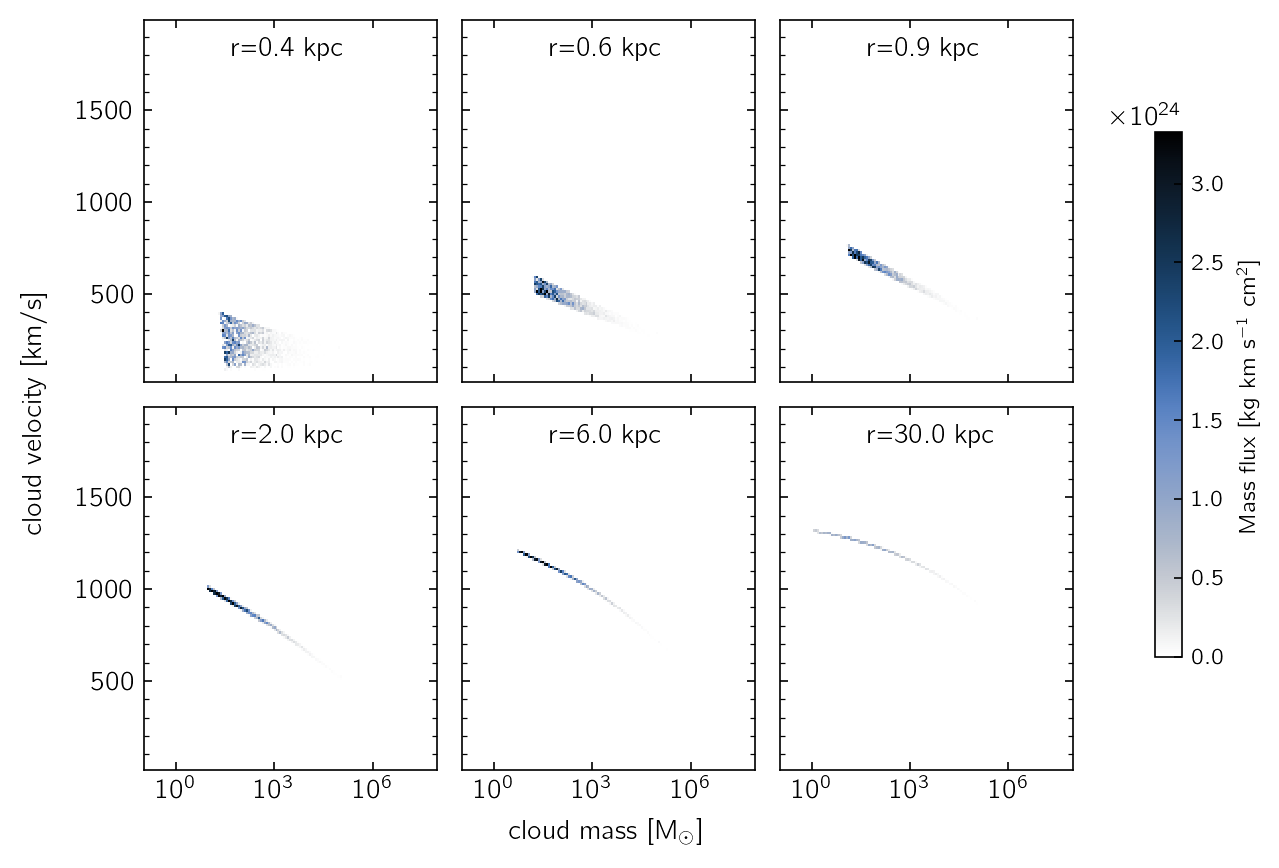

In [13]:
#res=res_slope1
rlist = [400, 600, 900, 2000, 6000, 30000]
cnormal = 1
cmap = 0
save = 0
res.plot_cloud_evo(rlist, cnormal, cmap, save)

30000.0

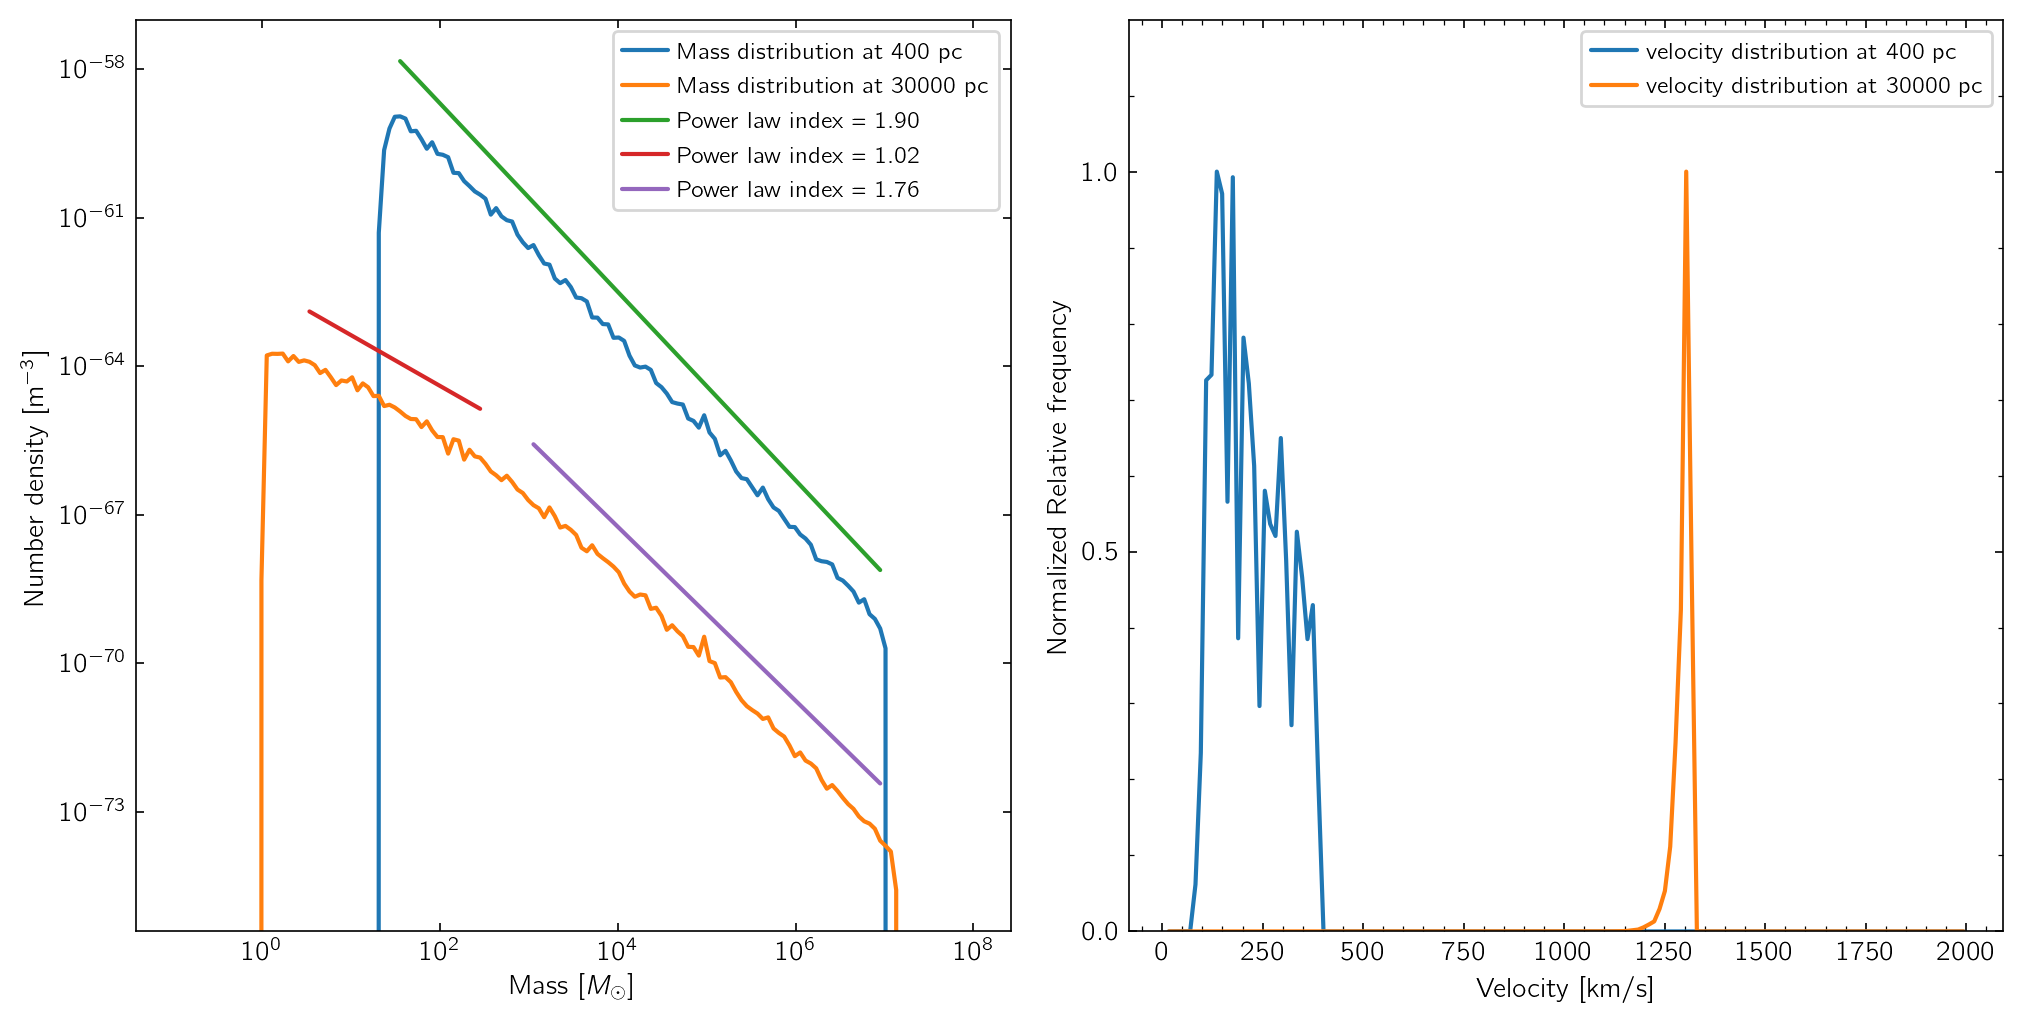

In [14]:
#res=res_slope1
steps= len(res.clouds_info_MC)-1
res.plot_distributions(rlist=[400,30000], line1=[1.5,7,1], line2=[0.5,2.5,1], line3=[3,7,1], show_fit=True, save=0)
res.clouds_info_MC[-1]['r']/pc

In [ ]:
#res.plot_wind()

save = 0

data = [res_slope1, res, res_slope2]
#fig,axes = plt.subplots(2,2,sharex=True,constrained_layout=True)
#ax_arr = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
fig,axes = plt.subplots(2,2,sharex=True,constrained_layout=True)
ax_arr = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ax1, ax2, ax3, ax4 = Utils.plot_wind(data, ax_arr, const)
#fig.text(0.27, -0.04, r'$r\; [{\rm kpc}]$', ha='center')
#fig.text(0.81, -0.04, r'$r\; [{\rm kpc}]$', ha='center')
if save == 1:
    plt.savefig('wind_power_slope', bbox_inches='tight')
    plt.clf()

{'rho_cloud': 3.100376141700174e-28, 'r_cloud': array([5.48934820e+19, 5.74805322e+19, 6.01895062e+19, ...,
       4.78102242e+22, 5.00634506e+22, 5.24228684e+22]), 'v_rel': array([ 1.38550289e+08,  1.38550289e+08,  1.38550289e+08, ...,
       -5.91230441e+07, -5.91230441e+07, -5.91230441e+07]), 'v_turb': array([1.38550289e+07, 1.38550289e+07, 1.38550289e+07, ...,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03]), 't_cool_layer': array(1.49762366e+16), 'ksi': array([2.64551757e-04, 2.77019697e-04, 2.90075233e-04, ...,
       3.19240577e+09, 3.34285922e+09, 3.50040332e+09])}


30000.0

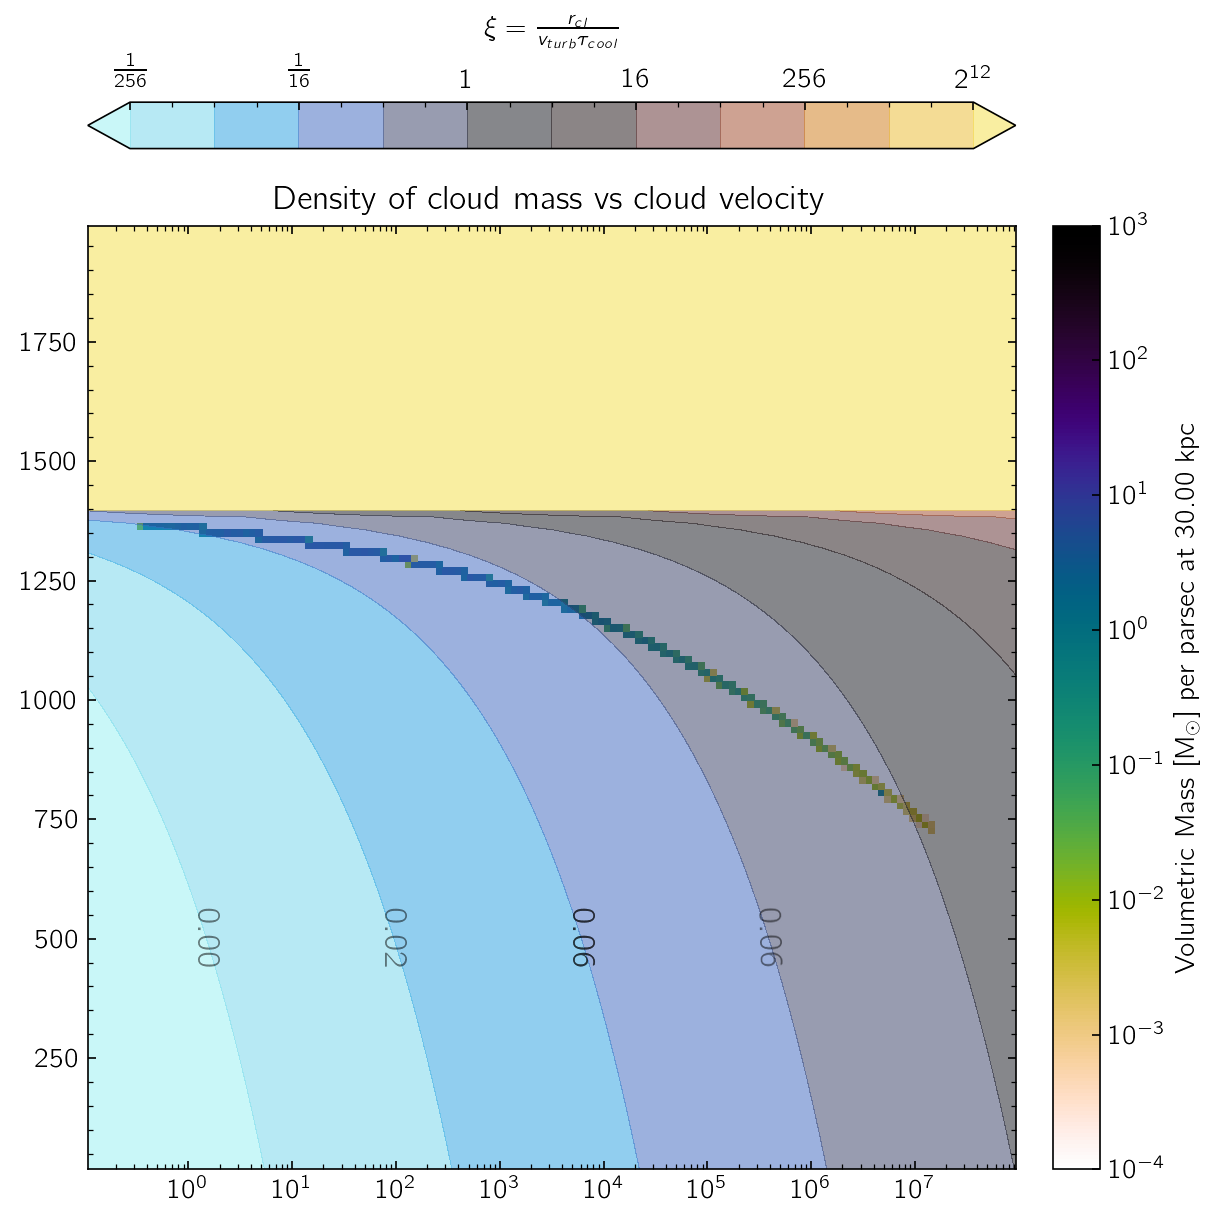

In [15]:
#contour_scale, c_loc, barmax, barmin
steps = len(res.clouds_info_MC)-1
i=steps
#i=340
res.plot_contour(i, 4, 500, 1e3, 1e-4, 'ksi')
res.clouds_info_MC[i]['r']/pc

In [16]:
#(x1_start,x1_end,x1_scale,x1_slope, plot)
x1_info = (1.5,7,-59, -2, False)
x2_info = (0,3,-66.5, -0.22, False)
x3_info = (4,7,-64.5, -0.8, False)
res.plot_mass_MC([1, steps],cloud, false, x1_info, x2_info, x3_info)

NameError: name 'false' is not defined

(9917,)

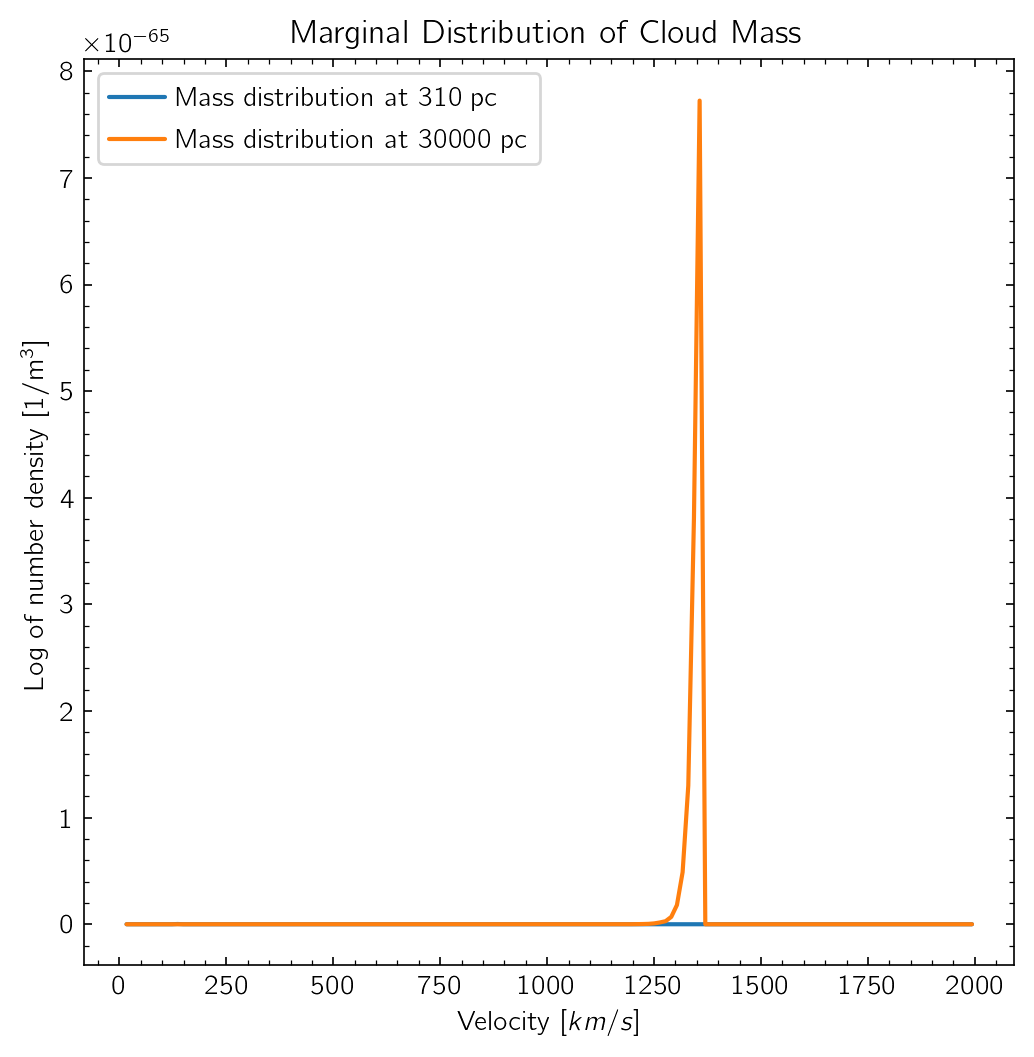

In [17]:
res.plot_velocity_MC([0,steps],cloud, False)

In [1515]:
a=copy.deepcopy(cloud.live)
b=copy.deepcopy(cloud.live)
c=[]
c=[a]
c.append(b)
c


[{'M': array([4.55058605e+33, 8.73585435e+39, 1.21304650e+38, ...,
         2.57524927e+36, 2.42342278e+39, 4.41593677e+39]),
  'v': array([1.27890680e+08, 6.27593552e+07, 9.02857691e+07, ...,
         1.10073573e+08, 7.10890221e+07, 6.71110406e+07]),
  'n': array([7.39475873e-68, 3.33104650e-77, 8.05817503e-76, ...,
         2.38016103e-73, 3.28896029e-79, 1.40911433e-78]),
  'Z': array([0.02646423, 0.02393813, 0.0250597 , ..., 0.02548539, 0.02423449,
         0.02409693])},
 {'M': array([4.55058605e+33, 8.73585435e+39, 1.21304650e+38, ...,
         2.57524927e+36, 2.42342278e+39, 4.41593677e+39]),
  'v': array([1.27890680e+08, 6.27593552e+07, 9.02857691e+07, ...,
         1.10073573e+08, 7.10890221e+07, 6.71110406e+07]),
  'n': array([7.39475873e-68, 3.33104650e-77, 8.05817503e-76, ...,
         2.38016103e-73, 3.28896029e-79, 1.40911433e-78]),
  'Z': array([0.02646423, 0.02393813, 0.0250597 , ..., 0.02548539, 0.02423449,
         0.02409693])}]

In [1516]:
res.plot_scatter(10, res, cloud)

IndexError: list index out of range

In [ ]:
x=res.integrateNFlux([0,steps],cloud)
x,x[1]/x[0]

In [ ]:
res.plot_wind()

In [ ]:
res.plot_cloud([0], cloud)

In [ ]:
res.plot_mass([0,steps-1], cloud)

In [ ]:
res.plot_velocity([0,steps], cloud)


In [ ]:
res.plot_cloud([steps], cloud)

In [ ]:
res.plot_cloud([0], cloud)

In [ ]:
filename = "phase_space.csv"
f = res.cloud_f[1]
res.save_grid(filename,f, cloud)

In [ ]:
filename = "cloud_mass.csv"
f = cloud.M_cloud
res.save_grid(filename, f, cloud)

In [ ]:
filename = "Mdot_over_v.csv"
f = cloud.Mdot_over_v
res.save_grid(filename, f, cloud)

In [ ]:
filename = "vdot_over_v.csv"
f = cloud.vdot_over_v
res.save_grid(filename, f, cloud)

In [ ]:
filename = "M_left.csv"
f = cloud.m_left
res.save_grid(filename, f, cloud)

In [ ]:
filename = "M_right.csv"
f = cloud.m_right
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_m0.csv"
f = control.cfl_m0[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_m1.csv"
f = control.cfl_m1[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_v0.csv"
f = control.cfl_v0[0]
res.save_grid(filename, f, cloud)

In [ ]:
filename = "CFL_v1.csv"
f = control.cfl_v1[0]
res.save_grid(filename, f, cloud)

In [ ]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)


res = Result(const, pm)
wind = Wind(control, const, pm, res)
cloud = CloudMC(wind, control, const, pm, res)
# cloud = Cloud(wind, control, const, pm, res)


In [ ]:
rhoz = res.wind_rhoz
r = res.wind_r
rhoz[0]
res.wind_rhoz[-1], res.wind_rho[-1]

In [ ]:
plt.plot(r,rhoz)

In [ ]:
pm['CLOUD_METALLICITY']

In [ ]:
pm['V_MU']

In [ ]:
wind.metallicity

In [ ]:
res.wind_rho_dot[400], res.wind_p_dot[0], res.wind_epsilon_dot[0]

In [ ]:
res.wind_rho[-1]

In [ ]:
res.wind_P[-1]

In [ ]:
res.clouds[-1]

In [ ]:
sum(res.clouds[10][:,1] * res.clouds[10][:,2])

In [ ]:
sum(res.clouds[10][:,1] * res.clouds[10][:,2])

In [ ]:
sum(res.clouds[-1][:,1] * res.clouds[-1][:,2])

In [ ]:
res.clouds[0][:1][0]

In [ ]:
a = res.clouds[1600][:,0]/const.Msun
min(a)

In [ ]:
cloud.retiredCloud

In [ ]:
min(abs(cloud.dr_M / const.pc))

In [ ]:
min(abs(cloud.dr_v / const.pc))

In [ ]:
len(res.clouds)

In [ ]:
def getCloudSource(dot_params, wind_params, cloud_params, aux_params):        
    Mdot_grow, Mdot_loss = dot_params
    P, v, rho = wind_params
    M_cloud, v_cloud, N_cloud, rho_cloud = cloud_params     
    dr, dvol, gamma, retire_mass, retire_flag = aux_params

    dt = dr/v_cloud
    Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
    Mdot_loss = np.where(M_cloud < retire_mass, M_cloud/dt, Mdot_loss)

    n_cloud = N_cloud/dvol
    rhodot = (Mdot_grow + Mdot_loss) * n_cloud
    pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
    vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
    vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
    epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud                
    return rhodot, pdot, epsilondot    

In [ ]:
res.wind_rho_dot

In [ ]:
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
res = Result(const, pm)
wind = Wind(control, const, pm, res)
cloud = Cloud(wind, control, const, pm, res) 
(Mdot,vdot,Mdot_grow,Mdot_loss,rho_clouds)= Utils.dot_cloud_calc(wind.P, wind.v, wind.rho, cloud.M_cloud, cloud.v_cloud, pm)
r_curr, r_next, dr, dvol = control.get_cloudr_info()

In [ ]:
dot_params = (Mdot_grow, Mdot_loss)
wind_params = (wind.P, wind.v, wind.rho)
cloud_params = (cloud.M_cloud, cloud.v_cloud, cloud.f, rho_clouds)
aux_params = (dr, dvol, gamma, cloud.retire_mass, cloud.retire_flag)  

In [ ]:
Mdot_grow, Mdot_loss = dot_params
P, v, rho = wind_params
M_cloud, v_cloud, N_cloud, rho_cloud = cloud_params     
dr, dvol, gamma, retire_mass, retire_flag = aux_params
dt = dr/v_cloud
Mdot_grow = np.where(M_cloud < retire_mass, 0, Mdot_grow)
Mdot_loss = np.where(M_cloud < retire_mass, M_cloud/dt, Mdot_loss)
n_cloud = N_cloud/dvol
rhodot = (Mdot_grow + Mdot_loss) * n_cloud
pdot = (v * Mdot_grow + v_cloud * Mdot_loss) * n_cloud
vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho   # leave out escape velocity
vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud
epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud    

In [ ]:
sum(rhodot*cloud.integrateDelta), sum(pdot*cloud.integrateDelta), sum(epsilondot*cloud.integrateDelta)

In [ ]:
n_cloud = cloud.f / dvol        
rhodot_grow = Mdot_grow * n_cloud
rhodot_loss = Mdot_loss * n_cloud
rhodot = rhodot_grow + rhodot_loss
pdot = (v * Mdot_grow + cloud.v_cloud * Mdot_loss) * n_cloud
vB_2 = 0.5 * v**2 + cloud.gamma / (cloud.gamma - 1) * P / rho   # leave out escape velocity
vB_cloud_2 = 0.5 * cloud.v_cloud**2 + cloud.gamma / (cloud.gamma - 1) * P / rho_cloud
epsilondot = (vB_2 * Mdot_grow + vB_cloud_2 * Mdot_loss) * n_cloud

In [ ]:
sum(rhodot*cloud.integrateDelta), sum(pdot*cloud.integrateDelta), sum(epsilondot*cloud.integrateDelta)

In [ ]:
cloud.f

In [ ]:
cloud.f_last

In [ ]:
retire_mass

In [ ]:
const.Msun

In [ ]:
def gen_powerlaw1(nbsample, xmin, xmax, power, unit):
    logr = (xmax-xmin) * np.random.random(size=nbsample) + xmin
    r = 10**logr * unit
    b = 10**xmax * unit
    a = 10**xmin * unit
    power += 1
    n = power * r**(power-1) / (b**power - a**power) 
    return r, n  

In [ ]:
gen_powerlaw1(10, -1, 3, -2, const.Msun)

In [ ]:
res.cloud_r

In [ ]:
i = 1

def plot_contour(i):
    _, v, rho, P, _ = res.post_wind_info[i-1]
    #wind_offset = res.Pvrho_start + 500
    #P = res.wind_P[wind_offset]
    #rho=res.wind_rho[wind_offset]
    #v = res.wind_v[wind_offset]

    v_bins = cloud.vbndry
    M_bins = cloud.mbndry
    clouds = res.clouds[i]

    nbs_vbin= len(v_bins)
    nbs_Mbin= len(M_bins)

    M_cloud = np.tile(M_bins, nbs_vbin)
    v_cloud = np.repeat(v_bins, nbs_Mbin)

    (mdot,vdot,_,_,_) = Utils.dot_cloud_calc(P, v, rho, M_cloud, v_cloud, pm)
    vdot = vdot / v_cloud
    mdot2D = np.reshape(mdot,(nbs_vbin, nbs_Mbin))
    vdot2D = np.reshape(vdot,(nbs_vbin, nbs_Mbin))

    f=np.reshape(np.zeros(nbs_vbin * nbs_Mbin),(nbs_vbin,nbs_Mbin))
    v_min = v_bins[0]
    v_max = v_bins[nbs_vbin-1]
    M_min = M_bins[0]
    M_max = M_bins[nbs_Mbin-1]
    for item in clouds:
        if (item[1]>=v_min) and (item[1]<=v_max) and (item[0]>=M_min) and (item[0]<=M_max):
            v_idx = np.max(np.where(v_bins <= item[1]))
            M_idx = np.max(np.where(M_bins <= item[0]))
            f[v_idx][M_idx]+=item[2]

    f, M_bins, v_bins = Utils.binnings_MC(i, res, cloud)


    fig,ax=plt.subplots(1,1,constrained_layout=True)
    colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
    plot = plt.pcolormesh(M_bins/const.Msun, v_bins/const.km, np.abs(f), ### HERE IS WHERE I PLOT THE MASS DISTRIBUTIO
        norm=colors.LogNorm(), #color limits
        cmap=colormap_r) #color map
    cb = fig.colorbar(plot, ax=ax, location="right")
    cb.set_label(r'$\frac{d^2 N_{cl}}{d \log M_{cl} d \log v_{cl}}$') ### PUT YOUR LABEL HERE
    cb.ax.minorticks_off()
    contour = ax.contourf(M_bins/const.Msun,v_bins/const.km, vdot2D, cmap=cmr.iceburn, norm=colors.LogNorm(), alpha=0.5)
    cb = fig.colorbar(contour, ax=ax, location="top")
    cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
    cb.set_label(r'$c_s t_{\rm cool} / L$')
    #plt.figure(figsize=(6,6))
    #plt.pcolormesh(M_bins/const.Msun,v_bins/const.km, np.abs(f),cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
    plt.xscale('log')
    plt.title("Density of cloud mass vs cloud velocity")  
    return

In [ ]:
plot_contour(700)

In [ ]:
testv=[1,2,3]
testm=[1,2,3]
plt.contourf(testv, testm, testf)


In [ ]:
epsilon = 1e-5

def supersonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 + epsilon)

supersonic.terminal = True

def subsonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 - epsilon)

subsonic.terminal = True

def cold_wind(r,z):
    return np.sqrt(gamma*z[2]/z[1])/np.sqrt(gamma*kb*T_cloud/(mu*mp)) - (1.0 + epsilon)

cold_wind.terminal = True


def cloud_stop(r,z):
    return z[5] - 10e5

cloud_stop.terminal = True

def Wind_Evo(r, state):
    v_wind     = state[0]
    rho_wind   = state[1]
    Pressure   = state[2]
    rhoZ_wind  = state[3]
    M_cloud    = state[4]
    v_cloud    = state[5]
    Z_cloud    = state[6]

    # wind properties
    cs_sq_wind   = (gamma*Pressure/rho_wind)
    Mach_sq_wind = (v_wind**2 / cs_sq_wind)
    Z_wind       = rhoZ_wind/rho_wind
    vc           = v_circ0 * np.where(r<r0, r/r0, 1.0)
    Phir         = v_circ0**2 * np.where(r<r0, 0.5 * (r/r0)**2, np.log(r/r0)) 
    # vc           = v_circ0 * np.where(r<r0, (r/r0)**2, 1.0)
    # Phir         = v_circ0**2 * np.where(r<r0, (1/3.) * (r/r0)**3, np.log(r)) 
    vBsq_wind    = 0.5 * v_wind**2 + (gamma / (gamma-1)) * Pressure/rho_wind + Phir

    
    # source term from inside galaxy
    Edot_SN = Edot_per_Vol * np.where(Mach_sq_wind<1, 1.0, 0.0) #* np.where(r<r0, 1.0, 0.0)
    Mdot_SN = Mdot_per_Vol * np.where(Mach_sq_wind<1, 1.0, 0.0) #* np.where(r<r0, 1.0, 0.0)

    # cloud properties
    Ndot_cloud              = Ndot_cloud0 * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
    number_density_cloud    = Ndot_cloud/(Omwind * v_cloud * r**2)
    cs_cl_sq                = gamma * kb*T_cloud/(mu*mp)
    vBsq_cl                 = 0.5 * v_cloud**2 + (1 / (gamma-1)) * cs_cl_sq + Phir
#    print(number_density_cloud)
    # cloud transfer rates
    rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
    chi          = rho_cloud / rho_wind
    r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
    v_rel        = (v_wind-v_cloud)
    v_turb       = f_turb0 * v_rel * chi**TurbulentVelocityChiPower
    T_wind       = Pressure/kb * (mu*mp/rho_wind)
    T_mix        = (T_wind*T_cloud)**0.5
    Z_mix        = (Z_wind*Z_cloud)**0.5
    t_cool_layer = tcool_P(T_mix, Pressure/kb, Z_mix/Z_solar)[()] 
    t_cool_layer = np.where(t_cool_layer<0, 1e10*Myr, t_cool_layer)
    ksi          = r_cloud / (v_turb * t_cool_layer)
    AreaBoost    = geometric_factor * chi**CoolingAreaChiPower
    v_turb_cold  = v_turb * chi**ColdTurbulenceChiPower
    Mdot_grow    = Mdot_coefficient * 3.0 * M_cloud * v_turb * AreaBoost / (r_cloud * chi) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss    = Mdot_coefficient * 3.0 * M_cloud * v_turb_cold / r_cloud 
    Mdot_cloud   = np.where(M_cloud > M_cloud_min, Mdot_grow - Mdot_loss, 0)
    
    
    # density
    drhodt       = (number_density_cloud * Mdot_cloud)
    drhodt_plus  = (number_density_cloud * Mdot_loss)
    drhodt_minus = (number_density_cloud * Mdot_grow) 

    
    # momentum
    p_dot_drag   = 0.5 * drag_coeff * rho_wind * np.pi * v_rel**2 * r_cloud**2 * np.where(M_cloud>M_cloud_min, 1, 0)
    dpdt_drag    = (number_density_cloud * p_dot_drag)
    
    # energy
    e_dot_cool   = 0.0 if (Cooling_Factor==0) else (rho_wind/(muH*mp))**2 * Lambda_P_rho((Pressure,rho_wind))
    # metallicity
    drhoZdt         = -1.0 * (number_density_cloud * (Z_wind*Mdot_grow + Z_cloud*Mdot_loss)) ############## sign #############

    # wind gradients
    # velocity
    dv_dr       = 2/Mach_sq_wind
    dv_dr      += - (vc/v_wind)**2
    dv_dr      +=  drhodt_minus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
    dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
    dv_dr      += (gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
    dv_dr      += -(gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
    dv_dr      += -dpdt_drag/(rho_wind*v_wind**2/r)
    dv_dr      *= (v_wind/r)/(1.0-(1.0/Mach_sq_wind))
    
    # density
    drho_dr       = -2
    drho_dr      += (vc/v_wind)**2
    drho_dr      += -drhodt_minus/(rho_wind*v_wind/r)
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r)
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
    drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
    drho_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
    drho_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
    drho_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
    drho_dr      *= (rho_wind/r)/(1.0-(1.0/Mach_sq_wind))

    # pressure
    dP_dr       = -2
    dP_dr      += (vc/v_wind)**2
    dP_dr      += -drhodt_minus/(rho_wind*v_wind/r)
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r)
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.* (v_rel**2 / cs_sq_wind)
    dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/cs_sq_wind)
    dP_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind*cs_sq_wind/r)
    dP_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind*cs_sq_wind/r)
    dP_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
    dP_dr      *= (Pressure/r)*gamma/(1.0-(1.0/Mach_sq_wind))


    drhoZ_dr   = drho_dr*(rhoZ_wind/rho_wind) + (rhoZ_wind/r) * drhodt_plus/(rho_wind*v_wind/r) * (Z_cloud/Z_wind - 1)

    # cloud gradients
    dM_cloud_dr = Mdot_cloud/v_cloud

    dv_cloud_dr = (p_dot_drag + v_rel*Mdot_grow - M_cloud * vc**2/r) / (M_cloud * v_cloud) * np.where(M_cloud>M_cloud_min, 1, 0)

#    print(p_dot_drag, v_rel, vc**2)
#
    
    dZ_cloud_dr = (Z_wind-Z_cloud) * Mdot_grow / (M_cloud * v_cloud) * np.where(M_cloud>M_cloud_min, 1, 0)

    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]


In [ ]:
def dot_cloud_calc(wind, cloud, tcool_P, pm):   
    # cloud transfer rates
    T_cloud = pm['CLOUD_TEMP']
    f_turb0 = pm['F_TURB0']
    TurbulentVelocityChiPower = pm['TURBULENT_VELOCITY_CHI_POWER'] 
    geometric_factor  = pm['GEOMETRIC_FACTOR']
    CoolingAreaChiPower  = pm['COOLING_AREA_CHI_POWER']
    ColdTurbulenceChiPower = pm['COLD_TURBULENCE_CHI_POWER'] 
    Mdot_coefficient = pm['MDOT_COEFFICIENT']
    drag_coeff = pm['DRAG_COEFF']
    vc = pm['V_CIR']
    M_cloud_min = pm['M_CLOUD_MIN']
    retire_mass = pm['RETIREMENT_MASS']

    Pressure = wind['P']
    v_wind = wind['v']
    rho_wind = wind['rho']
    rhoz_wind = wind['rhoZ']

    M_cloud = cloud['M']
    v_cloud = cloud['v']
    Z_cloud = cloud['Z']
    Z_wind = rhoz_wind / rho_wind
    rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) + [0]*M_cloud # cloud in pressure equilibrium
    chi          = rho_cloud / rho_wind
    r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
    v_rel        = (v_wind-v_cloud)
    v_turb0       = f_turb0 * v_rel * chi**TurbulentVelocityChiPower
    v_turb       = np.where(v_turb0 <=0, 0.001, v_turb0)
    T_wind       = Pressure/kb * (mu*mp/rho_wind)
    T_mix        = (T_wind*T_cloud)**0.5
    Z_mix        = (Z_wind*Z_cloud)**0.5
    t_cool_layer = tcool_P(T_mix, Pressure/kb, Z_mix/const.ZSun)[()] 
    t_cool_layer = np.where(t_cool_layer<0, 1e10*Myr, t_cool_layer)
#        t_cool_layer = 1*Myr
    ksi          = r_cloud / (v_turb * t_cool_layer)
    AreaBoost    = geometric_factor * chi**CoolingAreaChiPower
    v_turb_cold  = v_turb * chi**ColdTurbulenceChiPower
    Mdot_grow    = Mdot_coefficient * 3.0 * M_cloud * v_turb * AreaBoost / (r_cloud * chi) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss    = Mdot_coefficient * 3.0 * M_cloud * v_turb_cold / r_cloud 
    Mdot_cloud   = np.where(M_cloud > M_cloud_min, Mdot_grow - Mdot_loss, 0)        
    return Mdot_grow, Mdot_loss, rho_cloud, r_cloud   


In [ ]:
r_curr = 1.2276036480431476e+21
v_wind = 248610506.6416017
rho_wind = 2.694062712769019e-26
P_wind = 2.051510020042152e-10
rhoZ_wind = 1.077625085107609e-27
M_cloud = 1.73956501e+36
v_cloud = 35007096.61635489
n_cloud = 1.9132472e-61
Z_cloud = 0.04002113

r_curr = control.r_wind
v_wind = wind.state['v']
rho_wind = wind.state['rho']
P_wind = wind.state['P']
rhoZ_wind = wind.state['rhoZ']
M_cloud = cloud.live['M']
v_cloud = cloud.live['v']
n_cloud = cloud.live['n']
Z_cloud = cloud.live['Z']
print(r_curr, v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, n_cloud, Z_cloud)





#{'M': array([1.85834842e+33]), 'v': array([65005163.28693969]), 'n': array([5.06263386e-64]), 'Z': array([8592.95271681])}
#{'v': 142204176.69805276, 'rho': 7.373568468544022e-28, 'P': 3.353927789567221e-13, 'rhoZ': 4.862298959986806e-27}

r0 = 300 * pc
state = np.r_[v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, Z_cloud]
v_circ0 = pm['V_CIR']
Edot_per_Vol = wind.Edot_per_Vol
Mdot_per_Vol = wind.Mdot_per_Vol

Ndot_cloud0 = 1.2683916793505837e-10
cold_cloud_injection_radial_extent = 399 * pc
cold_cloud_injection_radial_power = 0
Omwind = 4 * np.pi

T_cloud = pm['CLOUD_TEMP']
f_turb0 = pm['F_TURB0']
TurbulentVelocityChiPower = pm['TURBULENT_VELOCITY_CHI_POWER']
tcool_P = Cooling('Lambda_tab_redshifts.npz',const).tcool_P
Z_solar = const.ZSun
geometric_factor = pm['GEOMETRIC_FACTOR']
CoolingAreaChiPower = pm['COOLING_AREA_CHI_POWER']
ColdTurbulenceChiPower = pm['COLD_TURBULENCE_CHI_POWER']
Mdot_coefficient = pm['MDOT_COEFFICIENT']
M_cloud_min = pm['M_CLOUD_MIN']
drag_coeff = pm['DRAG_COEFF']
Cooling_Factor = 0
CFL_MC = pm['CFL_MC']

In [ ]:
Wind_Evo(r_curr, state)

In [ ]:
windinfo = Utils.write_wind(np.array([v_wind]), np.array([rho_wind]), np.array([P_wind]), np.array([rhoZ_wind]))
cloudinfo = Utils.write_cloud(np.array([M_cloud]), np.array([v_cloud]), np.array([n_cloud]), np.array([Z_cloud]))

(Mdot_grow, Mdot_loss, rho_clouds, r_clouds) = Utils.dot_cloud_calc(windinfo, cloudinfo, tcool_P, pm) 
control.delta_r = Utils.getdr_MC(cloud.CFL_MC, cloudinfo, Mdot_grow, Mdot_loss)
r_curr, r_next, dr = control.get_cloud_r_info()                
(Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r_curr, Mdot_grow, Mdot_loss, windinfo, cloudinfo, pm)
transfer.update_cloud(Mdot_grow, Mdot_loss, cloudinfo, cloud.retire)
cloud_next = cloud.evolve(dr, r_curr, r_next, cloudinfo, Mdot, vdot, Zdot)


In [ ]:
Mdot/v_cloud, vdot/v_cloud

In [ ]:
r = r_curr 
rho_cloud, r_cloud, pdot_drag = Utils.get_cloud_rho_r_pdotdrag(windinfo, cloudinfo, const, pm)
M_cloud_min = pm['M_CLOUD_MIN']
v_wind = windinfo['v']
rho_wind = windinfo['rho']
rhoZ_wind = windinfo['rhoZ']
M_cloud = cloudinfo['M']
v_cloud = cloudinfo['v']
Z_cloud = cloudinfo['Z']
(vc_sqr, _, _) = Utils.get_vcir2_Phi_vesc2(r, pm)
Mdot = (Mdot_grow - Mdot_loss)
v_rel = v_wind - v_cloud
vdot = (pdot_drag + v_rel*Mdot_grow - M_cloud * vc_sqr/r) / M_cloud * np.where(M_cloud>M_cloud_min, 1, 0)
Z_wind = rhoZ_wind / rho_wind
Mdot_Z = Z_wind * Mdot_grow + Z_cloud * Mdot_loss
Zdot = (Mdot_Z - Z_cloud * Mdot)/M_cloud
Mdot/v_cloud, vdot/v_cloud, Zdot, pdot_drag

In [ ]:
(pdot_drag + v_rel * Mdot_grow - M_cloud * vc_sqr/r) / M_cloud /v_cloud
v_cloud / km

In [ ]:


cloud_live, cloud_retire = Utils.retireCloud(cloud_next, pm)
live = Utils.ntuple2array(cloud_live)
retire = Utils.ntuple2array(cloud_retire)
#self.live['M']=live[0]
#self.live['v']=live[1]
#self.live['n']=live[2]
#self.live['Z']=live[3]
#self.retire['M']=retire[0]
#self.retire['v']=retire[1]
#self.retire['n']=retire[2]
#self.retire['Z']=retire[3]

cloud_next
cloud_live

In [ ]:
pm['SFR']*0.2/(4*np.pi*r**2)/v_cloud / M_cloud

In [ ]:
def supersonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 + epsilon)

supersonic.terminal = True

def subsonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 - epsilon)

subsonic.terminal = True

def cold_wind(r,z):
    return np.sqrt(gamma*z[2]/z[1])/np.sqrt(gamma*kb*T_cloud/(mu*mp)) - (1.0 + epsilon)

cold_wind.terminal = True


def cloud_stop(r,z):
    return z[5] - 10e5

cloud_stop.terminal = True

def calc_wind_source(Phir, wind, cloud, rho_cloud, r_cloud, p_dot_drag, Mdot_grow, Mdot_loss):
    v = wind['v']
    rho = wind['rho']
    P = wind['P']
    rhoz = wind['rhoZ']
    M_cloud = cloud['M']
    v_cloud = cloud['v']
    n_cloud = cloud['n']
    Z_cloud = cloud['Z']

    Z_wind = rhoz / rho
    dpdt_drag    = (n_cloud * p_dot_drag)        
    rho_dot_plus = Mdot_loss * n_cloud
    rho_dot_minus = Mdot_grow * n_cloud
    rho_dot = rho_dot_plus - rho_dot_minus
    p_dot = rho_dot_plus*v_cloud - rho_dot_minus*v - dpdt_drag
    vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho + Phir
    vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud + Phir
    epsilon_dot = rho_dot_plus * vB_cloud_2 - rho_dot_minus * vB_2 - dpdt_drag * v_cloud
    rhoz_dot = Z_cloud * rho_dot_plus - Z_wind * rho_dot_minus   
#    print(Phir, wind, cloud, rho_cloud, r_cloud, p_dot_drag, Mdot_grow, Mdot_loss)
    if dump_source_test == 1: print(rho_dot, p_dot, epsilon_dot, rhoz_dot)
    return rho_dot, p_dot, epsilon_dot, rhoz_dot 

def evolve(r, z):
    v,rho,P, rhoz, M_cloud, v_cloud, Z_cloud= z
    a = dot_info(r, z) 
    dv_dr = a[0]
    drho_dr = a[1]
    dP_dr = a[2]
    drhoz_dr = a[3]
    dM_cloud_dr = a[4]
    dv_cloud_dr = a[5]
    dZ_cloud_dr = a[6]
    return [dv_dr, drho_dr, dP_dr, drhoz_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr] 

def dot_info(r, states):
    
    r0 = pm['SONIC_POINT']
    r1 = pm['R_START']
    gamma = pm['GAMMA']
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    SFR = pm['SFR']
    M0 = 10**pm['M_MU'] * const.Msun
    v0 = pm['V_MU'] * const.km    
    cold_cloud_injection_radial_extent = 399 * pc
    cold_cloud_injection_radial_power = np.inf
    
    
    
    v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, Z_cloud = states 
    if dump_wind_test == 1: print('WIND_TEST', r/pc, v_wind, rho_wind, P_wind, rhoZ_wind)  
    
  

    
    n_cloud = SFR*0.2 / (1000  * Msun) / (4 * np.pi *r**2 * v_cloud)  
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': P_wind, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': n_cloud, 'Z': Z_cloud}

    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, n_cloud, Z_cloud)
    
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol

    cs_sqr = gamma * P_wind / rho_wind
    mach_sqr = v_wind**2 / cs_sqr
    
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    
    
    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm)     

    
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)
    
    
    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)
    
    
    
    dv_dr  = 2/mach_sqr
    dv_dr += -vc_sqr/v_wind**2
    dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
    dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


    drho_dr  = -2
    drho_dr += vc_sqr/v_wind**2
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
    drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

    dP_dr  = -2
    dP_dr += vc_sqr/v_wind**2
    dP_dr += rho_dot/(rho_wind*v_wind/r)
    dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
    dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
    dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
    dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    
    
    
    Z_wind = rhoZ_wind / rho_wind
    
#    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v - Z_wind * rho_dot /v
    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind
    
    
    
    dM_cloud_dr = Mdot/v_cloud
    dv_cloud_dr = vdot/v_cloud   
    dZ_cloud_dr = Zdot/v_cloud
    
    
    
    
    
    
#    print(dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)


    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]



In [ ]:
def evolve2(r, z):
    v,rho,P, rhoz, M_cloud, v_cloud, Z_cloud= z
    a = dot_info2(r, z) 
    dv_dr = a[0]
    drho_dr = a[1]
    dP_dr = a[2]
    drhoz_dr = a[3]
    dM_cloud_dr = a[4]
    dv_cloud_dr = a[5]
    dZ_cloud_dr = a[6]
    return [dv_dr, drho_dr, dP_dr, drhoz_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr] 





def dot_info2(r, states):
    
    r0 = pm['SONIC_POINT']
    r1 = pm['R_START']
    gamma = pm['GAMMA']
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    SFR = pm['SFR']
    M0 = 10**pm['M_MU'] * const.Msun
    v0 = pm['V_MU'] * const.km    
    cold_cloud_injection_radial_extent = 399 * pc
    cold_cloud_injection_radial_power = np.inf
    
    v_wind, rho_wind, P_wind, rhoZ_wind, M_cloud, v_cloud, Z_cloud = states
    if dump_wind_test == 1: print('WIND_TEST', r/pc, v_wind, rho_wind, Pressure, rhoZ_wind)

    n_cloud = SFR*0.2 / (1000  * Msun) / (4 * np.pi *r**2 * v_cloud)    
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': P_wind, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': n_cloud, 'Z': Z_cloud} 
    
    n_cloud = n_cloud * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
#    print(n_cloud, r/pc, cold_cloud_injection_radial_extent/pc, cold_cloud_injection_radial_power )

    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, number_density_cloud, Z_cloud)
    
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol

    cs_sqr = gamma * P_wind / rho_wind
    mach_sqr = v_wind**2 / cs_sqr
    
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    
#    print(vc_sqr, Phir, vesc_sqr)

    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm)   
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)

    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)
#    print(rho_dot, p_dot, e_dot, rhoz_dot)
#    rho_dot, p_dot, e_dot, rhoz_dot = (0,0,0,0)    
    
    # wind gradients
    
    Mach_sq_wind = mach_sqr
    vc = vc_sqr**0.5
    cs_sq_wind = cs_sqr
    cs_cl_sq = gamma * P_wind / rho_cloud
    e_dot_cool = 0
    v_rel = v_wind - v_cloud
    dpdt_drag = pdot_drag * n_cloud
    Pressure = P_wind

    
    
    drhodt_plus  = (n_cloud * Mdot_loss)
    drhodt_minus = (n_cloud * Mdot_grow) 
    drhodt       = (n_cloud * Mdot)
    
#    print(drhodt_plus, drhodt_minus, n_cloud)
    if (1==0):   
        # velocity
        dv_dr       = 2/Mach_sq_wind
        dv_dr      += - (vc/v_wind)**2
        dv_dr      +=  drhodt_minus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
        dv_dr      += (gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
        dv_dr      += -(gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
        dv_dr      += -dpdt_drag/(rho_wind*v_wind**2/r)
        dv_dr      *= (v_wind/r)/(1.0-(1.0/Mach_sq_wind))

        # density
        drho_dr       = -2
        drho_dr      += (vc/v_wind)**2
        drho_dr      += -drhodt_minus/(rho_wind*v_wind/r)
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r)
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
        drho_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
        drho_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
        drho_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
        drho_dr      *= (rho_wind/r)/(1.0-(1.0/Mach_sq_wind))

        # pressure
        dP_dr       = -2
        dP_dr      += (vc/v_wind)**2
        dP_dr      += -drhodt_minus/(rho_wind*v_wind/r)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.* (v_rel**2 / cs_sq_wind)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/cs_sq_wind)
        dP_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind*cs_sq_wind/r)
        dP_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind*cs_sq_wind/r)
        dP_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
        dP_dr      *= (Pressure/r)*gamma/(1.0-(1.0/Mach_sq_wind))
    else:

        dv_dr  = 2/mach_sqr
        dv_dr += -vc_sqr/v_wind**2
        dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
        dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


        drho_dr  = -2
        drho_dr += vc_sqr/v_wind**2
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
        drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

        dP_dr  = -2
        dP_dr += vc_sqr/v_wind**2
        dP_dr += rho_dot/(rho_wind*v_wind/r)
        dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
        dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
        dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
        dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    

    
    
    Z_wind = rhoZ_wind / rho_wind
    
    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind      
    
    dM_cloud_dr = Mdot/v_cloud
    dv_cloud_dr = vdot/v_cloud
    dZ_cloud_dr = Zdot/v_cloud
    
    
#    print(drhoZ_dr, drhoZ_dr1, drhoZ_dr2)
#    print(r/pc, dv_dr, drho_dr, dP_dr, drhoZ_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)

    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]



In [ ]:
def Wind_Evo(r, state):
    v_wind     = state[0]
    rho_wind   = state[1]
    Pressure   = state[2]
    rhoZ_wind  = state[3]
    M_cloud    = state[4]
    v_cloud    = state[5]
    Z_cloud    = state[6]
    
    if dump_wind_test == 1: print('WIND_TEST', round(r/pc), v_wind, rho_wind, Pressure, rhoZ_wind)

    
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    v_cir0 = pm['V_CIR']
    r0 = pm['SONIC_POINT']
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol  
    M_cloud0    = 10**3 * Msun
    Ndot_cloud0 = pm['SFR'] * 0.2 / M_cloud0
#    cold_cloud_injection_radial_extent = 1.33 * r0
    cold_cloud_injection_radial_power = np.inf
    Omwind = 4*np.pi
#    f_turb0 = pm['F_TURB0']
#    Cooling_Factor              = 0 #1.0
    drag_coeff                  = 0.5
#    Z_solar = 0.02
    M_cloud_min = 1e-2*Msun
    

    
    # wind properties
    cs_sq_wind = gamma * Pressure / rho_wind
    Mach_sq_wind = v_wind**2 / cs_sq_wind
    
    Z_wind       = rhoZ_wind/rho_wind
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    vc = vc_sqr**0.5
    
    Ndot_cloud              = Ndot_cloud0 * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
    number_density_cloud    = Ndot_cloud/(Omwind * v_cloud * r**2)

    
    
    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, number_density_cloud, Z_cloud)       
    
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': Pressure, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': number_density_cloud, 'Z': Z_cloud} 

    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm) 
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)

    Mdot_cloud = Mdot
    v_rel = v_wind-v_cloud
    
    # density
    drhodt       = (number_density_cloud * Mdot_cloud)
    drhodt_plus  = (number_density_cloud * Mdot_loss)
    drhodt_minus = (number_density_cloud * Mdot_grow) 
    dpdt_drag  = (number_density_cloud * pdot_drag)
    

    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)    
    mach_sqr = Mach_sq_wind
    P_wind = Pressure
    
    
    dv_dr  = 2/mach_sqr
    dv_dr += -vc_sqr/v_wind**2
    dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
    dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


    drho_dr  = -2
    drho_dr += vc_sqr/v_wind**2
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
    drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

    dP_dr  = -2
    dP_dr += vc_sqr/v_wind**2
    dP_dr += rho_dot/(rho_wind*v_wind/r)
    dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
    dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
    dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
    dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    
    
    
    drhoZ_dr   = drho_dr*(rhoZ_wind/rho_wind) + (rhoZ_wind/r) * drhodt_plus/(rho_wind*v_wind/r) * (Z_cloud/Z_wind - 1)

    dM_cloud_dr = Mdot_cloud/v_cloud
    dv_cloud_dr = vdot / v_cloud
    dZ_cloud_dr = Zdot / v_cloud
    
#    print(r/pc, dv_dr, drho_dr, dP_dr, drhoZ_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)
    
    
    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]


In [626]:
def supersonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 + epsilon)

supersonic.terminal = True

def subsonic(r,z):
    return z[0]/np.sqrt(gamma*z[2]/z[1]) - (1.0 - epsilon)

subsonic.terminal = True

def cold_wind(r,z):
    return np.sqrt(gamma*z[2]/z[1])/np.sqrt(gamma*kb*T_cloud/(mu*mp)) - (1.0 + epsilon)

cold_wind.terminal = True


def cloud_stop(r,z):
    return z[5] - 10e5

cloud_stop.terminal = True


def calc_wind_source(Phir, wind, cloud, rho_cloud, r_cloud, p_dot_drag, Mdot_grow, Mdot_loss):
    v = wind['v']
    rho = wind['rho']
    P = wind['P']
    rhoz = wind['rhoZ']
    M_cloud = cloud['M']
    v_cloud = cloud['v']
    n_cloud = cloud['n']
    Z_cloud = cloud['Z']

    Z_wind = rhoz / rho
    dpdt_drag    = (n_cloud * p_dot_drag)        
    rho_dot_plus = Mdot_loss * n_cloud
    rho_dot_minus = Mdot_grow * n_cloud
    rho_dot = rho_dot_plus - rho_dot_minus
    p_dot = rho_dot_plus*v_cloud - rho_dot_minus*v - dpdt_drag
    vB_2 = 0.5 * v**2 + gamma / (gamma - 1) * P / rho + Phir
    vB_cloud_2 = 0.5 * v_cloud**2 + gamma / (gamma - 1) * P / rho_cloud + Phir
    epsilon_dot = rho_dot_plus * vB_cloud_2 - rho_dot_minus * vB_2 - dpdt_drag * v_cloud
    rhoz_dot = Z_cloud * rho_dot_plus - Z_wind * rho_dot_minus        
    if dump_source_test == 1: print(rho_dot, p_dot, epsilon_dot, rhoz_dot)
    return rho_dot, p_dot, epsilon_dot, rhoz_dot 

def evolve_check(r, state):
    v_wind     = state[0]
    rho_wind   = state[1]
    Pressure   = state[2]
    rhoZ_wind  = state[3]
    M_cloud    = state[4]
    v_cloud    = state[5]
    Z_cloud    = state[6]
    
    if dump_wind_test == 1: print('WIND_TEST', round(r/pc), v_wind, rho_wind, Pressure, rhoZ_wind)

    
    Mdot = pm['MDOT']
    Edot = pm['EDOT']
    v_cir0 = pm['V_CIR']
    r0 = pm['SONIC_POINT']
    Vol = 4/3 * np.pi * r0**3         
    Mdot_per_Vol = Mdot / Vol    
    Edot_per_Vol = Edot / Vol  
    M_cloud0    = 10**3 * Msun
    Ndot_cloud0 = pm['SFR'] * 0.2 / M_cloud0
#    cold_cloud_injection_radial_extent =  1.06666666665 * r0 #1.33 * r0
    cold_cloud_injection_radial_power = np.inf
    Omwind = 4*np.pi
#    f_turb0 = pm['F_TURB0']
#    Cooling_Factor              = 0 #1.0
    drag_coeff                  = 0.5
#    Z_solar = 0.02
    M_cloud_min = 1e-2*Msun
    

    
    # wind properties
    cs_sq_wind = gamma * Pressure / rho_wind
    Mach_sq_wind = v_wind**2 / cs_sq_wind
    
    Z_wind       = rhoZ_wind/rho_wind
    vc_sqr, Phir, vesc_sqr = Utils.get_vcir2_Phi_vesc2(r, pm)
    vc = vc_sqr**0.5
    
    Ndot_cloud              = Ndot_cloud0 * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
    number_density_cloud    = Ndot_cloud/(Omwind * v_cloud * r**2)

    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, number_density_cloud, Z_cloud)       
    
    wind0 = {'v': v_wind, 'rho': rho_wind, 'P': Pressure, 'rhoZ': rhoZ_wind}
    cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': number_density_cloud, 'Z': Z_cloud} 

    (Mdot_grow, Mdot_loss, rho_cloud, r_cloud) = Utils.dot_cloud_calc(wind0, cloud0, tcool_P, pm) 
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r, Mdot_grow, Mdot_loss, wind0, cloud0, pm)
    
    if dump_Mdot_test == 1: print(Mdot, vdot, v_cloud, Mdot/v_cloud, vdot/v_cloud)
    
    Mdot_cloud = Mdot
    v_rel = v_wind-v_cloud
    
    # density
#    drhodt       = (number_density_cloud * Mdot_cloud)
#    drhodt_plus  = (number_density_cloud * Mdot_loss)
#    drhodt_minus = (number_density_cloud * Mdot_grow) 
    dpdt_drag  = (number_density_cloud * pdot_drag)
    

    rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)    
    mach_sqr = Mach_sq_wind
    P_wind = Pressure
    
    
    dv_dr  = 2/mach_sqr
    dv_dr += -vc_sqr/v_wind**2
    dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
    dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


    drho_dr  = -2
    drho_dr += vc_sqr/v_wind**2
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
    drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
    drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
    drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
    drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
    drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

    dP_dr  = -2
    dP_dr += vc_sqr/v_wind**2
    dP_dr += rho_dot/(rho_wind*v_wind/r)
    dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
    dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
    dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
    dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    
    
    drhoZ_dr = Z_wind * drho_dr + rhoz_dot / v_wind - Z_wind * rho_dot /v_wind    
#    drhoZ_dr   = drho_dr*(rhoZ_wind/rho_wind) + (rhoZ_wind/r) * drhodt_plus/(rho_wind*v_wind/r) * (Z_cloud/Z_wind - 1)

    dM_cloud_dr = Mdot_cloud/v_cloud
    dv_cloud_dr = vdot / v_cloud
    dZ_cloud_dr = Zdot / v_cloud
    
#    print(r/pc, dv_dr, drho_dr, dP_dr, drhoZ_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)
    
    
    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]


In [627]:
def Wind_Evo_Ori(r, state):
    v_wind     = state[0]
    rho_wind   = state[1]
    Pressure   = state[2]
    rhoZ_wind  = state[3]
    M_cloud    = state[4]
    v_cloud    = state[5]
    Z_cloud    = state[6]

    # wind properties
    cs_sq_wind   = (gamma*Pressure/rho_wind)
    Mach_sq_wind = (v_wind**2 / cs_sq_wind)
    Z_wind       = rhoZ_wind/rho_wind
    vc           = v_circ0 * np.where(r<r0, r/r0, 1.0)
    Phir         = v_circ0**2 * np.where(r<r0, 0.5 * (r/r0)**2, np.log(r/r0)) 
    # vc           = v_circ0 * np.where(r<r0, (r/r0)**2, 1.0)
    # Phir         = v_circ0**2 * np.where(r<r0, (1/3.) * (r/r0)**3, np.log(r)) 
    vBsq_wind    = 0.5 * v_wind**2 + (gamma / (gamma-1)) * Pressure/rho_wind + Phir

    
    # source term from inside galaxy
    Edot_SN = Edot_per_Vol * np.where(Mach_sq_wind<1, 1.0, 0.0) #* np.where(r<r0, 1.0, 0.0)
    Mdot_SN = Mdot_per_Vol * np.where(Mach_sq_wind<1, 1.0, 0.0) #* np.where(r<r0, 1.0, 0.0)

    # cloud properties
    Ndot_cloud              = Ndot_cloud0 * np.where(r<cold_cloud_injection_radial_extent, (r/cold_cloud_injection_radial_extent)**cold_cloud_injection_radial_power, 1.0)
    number_density_cloud    = Ndot_cloud/(Omwind * v_cloud * r**2)
    cs_cl_sq                = gamma * kb*T_cloud/(mu*mp)
    vBsq_cl                 = 0.5 * v_cloud**2 + (1 / (gamma-1)) * cs_cl_sq + Phir
  

    
    # cloud transfer rates
    rho_cloud    = Pressure * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
    chi          = rho_cloud / rho_wind
    r_cloud      = (M_cloud / ( 4*np.pi/3. * rho_cloud))**(1/3.) 
    v_rel        = (v_wind-v_cloud)
    v_turb       = f_turb0 * v_rel * chi**TurbulentVelocityChiPower
    T_wind       = Pressure/kb * (mu*mp/rho_wind)
    T_mix        = (T_wind*T_cloud)**0.5
    Z_mix        = (Z_wind*Z_cloud)**0.5
    t_cool_layer = tcool_P(T_mix, Pressure/kb, Z_mix/Z_solar)[()] 
    t_cool_layer = np.where(t_cool_layer<0, 1e10*Myr, t_cool_layer)
    ksi          = r_cloud / (v_turb * t_cool_layer)
    AreaBoost    = geometric_factor * chi**CoolingAreaChiPower
    v_turb_cold  = v_turb * chi**ColdTurbulenceChiPower
    Mdot_grow    = Mdot_coefficient * 3.0 * M_cloud * v_turb * AreaBoost / (r_cloud * chi) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss    = Mdot_coefficient * 3.0 * M_cloud * v_turb_cold / r_cloud 
    Mdot_cloud   = np.where(M_cloud > M_cloud_min, Mdot_grow - Mdot_loss, 0)

    # density
    drhodt       = (number_density_cloud * Mdot_cloud)
    drhodt_plus  = (number_density_cloud * Mdot_loss)
    drhodt_minus = (number_density_cloud * Mdot_grow) 

    
    # momentum
    p_dot_drag   = 0.5 * drag_coeff * rho_wind * np.pi * v_rel**2 * r_cloud**2 * np.where(M_cloud>M_cloud_min, 1, 0)
    dpdt_drag    = (number_density_cloud * p_dot_drag)

    # energy
    e_dot_cool   = 0.0 if (Cooling_Factor==0) else (rho_wind/(muH*mp))**2 * Lambda_P_rho((Pressure,rho_wind))
    # metallicity
    drhoZdt         = -1.0 * (number_density_cloud * (Z_wind*Mdot_grow + Z_cloud*Mdot_loss)) ############## sign #############

#    print(round(r/pc)) 


    if (1==0):
        mach_sqr = Mach_sq_wind
        vc_sqr = vc**2
        pdot_drag = p_dot_drag
        vesc_sqr = -2 * Phir
        P_wind = Pressure
        wind0 = {'v': v_wind, 'rho': rho_wind, 'P': Pressure, 'rhoZ': rhoZ_wind}
        cloud0 = {'M': M_cloud, 'v': v_cloud, 'n': number_density_cloud, 'Z': Z_cloud} 
        rho_dot, p_dot, e_dot, rhoz_dot = calc_wind_source(Phir, wind0, cloud0, rho_cloud, r_cloud, pdot_drag, Mdot_grow, Mdot_loss)    
        
        dv_dr  = 2/mach_sqr
        dv_dr += -vc_sqr/v_wind**2
        dv_dr += -rho_dot/(rho_wind*v_wind/r) * (gamma+1)*0.5
        dv_dr += 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        dv_dr += -1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        dv_dr += - rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        dv_dr *= (v_wind/r) * (1/(1-1/mach_sqr))    


        drho_dr  = -2
        drho_dr += vc_sqr/v_wind**2
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma+3)*0.5
        drho_dr -= 1/(rho_wind*v_wind/r)  * gamma*p_dot/v_wind
        drho_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*e_dot/v_wind**2 
        drho_dr -= rho_dot/(rho_wind*v_wind/r) * 1/mach_sqr
        drho_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*vesc_sqr/v_wind**2
        drho_dr *= (rho_wind/r) * (1/(1-1/mach_sqr))

        dP_dr  = -2
        dP_dr += vc_sqr/v_wind**2
        dP_dr += rho_dot/(rho_wind*v_wind/r)
        dP_dr += rho_dot/(rho_wind*v_wind/r) * (gamma-1)*0.5*mach_sqr*(1+vesc_sqr/v_wind**2)
        dP_dr -= 1/(rho_wind*v_wind/r)  * p_dot/v_wind
        dP_dr += 1/(rho_wind*v_wind/r) * (gamma-1)*mach_sqr*(e_dot-p_dot*v_wind)/v_wind**2
        dP_dr *= (P_wind/r) * (gamma/(1-1/mach_sqr))
    else:

    # wind gradients
    # velocity
        dv_dr       = 2/Mach_sq_wind
        dv_dr      += - (vc/v_wind)**2
        dv_dr      +=  drhodt_minus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (1/Mach_sq_wind)
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
        dv_dr      += -drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
        dv_dr      += (gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
        dv_dr      += -(gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
        dv_dr      += -dpdt_drag/(rho_wind*v_wind**2/r)
        dv_dr      *= (v_wind/r)/(1.0-(1.0/Mach_sq_wind))

        # density
        drho_dr       = -2
        drho_dr      += (vc/v_wind)**2
        drho_dr      += -drhodt_minus/(rho_wind*v_wind/r)
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r)
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.*(v_rel/v_wind)**2
        drho_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/v_wind**2)
        drho_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind**3/r)
        drho_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind**3/r)
        drho_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
        drho_dr      *= (rho_wind/r)/(1.0-(1.0/Mach_sq_wind))

        # pressure
        dP_dr       = -2
        dP_dr      += (vc/v_wind)**2
        dP_dr      += -drhodt_minus/(rho_wind*v_wind/r)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * v_rel/v_wind
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (gamma-1)/2.* (v_rel**2 / cs_sq_wind)
        dP_dr      += drhodt_plus/(rho_wind*v_wind/r) * (-(cs_sq_wind - cs_cl_sq)/cs_sq_wind)
        dP_dr      += -(gamma-1)*e_dot_cool/(rho_wind*v_wind*cs_sq_wind/r)
        dP_dr      += (gamma-1)*dpdt_drag*v_rel/(rho_wind*v_wind*cs_sq_wind/r)
        dP_dr      += dpdt_drag/(rho_wind*v_wind**2/r)
        dP_dr      *= (Pressure/r)*gamma/(1.0-(1.0/Mach_sq_wind))


    drhoZ_dr   = drho_dr*(rhoZ_wind/rho_wind) + (rhoZ_wind/r) * drhodt_plus/(rho_wind*v_wind/r) * (Z_cloud/Z_wind - 1)

    # cloud gradients
    dM_cloud_dr = Mdot_cloud/v_cloud

    dv_cloud_dr = (p_dot_drag + v_rel*Mdot_grow - M_cloud * vc**2/r) / (M_cloud * v_cloud) * np.where(M_cloud>M_cloud_min, 1, 0)

    dZ_cloud_dr = (Z_wind-Z_cloud) * Mdot_grow / (M_cloud * v_cloud) * np.where(M_cloud>M_cloud_min, 1, 0)

    if dump_cloud_test == 1: print('CLOUD_TEST', round(r/pc), M_cloud, v_cloud, number_density_cloud, Z_cloud)       

    
#    print(dv_dr, drho_dr, dP_dr, drhoZ_dr)
#    print(r/pc, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr)
    
    
    return np.r_[dv_dr, drho_dr, dP_dr, drhoZ_dr, dM_cloud_dr, dv_cloud_dr, dZ_cloud_dr]


In [665]:
dump_wind_test = 0
dump_cloud_test = 0
dump_source_test = 0
dump_Mdot_test = 0
dump_wind = 0
dump_Mdot = 0
dump_source = 0

epsilon = 1e-5
r0 = 300 * pc
T_cloud = pm['CLOUD_TEMP']
v_circ0 = 150*km

###### 400 pc ########
r_init = 1.2344e+21
v_init = 249284844.32131106
rho_init = 2.6572708207234414e-26
P_init = 2.0050282916542196e-10
rhoZ_init = 1.0629083282893774e-27
M_cloud0 = 2.0000000000436914e+36
v_cloud0 = 3162277.6601710124
n_cloud = 2.0947475649755847e-60
Z_cloud0 = 0.02

###### 320 pc #########
r_init = 9.8752e+20
v_init = 205314317.87010413
rho_init = 5.041183240216639e-26
P_init = 5.829280409378286e-10
rhoZ_init = 2.0164732960866574e-27
M_cloud0 = 2.0000000000157267e+36
v_cloud0 = 3162277.6601665663
n_cloud = 3.273043070324717e-60
Z_cloud0 = 0.02


###### 306 pc #########
r_init = 9.44316e+20
v_init = 184859757.37636435
rho_init = 6.123030817317687e-26
P_init = 8.060058911858144e-10
rhoZ_init = 2.4492123269270772e-27
M_cloud0 = 2.000000000000781e+36
v_cloud0 = 3162277.660166273
n_cloud = 3.579388380577841e-60
Z_cloud0 = 0.02

#WIND 306 184859757.37636435 6.123030817317687e-26 8.060058911858144e-10 2.4492123269270772e-27
#CLOUD 9.44316e+20 2.0000000000007627e+36 3162277.66016948 3.579388380574244e-60 0.02
#CLOUD 306 1.9999861311207666e+36 3163858.798999571 3.577579691032812e-60 0.020000189622778095
#WIND 306 184845233.80116358 6.123562753798572e-26 8.061014509350533e-10 2.449384896281229e-27

#WIND 400 249284844.32131106 2.6572708207234414e-26 2.0050282916542196e-10 1.0629083282893774e-27
#CLOUD 1.2344e+21 2.0000000000034235e+36 3162277.660169439 2.0947475650188023e-60 0.02


end = 20000 * pc

cold_cloud_injection_radial_extent = 1.33 * r0 #1.33 * r0
tcool_P = Cooling('Lambda_tab_redshifts.npz',const).tcool_P
const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
res = Result(const, pm)
transfer = Transfer(const, pm)
wind = Wind(control, const, pm, res, transfer)

Mdot = pm['MDOT']
Edot = pm['EDOT']
Vol = 4/3 * np.pi * r0**3         
Mdot_per_Vol = Mdot / Vol    
Edot_per_Vol = Edot / Vol 
M_cloud0    = 10**3 * Msun
Ndot_cloud0 = pm['SFR'] * 0.15 / M_cloud0
cold_cloud_injection_radial_power = np.inf
f_turb0 = pm['F_TURB0']
Omwind = 4*np.pi
Z_solar = 0.02
Cooling_Factor = 0
geometric_factor = pm['GEOMETRIC_FACTOR']
CoolingAreaChiPower = pm['COOLING_AREA_CHI_POWER']
ColdTurbulenceChiPower = pm['COLD_TURBULENCE_CHI_POWER']
TurbulentVelocityChiPower=pm['TURBULENT_VELOCITY_CHI_POWER']
Mdot_coefficient = pm['MDOT_COEFFICIENT']
M_cloud_min = pm['M_CLOUD_MIN']
drag_coeff = pm['DRAG_COEFF']


supersonic_initial_conditions = np.r_[v_init, rho_init, P_init, rhoZ_init, M_cloud0, v_cloud0, Z_cloud0]
sol = solve_ivp(Wind_Evo_Ori, [r_init, end], supersonic_initial_conditions, events=[supersonic,cloud_stop,cold_wind], dense_output=True,rtol=1e-10)
print(sol.message)
print(sol.t_events)

#Wind_Evo_Ori  CLOUD_TEST 4000.0 1.3287373716899853e+36 88641636.87604417 7.472981842413204e-64 0.025733038911737404
#Wind_Evo_Ori2 CLOUD_TEST 4000.0 1.3287372574947245e+36 88641635.00700058 7.472981999983953e-64 0.02573303881475078

The solver successfully reached the end of the integration interval.
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


In [666]:
r           = sol.t
v_wind      = sol.y[0]
rho_wind    = sol.y[1]
P_wind      = sol.y[2]
rhoZ_wind   = sol.y[3]
M_cloud     = sol.y[4]
v_cloud     = sol.y[5]
Z_cloud     = sol.y[6]

r[-1]/pc, M_cloud[-1], v_cloud[-1], Z_cloud[-1]
#WIND_TEST 20000.0 128329370.16536728 4.123990580886562e-29 4.239928295018014e-15 1.1104898896830705e-30
#CLOUD_TEST 20000.0 1.0026598060567596e+36 102066621.07993874 2.5960194854992073e-65 0.026146963423153077

(20000.0, 7.07964443705436e+35, 114228061.25686567, 0.02693671654547021)

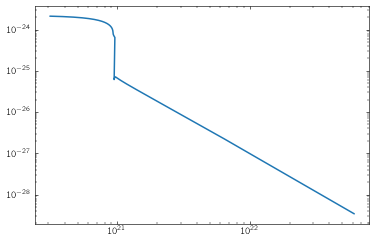

In [667]:
_r,_v,_rho,_P,_rhoZ = Utils.ntuple2array(res.pre_wind_info)

r_ = sol.t
v_ = sol.y[0]
rho_ = sol.y[1]
P_ = sol.y[2]
rhoZ_ = sol.y[3]
M_cloud = sol.y[4]
v_cloud = sol.y[5]
Z_cloud = sol.y[6]

r = np.r_[_r,r_]
v = np.r_[_v,v_]
P = np.r_[_P,P_]
rho = np.r_[_rho,rho_]
rhoZ = np.r_[_rhoZ, rhoZ_]

plt.plot(r,rho)
plt.yscale('log')
plt.xscale('log')

In [658]:
res.clouds_info_MC[0]['r']

IndexError: list index out of range

([<matplotlib.axis.XTick at 0x13091c310>],
 <a list of 1 Text xticklabel objects>)

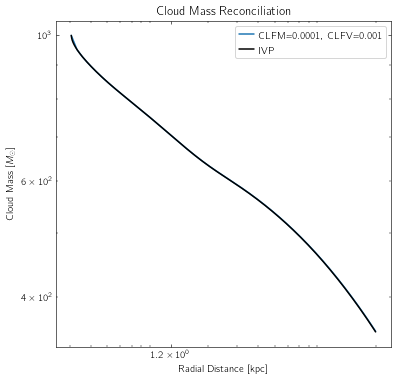

In [663]:
#rcl4 CLFM=0.0001, CLFV = 0.001
#rcl3 CLFM=0.0005, CLFV = 0.005
#rcl2 CLFM=0.001, CLFV = 0.01
#rcl1 CLFM=0.005, CLFV=0.05
#rcl0 CLFM=0.003, CLFV=0.03
#rcl5 CLFM=0.007, CLFV=0.07
#rcl6 CLFM=0.01, CLFV=0.1
#rcl7 CLFM=0.0003, CLFV = 0.003


Mcl4 = [item['M'][0] for item in res.clouds_info_MC]
vcl4 = [item['v'][0] for item in res.clouds_info_MC]
ncl4 = [item['n'][0] for item in res.clouds_info_MC]
Zcl4 = [item['Z'][0] for item in res.clouds_info_MC]
rcl4 = [item['r'] for item in res.clouds_info_MC]


#rcl = res.cloud_r
#Mcl = [item[0][0] for item in res.clouds_MC]
#vcl = [item[0][1] for item in res.clouds_MC]
#ncl = [item[0][2] for item in res.clouds_MC]
#Zcl = [item[0][3] for item in res.clouds_MC]

plt.figure(figsize=(6,6))

#plt.plot(np.array(rcl)/kpc, np.array(Mcl)/Msun, label='CLFM=0.0002, CLFV=0.002')
#plt.plot(np.array(rcl7)/kpc, np.array(Mcl7)/Msun, label='CLFM=0.0003, CLFV=0.003')
plt.plot(np.array(rcl4)/kpc, np.array(Mcl4)/Msun, label='CLFM=0.0001, CLFV=0.001')
#plt.plot(np.array(rcl3)/kpc, np.array(Mcl3)/Msun, label='CLFM=0.0005, CLFV=0.005')
#plt.plot(np.array(rcl2)/kpc, np.array(Mcl2)/Msun, label='CLFM=0.001, CLFV=0.01')
#plt.plot(np.array(rcl0)/kpc, np.array(Mcl0)/Msun, label='CLFM=0.003, CLFV=0.03')
#plt.plot(np.array(rcl1)/kpc, np.array(Mcl1)/Msun, label='CLFM=0.005, CLFV=0.05')
#plt.plot(np.array(rcl5)/kpc, np.array(Mcl5)/Msun, label='CLFM=0.007, CLFV=0.07')
#plt.plot(np.array(rcl6)/kpc, np.array(Mcl6)/Msun, label='CLFM=0.01, CLFV=0.1')
plt.plot(np.array(r_)/kpc, np.array(M_cloud)/Msun, label='IVP', color='black')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Cloud Mass $[M_\odot]$')
plt.title('Cloud Mass Reconciliation')
plt.yscale('log')
plt.xscale('log')
plt.xticks([1.2])

In [371]:
plt.figure(figsize=(6,6))
plt.plot(np.array(rcl4)/kpc, np.array(vcl4)/km, label='CLFM=0.0001, CLFV=0.001')
plt.plot(np.array(rcl2)/kpc, np.array(vcl2)/km, label='CLFM=0.001, CLFV=0.01')
plt.plot(np.array(rcl0)/kpc, np.array(vcl0)/km, label='CLFM=0.003, CLFV=0.03')
plt.plot(np.array(rcl1)/kpc, np.array(vcl1)/km, label='CLFM=0.005, CLFV=0.05')
plt.plot(np.array(rcl5)/kpc, np.array(vcl5)/km, label='CLFM=0.007, CLFV=0.07')
plt.plot(np.array(r_)/kpc, np.array(v_cloud)/km, label='IVP', color='black')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Cloud Velocity [km/s]')
plt.title('Cloud Velocity Reconciliation')
plt.yscale('log')
plt.xscale('log')


NameError: name 'rcl4' is not defined

<Figure size 432x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
#plt.plot(np.array(r_)/kpc, np.array(v_cloud)/km, label='IVP')
plt.plot(np.array(rcl4)/kpc, np.array(ncl4), label='CLFM=0.0001, CLFV=0.001')
plt.plot(np.array(rcl2)/kpc, np.array(ncl2), label='CLFM=0.001, CLFV=0.01')
plt.plot(np.array(rcl0)/kpc, np.array(ncl0), label='CLFM=0.003, CLFV=0.03')
plt.plot(np.array(rcl1)/kpc, np.array(ncl1), label='CLFM=0.005, CLFV=0.05')
plt.plot(np.array(rcl5)/kpc, np.array(ncl5), label='CLFM=0.007, CLFV=0.07')
plt.plot(np.array(rcl4)/kpc, np.array(ncl4), label='IVP', color ='black')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Cloud Number Density')
plt.title('Cloud Number Density Reconciliation')
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(np.array(rcl4)/kpc, np.array(Zcl4)/Z_solar, label='CLFM=0.0001, CLFV=0.001')
plt.plot(np.array(rcl2)/kpc, np.array(Zcl2)/Z_solar, label='CLFM=0.001, CLFV=0.01')
plt.plot(np.array(rcl1)/kpc, np.array(Zcl1)/Z_solar, label='CLFM=0.005, CLFV=0.05')
plt.plot(np.array(rcl0)/kpc, np.array(Zcl0)/Z_solar, label='CLFM=0.003, CLFV=0.03')
plt.plot(np.array(rcl5)/kpc, np.array(Zcl5)/Z_solar, label='CLFM=0.007, CLFV=0.07')
plt.plot(np.array(r_)/kpc, np.array(Z_cloud)/Z_solar, label = 'IVP', color = 'black')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Cloud Metallicity $[Z_\odot]$')
plt.title('Cloud Metallicity Reconciliation')
plt.yscale('log')
plt.xscale('log')

In [ ]:
R=pm['SONIC_POINT']
u_star = v_/(pm['MDOT']**-0.5 * pm['EDOT']**0.5)
rho_star = rho_/(pm['MDOT']**1.5 * pm['EDOT']**-0.5 * R**-2)
P_star = P_/(pm['MDOT']**0.5 * pm['EDOT']**0.5 * R**-2)
plt.figure(figsize=(6,6))
plt.plot(np.log(r_/R),np.log(u_star), label='Nomalized velocity')
plt.plot(np.log(r_/R),np.log(rho_star), label = 'Normalized density')
plt.plot(np.log(r_/R),np.log(P_star), label = 'Normalized pressure')
plt.legend()
plt.title('Numerical Solutions for Hot Wind')


In [ ]:
pre_wind = res.pre_wind_info
pre_wind_r = Utils.ntuple2array(res.pre_wind_info)[0]
pre_wind_v = Utils.ntuple2array(res.pre_wind_info)[1]
pre_wind_rhowind = Utils.ntuple2array(res.pre_wind_info)[2]
pre_wind_P = Utils.ntuple2array(res.pre_wind_info)[3]
pre_wind_rhoZ = Utils.ntuple2array(res.pre_wind_info)[4]

#rwind6=Utils.ntuple2array(res.post_wind_info)[0]
#vwind6=Utils.ntuple2array(res.post_wind_info)[1]
#rhowind6=Utils.ntuple2array(res.post_wind_info)[2]
#Pwind6=Utils.ntuple2array(res.post_wind_info)[3]
#rhozwind6=Utils.ntuple2array(res.post_wind_info)[4]
plt.figure(figsize=(6,6))
plt.plot(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_v,vwind5]/km, label='CLFM=0.007, CLFV=0.07')
plt.plot(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_v,vwind4]/km, label='CLFM=0.0001, CLFV=0.001')
plt.plot(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_v,vwind1]/km, label='CLFM=0.005, CLFV=0.05')
plt.plot(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_v,vwind2]/km, label='CLFM=0.001, CLFV=0.01')
plt.plot(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_v,vwind0]/km, label='CLFM=0.003, CLFV=0.03')
plt.plot(np.array(r)/kpc, np.array(v)/km, label = 'IVP', color = 'red')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Wind Velocity [km/s]')
plt.title('Wind Velocity Reconciliation')
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_rhowind,rhowind5], label='CLFM=0.007, CLFV=0.07')
plt.plot(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_rhowind,rhowind4], label='CLFM=0.0001, CLFV=0.001')
plt.plot(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_rhowind,rhowind1], label='CLFM=0.005, CLFV=0.05')
plt.plot(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_rhowind,rhowind2], label='CLFM=0.001, CLFV=0.01')
plt.plot(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_rhowind,rhowind0], label='CLFM=0.003, CLFV=0.03')
plt.plot(np.array(r)/kpc, np.array(rho), label = 'IVP')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Wind Density [g/cm$^3$]')
plt.title('Wind Density Reconciliation')
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_P,Pwind5], label='CLFM=0.007, CLFV=0.07')
plt.plot(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_P,Pwind4], label='CLFM=0.0001, CLFV=0.001')
plt.plot(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_P,Pwind1], label='CLFM=0.005, CLFV=0.05')
plt.plot(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_P,Pwind2], label='CLFM=0.001, CLFV=0.01')
plt.plot(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_P,Pwind0], label='CLFM=0.003, CLFV=0.03')
plt.plot(np.array(r)/kpc, np.array(P), label = 'IVP')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Wind Pressure [Pa]')
plt.title('Wind Pressure Reconciliation')
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_rhoZ,rhozwind5], label='CLFM=0.007, CLFV=0.07')
plt.plot(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_rhoZ,rhozwind4], label='CLFM=0.0001, CLFV=0.001')
plt.plot(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_rhoZ,rhozwind1], label='CLFM=0.005, CLFV=0.05')
plt.plot(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_rhoZ,rhozwind2], label='CLFM=0.001, CLFV=0.01')
plt.plot(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_rhoZ,rhozwind0], label='CLFM=0.003, CLFV=0.03')
plt.plot(np.array(r)/kpc, np.array(rhoZ), label = 'IVP')
plt.legend()
plt.xlabel('Radial Distance [kpc]')
plt.ylabel('Wind Metal Density [g/cm$^3$]')
plt.title('Wind Metal Density Reconciliation')
plt.yscale('log')
plt.xscale('log')

NameError: name 'pre_wind_r' is not defined

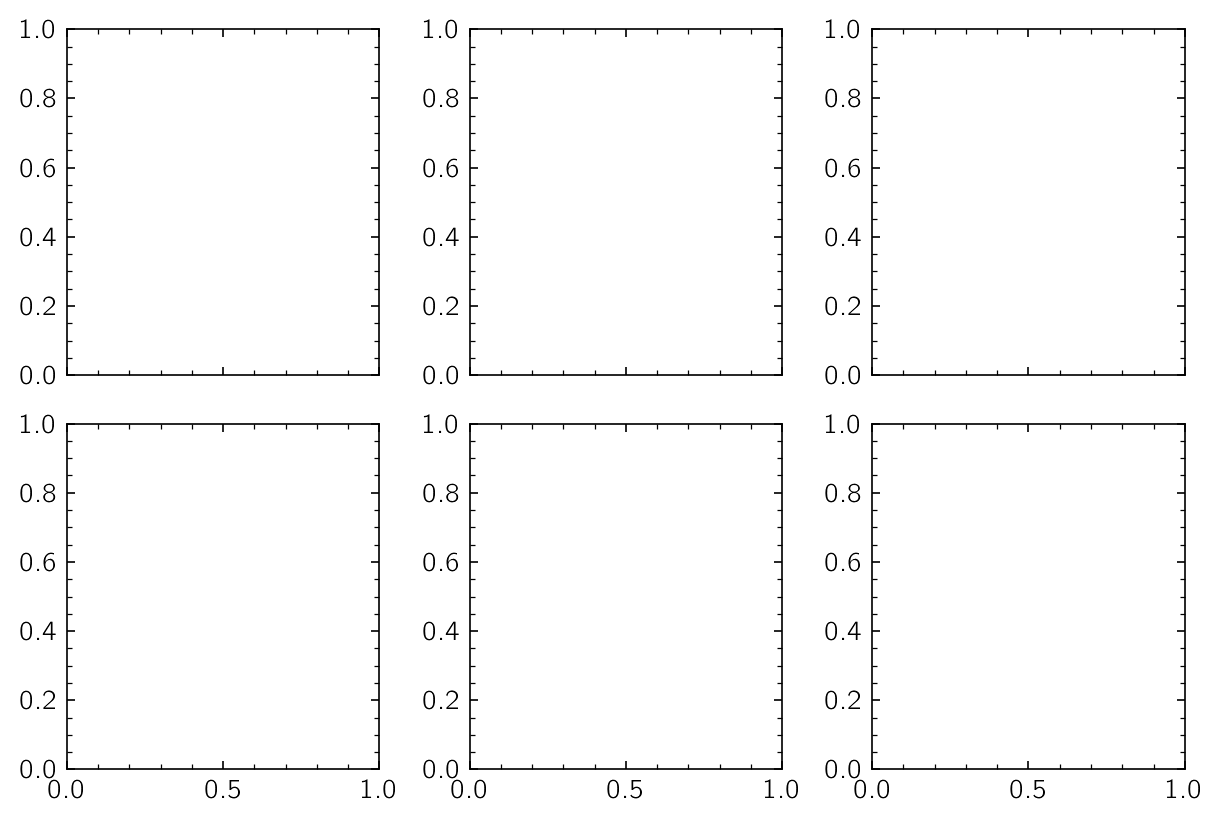

In [1255]:
from matplotlib.lines import Line2D
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4
matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams["figure.dpi"] = 200

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

#fig,((axv,axP,axd,axdz),(axM,axu,axn,axz)) = plt.subplots(2,4,sharex=True,constrained_layout=True)
fig,((axv,axP,axd),(axM,axu,axz)) = plt.subplots(2,3,sharex=True,constrained_layout=True)

mid_linestyle = ':'
high_linestyle = '--'
low_linestyle = '-.'
rk4_linestyle = '-'
vhigh_linestyle = (0, (3, 1, 1, 1, 1, 1))
mid_color = 'blue'
high_color = 'green'
low_color = 'gray'
rk4_color = 'red'
vhigh_color = 'orange'



axv.loglog(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_v,vwind4]/km, 
           label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
axv.loglog(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_v,vwind1]/km, 
           label='CLFM=0.005, CLFV=0.05', ls = mid_linestyle, color = mid_color)
axv.loglog(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_v,vwind5]/km, 
           label='CLFM=0.007, CLFV=0.07', ls = high_linestyle, color = high_color)
axv.loglog(np.r_[pre_wind_r,rwind6]/kpc, np.r_[pre_wind_v,vwind6]/km, 
           label='CLFM=0.01, CLFV=0.1', ls = vhigh_linestyle, color = vhigh_color)
#axv.loglog(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_v,vwind2]/km, label='CLFM=0.001, CLFV=0.01')
#axv.loglog(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_v,vwind0]/km, label='CLFM=0.003, CLFV=0.03')
axv.loglog(np.array(r)/kpc, np.array(v)/km, 
           label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)

axd.loglog(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_rhowind,rhowind4]/(const.mu*const.mp), 
           label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
axd.loglog(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_rhowind,rhowind1]/(const.mu*const.mp), 
           label='CLFM=0.005, CLFV=0.05', ls = mid_linestyle, color = mid_color)
axd.loglog(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_rhowind,rhowind5]/(const.mu*const.mp), 
           label='CLFM=0.007, CLFV=0.07', ls = high_linestyle, color = high_color)
axd.loglog(np.r_[pre_wind_r,rwind6]/kpc, np.r_[pre_wind_rhowind,rhowind6]/(const.mu*const.mp), 
           label='CLFM=0.01, CLFV=0.1', ls = vhigh_linestyle, color = vhigh_color)
#axd.loglog(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_rhowind,rhowind2], label='CLFM=0.001, CLFV=0.01')
#axd.loglog(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_rhowind,rhowind0], label='CLFM=0.003, CLFV=0.03')
axd.loglog(np.array(r)/kpc, np.array(rho)/(const.mu*const.mp), label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)


axP.loglog(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_P,Pwind4]/const.kb, 
           label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
axP.loglog(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_P,Pwind1]/const.kb, 
           label='CLFM=0.005, CLFV=0.05', ls = mid_linestyle, color = mid_color)
axP.loglog(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_P,Pwind5]/const.kb, 
           label='CLFM=0.007, CLFV=0.07', ls = high_linestyle, color = high_color)
axP.loglog(np.r_[pre_wind_r,rwind6]/kpc, np.r_[pre_wind_P,Pwind6]/const.kb, 
           label='CLFM=0.01, CLFV=0.1', ls = vhigh_linestyle, color = vhigh_color)
#axP.loglog(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_P,Pwind2], label='CLFM=0.001, CLFV=0.01')
#axP.loglog(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_P,Pwind0], label='CLFM=0.003, CLFV=0.03')
axP.loglog(np.array(r)/kpc, np.array(P)/const.kb, label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)

axdz.loglog(np.r_[pre_wind_r,rwind4]/kpc, np.r_[pre_wind_rhoZ,rhozwind4], 
            label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
axdz.loglog(np.r_[pre_wind_r,rwind1]/kpc, np.r_[pre_wind_rhoZ,rhozwind1], 
            label='CLFM=0.005, CLFV=0.05', ls = mid_linestyle, color = mid_color)
axdz.loglog(np.r_[pre_wind_r,rwind5]/kpc, np.r_[pre_wind_rhoZ,rhozwind5], 
            label='CLFM=0.007, CLFV=0.07', ls = high_linestyle, color = high_color)
axdz.loglog(np.r_[pre_wind_r,rwind6]/kpc, np.r_[pre_wind_rhoZ,rhozwind6], 
            label='CLFM=0.01, CLFV=0.1', ls = vhigh_linestyle, color = vhigh_color)
#axdz.loglog(np.r_[pre_wind_r,rwind2]/kpc, np.r_[pre_wind_rhoZ,rhozwind2], label='CLFM=0.001, CLFV=0.01')
#axdz.loglog(np.r_[pre_wind_r,rwind0]/kpc, np.r_[pre_wind_rhoZ,rhozwind0], label='CLFM=0.003, CLFV=0.03')
axdz.loglog(np.array(r)/kpc, np.array(rhoZ), label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)

axM.loglog(np.array(rcl4)/kpc, np.array(Mcl4)/Msun, 
           label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
#axM.loglog(np.array(rcl2)/kpc, np.array(Mcl2)/Msun, label='CLFM=0.001, CLFV=0.01')
#axM.loglog(np.array(rcl0)/kpc, np.array(Mcl0)/Msun, label='CLFM=0.003, CLFV=0.03')
axM.loglog(np.array(rcl1)/kpc, np.array(Mcl1)/Msun, 
           label='CLFM=0.005, CLFV=0.05', ls = mid_linestyle, color = mid_color)
axM.loglog(np.array(rcl5)/kpc, np.array(Mcl5)/Msun, 
           label='CLFM=0.007, CLFV=0.07', ls = high_linestyle, color = high_color)
axM.loglog(np.array(rcl6)/kpc, np.array(Mcl6)/Msun, 
           label='CLFM=0.01, CLFV=0.1', ls = vhigh_linestyle, color = vhigh_color)
axM.loglog(np.array(r_)/kpc, np.array(M_cloud)/Msun, label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)

axu.loglog(np.array(rcl4)/kpc, np.array(vcl4)/km, 
           label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
#axu.loglog(np.array(rcl2)/kpc, np.array(vcl2)/km, label='CLFM=0.001, CLFV=0.01')
#axu.loglog(np.array(rcl0)/kpc, np.array(vcl0)/km, label='CLFM=0.003, CLFV=0.03')
axu.loglog(np.array(rcl1)/kpc, np.array(vcl1)/km, 
           label='CLFM=0.005, CLFV=0.05', ls = mid_linestyle, color = mid_color)
axu.loglog(np.array(rcl5)/kpc, np.array(vcl5)/km, 
           label='CLFM=0.007, CLFV=0.07', ls = high_linestyle, color = high_color)
axu.loglog(np.array(rcl6)/kpc, np.array(vcl6)/km, 
           label='CLFM=0.01, CLFV=0.1', ls = vhigh_linestyle, color = vhigh_color)
axu.loglog(np.array(r_)/kpc, np.array(v_cloud)/km, label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)

axn.loglog(np.array(rcl4)/kpc, np.array(ncl4), 
           label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
#axn.loglog(np.array(rcl2)/kpc, np.array(ncl2), label='CLFM=0.001, CLFV=0.01')
#axn.loglog(np.array(rcl0)/kpc, np.array(ncl0), label='CLFM=0.003, CLFV=0.03')
axn.loglog(np.array(rcl1)/kpc, np.array(ncl1), 
           label='CLFM=0.005, CLFV=0.05', ls = high_linestyle, color = high_color)
axn.loglog(np.array(rcl5)/kpc, np.array(ncl5), 
           label='CLFM=0.007, CLFV=0.07', ls = mid_linestyle, color = mid_color)
axn.loglog(np.array(rcl4)/kpc, np.array(ncl4), label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)


axz.loglog(np.array(rcl4)/kpc, np.array(Zcl4)/Z_solar, 
           label='CLFM=0.0001, CLFV=0.001', ls = low_linestyle, color = low_color)
#axz.loglog(np.array(rcl2)/kpc, np.array(Zcl2)/Z_solar, label='CLFM=0.001, CLFV=0.01')
axz.loglog(np.array(rcl1)/kpc, np.array(Zcl1)/Z_solar, 
           label='CLFM=0.005, CLFV=0.05', ls = mid_linestyle, color = mid_color)
#axz.loglog(np.array(rcl0)/kpc, np.array(Zcl0)/Z_solar, label='CLFM=0.003, CLFV=0.03')
axz.loglog(np.array(rcl5)/kpc, np.array(Zcl5)/Z_solar, 
           label='CLFM=0.007, CLFV=0.07', ls = high_linestyle, color = high_color)
axz.loglog(np.array(rcl6)/kpc, np.array(Zcl6)/Z_solar, 
           label='CLFM=0.01, CLFV=0.1', ls = vhigh_linestyle, color = vhigh_color)
axz.loglog(np.array(r_)/kpc, np.array(Z_cloud)/Z_solar, label = 'Runge-Kutta', ls = rk4_linestyle, color = rk4_color)


custom_lines = [Line2D([0], [0], color='k', ls = low_linestyle),
                Line2D([0], [0], color='k', ls = mid_linestyle),
                Line2D([0], [0], color='k', ls = high_linestyle),
                Line2D([0], [0], color='k', ls = vhigh_linestyle),
                Line2D([0], [0], color='k', ls = rk4_linestyle),]

fig.legend(custom_lines, [r'$\beta_M=0.0001$, $\beta_v=0.001$', 
                          r'$\beta_M=0.005$, $\beta_v=0.005$',
                          r'$\beta_M=0.00$7, $\beta_v=0.007$', 
                          r'$\beta_M=0.01$, $\beta_v=0.01$', 
                          r'Runge-Kutta 4th order'],fontsize=7, 
           frameon=False, handlelength=2.2, labelspacing=0.5, 
           bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3,
           fancybox=False, shadow=False)

from matplotlib import ticker
axv.set_ylabel(r'$v \; [{\rm km/s}]$')
axd.set_ylabel(r'$n \; [{\rm cm}^{-3}]$')
axP.set_ylabel(r'$P \; [{\rm K cm}^{-3}]$')
axz.set_ylabel(r'$Z_{\rm cl} \; [Z_\odot]$')
axM.set_ylabel(r'$M_{\rm cl} \; [M_\odot]$')
axu.set_ylabel(r'$v_{\rm cl} \; [{\rm km/s}]$')
axM.set_xlabel(r'$r\; [{\rm kpc}]$')
axu.set_xlabel(r'$r\; [{\rm kpc}]$')
axz.set_xlabel(r'$r\; [{\rm kpc}]$')



def major_formatter(x, pos):
    return "%.0f" % x
def minor_formatter(x, pos):
    return "[%.2f]" % x
#axv.xaxis.set_major_formatter(ticker.NullFormatter())
axv.yaxis.set_major_formatter(ticker.NullFormatter())
axv.yaxis.set_minor_formatter(ticker.NullFormatter())
axM.yaxis.set_major_formatter(ticker.NullFormatter())
axM.yaxis.set_minor_formatter(ticker.NullFormatter())
axz.yaxis.set_major_formatter(ticker.NullFormatter())
axz.yaxis.set_minor_formatter(ticker.NullFormatter())

axv.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.0f" % x))
axv.set_yticks([200,700,2000])
axM.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.0f" % x))
axM.set_yticks([500,700,1000])
axz.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.2f" % x))
axz.set_yticks([1,1.15,1.3])

axM.xaxis.set_major_formatter(ticker.NullFormatter())
axM.xaxis.set_minor_formatter(ticker.NullFormatter())
axM.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.0f" % x))
axM.set_xticks([1,20])

#plt.savefig('Convergence_Test_v', bbox_inches='tight')
#plt.clf()


In [1596]:
def plot_cloud(rlist, cnormal, cmap, save):
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.top'] = True
    matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams['xtick.minor.visible'] = True
    matplotlib.rcParams['ytick.minor.visible'] = True
    matplotlib.rcParams['lines.dash_capstyle'] = "round"
    matplotlib.rcParams['lines.solid_capstyle'] = "round"
    matplotlib.rcParams['legend.handletextpad'] = 0.4
    matplotlib.rcParams['axes.linewidth'] = 0.6
    matplotlib.rcParams['ytick.major.width'] = 0.6
    matplotlib.rcParams['xtick.major.width'] = 0.6
    matplotlib.rcParams['ytick.minor.width'] = 0.45
    matplotlib.rcParams['xtick.minor.width'] = 0.45
    matplotlib.rcParams['ytick.major.size'] = 2.75
    matplotlib.rcParams['xtick.major.size'] = 2.75
    matplotlib.rcParams['ytick.minor.size'] = 1.75
    matplotlib.rcParams['xtick.minor.size'] = 1.75
    matplotlib.rcParams['legend.handlelength'] = 2
    matplotlib.rcParams["figure.dpi"] = 200
    if cnormal == 1:
        colormap_n = colors.Normalize()
    else:
        colormap_n = colors.LogNorm()
    if cmap == 1:
        colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
    else:
        colormap_r = palettable.scientific.sequential.Oslo_20_r.mpl_colormap

    cloud_info = res.clouds_info_MC
    r = np.array([item['r']+0 for item in cloud_info])
    i1 = min(np.where(r>=(rlist[0]*pc))[0])
    i2 = min(np.where(r>=(rlist[1]*pc))[0])
    i3 = min(np.where(r>=(rlist[2]*pc))[0])
    i4 = min(np.where(r>=(rlist[3]*pc))[0])
    i5 = min(np.where(r>=(rlist[4]*pc))[0])
    i6 = min(np.where(r>=(rlist[5]*pc))[0])
#    fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,sharex=True, sharey=True,constrained_layout=True)
    fig,axes = plt.subplots(2,3,sharex=True, sharey=True,constrained_layout=True)

    def getMassFlux(i):
        f,Mbins,vbins = Utils.binnings_MC(i, res, mp)
        mass = 4 * np.pi * cloud_info[i]['r']**2 * f * Mbins
        massFlux = (mass.T * vbins).T
        return massFlux

    massFlux1 = getMassFlux(i1)
    axes[0][0].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux1, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux2 = getMassFlux(i2)
    axes[0][1].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux2, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux3 = getMassFlux(i3)
    axes[0][2].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux3, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux4 = getMassFlux(i4)
    axes[1][0].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux4, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux5 = getMassFlux(i5)
    axes[1][1].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux5, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux6 = getMassFlux(i6)
    im=axes[1][2].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux6, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    plt.xscale('log')
    fig.text(0.45, -0.04, 'cloud mass [M$_\odot$]', ha='center')
    fig.text(-0.04, 0.5, 'cloud velocity [km/s]', va='center', rotation='vertical')
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), location="right", shrink=0.7)
    label = ' Mass flux [kg km s$^{-1}$ cm$^2$]'
    cb.set_label(label,size='small') ### PUT YOUR LABEL HERE
    cb.ax.tick_params(labelsize='small')
    cb.ax.minorticks_off()
    plt.setp(axes, xticks=[1, 1e3, 1e6])
    axes[0][0].annotate('r=' + str(rlist[0]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[0][1].annotate('r=' + str(rlist[1]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[0][2].annotate('r=' + str(rlist[2]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[1][0].annotate('r=' + str(rlist[3]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[1][1].annotate('r=' + str(rlist[4]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[1][2].annotate('r=' + str(rlist[5]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    if save == 1:
        plt.savefig('Cloud_evolution', bbox_inches='tight')
        plt.clf()
    return

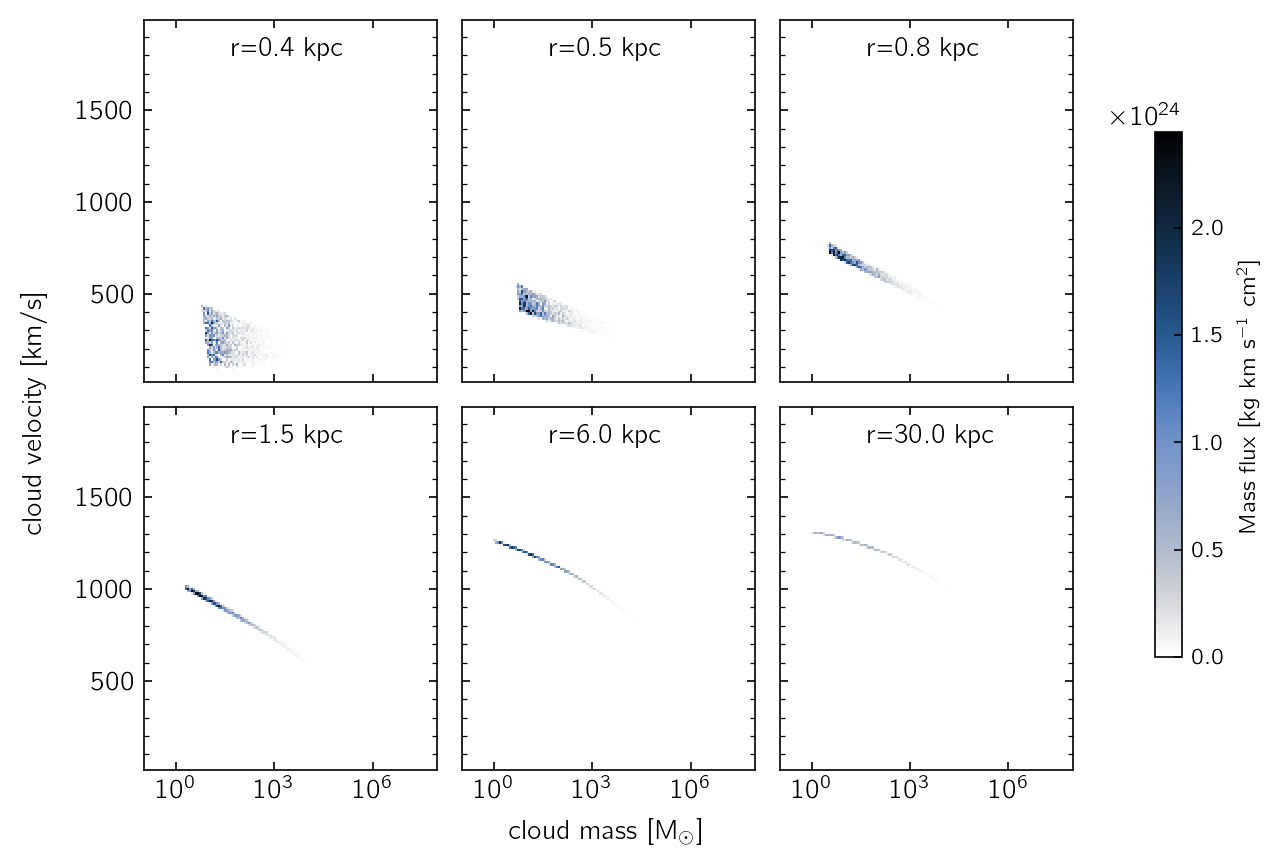

In [1597]:
rlist = [400, 500, 800, 1500,6000,30000]
plot_cloud(rlist, 1, 0, save=0)

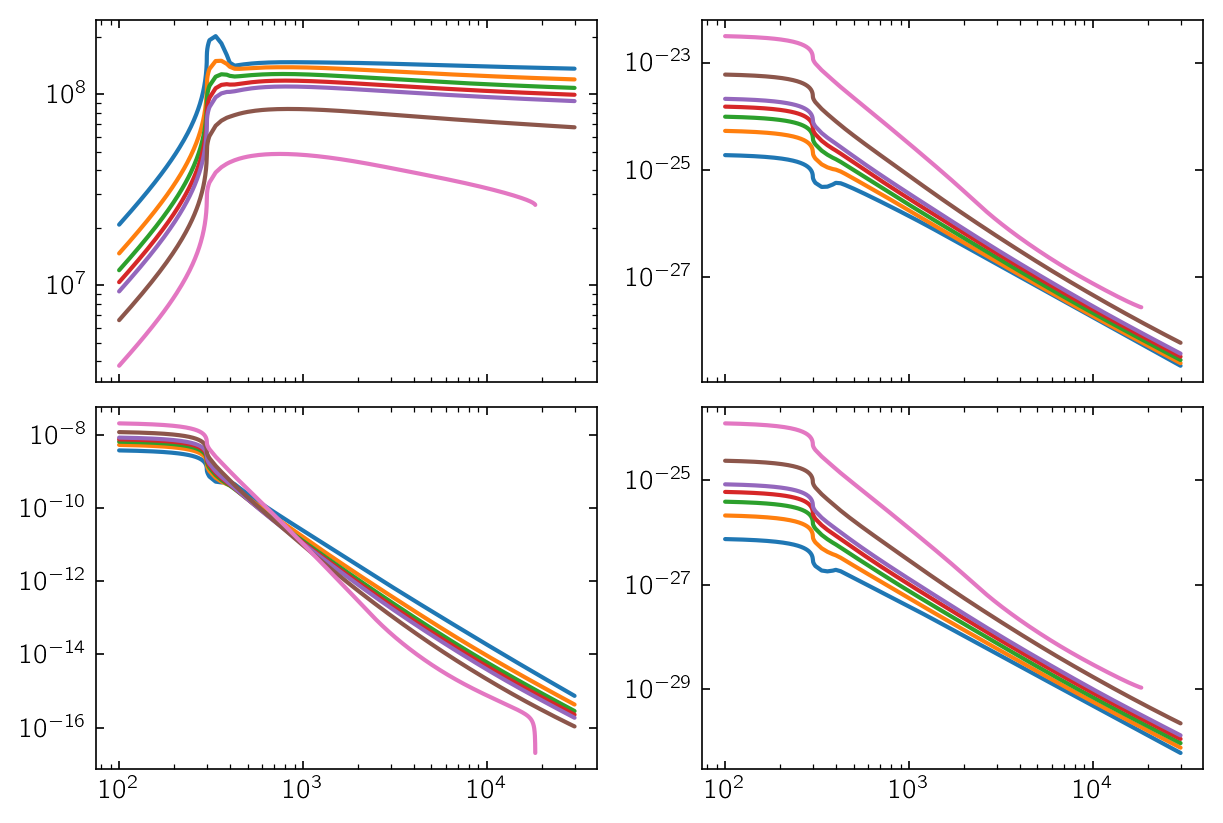

In [3061]:
data = [res1,res2,res3,res4,res5, res10, res30]

def plot_wind(data):
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.top'] = True
    matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams['xtick.minor.visible'] = True
    matplotlib.rcParams['ytick.minor.visible'] = True
    matplotlib.rcParams['lines.dash_capstyle'] = "round"
    matplotlib.rcParams['lines.solid_capstyle'] = "round"
    matplotlib.rcParams['legend.handletextpad'] = 0.4
    matplotlib.rcParams['axes.linewidth'] = 0.6
    matplotlib.rcParams['ytick.major.width'] = 0.6
    matplotlib.rcParams['xtick.major.width'] = 0.6
    matplotlib.rcParams['ytick.minor.width'] = 0.45
    matplotlib.rcParams['xtick.minor.width'] = 0.45
    matplotlib.rcParams['ytick.major.size'] = 2.75
    matplotlib.rcParams['xtick.major.size'] = 2.75
    matplotlib.rcParams['ytick.minor.size'] = 1.75
    matplotlib.rcParams['xtick.minor.size'] = 1.75
    matplotlib.rcParams['legend.handlelength'] = 2
    matplotlib.rcParams["figure.dpi"] = 200

    _r = [item[0] for item in res.pre_wind_info]
    r_ = [item[0] for item in res.post_wind_info]
    r = np.r_[_r,r_]/const.pc


    def v_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.pc
        _v = [item[1] for item in res.pre_wind_info]
        v_ = [item[1] for item in res.post_wind_info]
        v = np.r_[_v,v_]
        ax.loglog(r,v)
        return ax, plot

    def rho_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.pc
        _rho = [item[2] for item in res.pre_wind_info]
        rho_ = [item[2] for item in res.post_wind_info]
        rho = np.r_[_rho,rho_]
        ax.loglog(r,rho)
        return ax, plot

    def P_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.pc
        _P = [item[3] for item in res.pre_wind_info]
        P_ = [item[3] for item in res.post_wind_info]
        P = np.r_[_P,P_]
        ax.loglog(r,P)
        return ax, plot

    def rhoZ_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.pc
        _rhoZ = [item[4] for item in res.pre_wind_info]
        rhoZ_ = [item[4] for item in res.post_wind_info]
        rhoZ = np.r_[_rhoZ,rhoZ_]
        ax.loglog(r,rhoZ)
        return ax


    fig,axes = plt.subplots(2,2,sharex=True,constrained_layout=True)
    for item in data:
        ax1 = v_plot(r, item, axes[0][0])
        ax2 = rho_plot(r, item, axes[0][1])
        ax3 = P_plot(r, item, axes[1][0])
        ax4 = rhoZ_plot(r, item, axes[1][1])
    return

plot_wind(data)


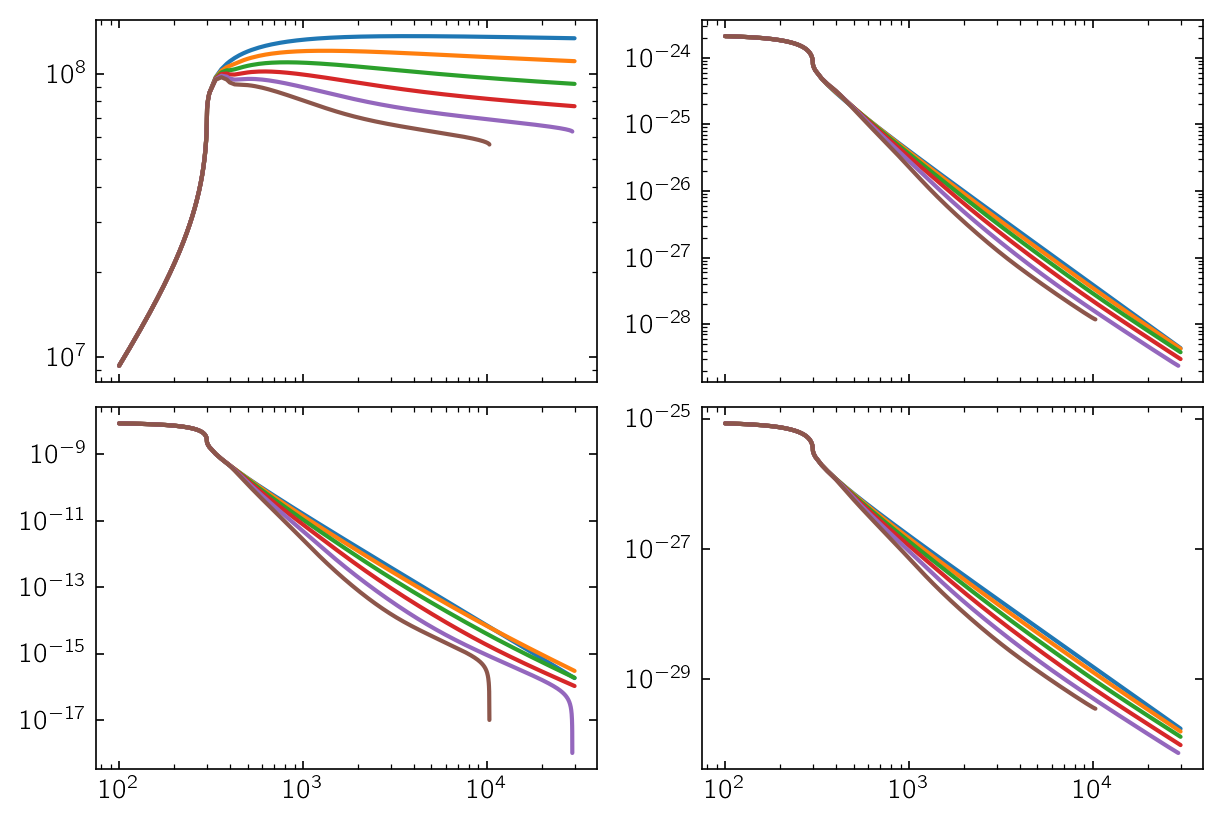

In [3024]:
plot_wind([res_a0, res_a01, res_a02, res_a03, res_a04, res_a05])

In [2587]:
rho_dot = [item['rho'] for item in res.wind_dot_info]
p_dot = [item['p'] for item in res.wind_dot_info]
e_dot = [item['e'] for item in res.wind_dot_info]
rhoZ_dot = [item['rhoZ'] for item in res.wind_dot_info]
r = [item['r']/pc for item in res.wind_dot_info]

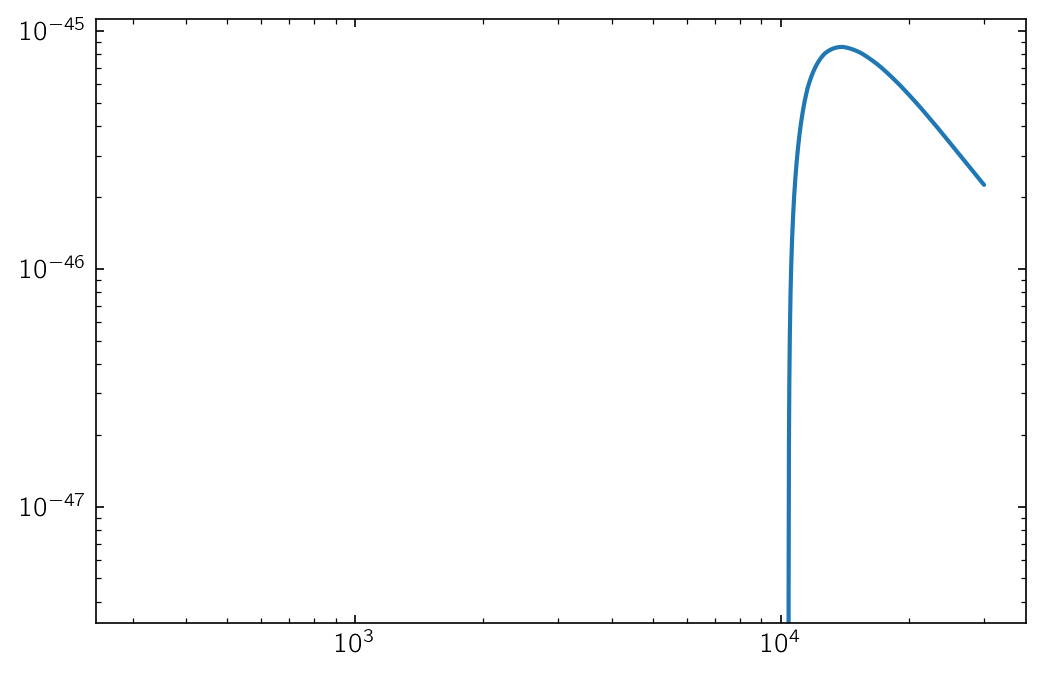

In [2588]:
plt.loglog(r, rhoZ_dot)

In [2094]:
def plot_mass_MC(self, i_arr,cloud, log, x1_info, x2_info, x3_info):
(x1_start,x1_end,x1_scale,x1_slope, x1_plot) = x1_info
(x2_start,x2_end,x2_scale,x2_slope, x2_plot) = x2_info
(x3_start,x3_end,x3_scale,x3_slope, x3_plot) = x3_info
plt.figure(figsize=(6,6))
for i in i_arr:
    f, Mbins, vbins = Utils.binnings_MC(i, self, mp)
    mass = sum(f)
    legend = 'Mass distribution at ' + str(int(res.clouds_info_MC[i]['r'] / const.pc)) + ' pc'
    plt.plot(Mbins/const.Msun, mass, label = legend)
plt.xscale('log')
if log == True: plt.yscale('log')
if x1_plot:
    x1=10**np.arange(x1_start,x1_end,0.1)
    y1=10**(x1_scale)*x1**x1_slope
    legend1 = 'Power index = ' + str(x1_slope)
    plt.plot(x1,y1, label = legend1, lw=3)
if x2_plot:
    x2=10**np.arange(x2_start,x2_end,0.1)
    y2=10**(x2_scale)*x2**x2_slope
    legend2 = 'Power index = ' + str(x2_slope)
    plt.plot(x2,y2, label = legend2, lw=3)
if x3_plot:
    x3=10**np.arange(x3_start,x3_end,0.1)
    y3=10**(x3_scale)*x3**x3_slope
    legend3 = 'Power index = ' + str(x3_slope)
    plt.plot(x3,y3, label = legend3, lw=3)
plt.title('Marginal Distribution of Cloud Mass')
plt.xlabel('Mass $[M_\odot]$')
plt.ylabel('Number density [m$^{-3}$]')
plt.legend()        


IndentationError: expected an indented block (<ipython-input-2094-0e0e50a73236>, line 2)

In [2509]:
f, Mbins, vbins = Utils.binnings_MC(steps, res, mp)
mass = sum(f)
plt.loglog(Mbins/const.Msun, mass)


IndexError: list index out of range

In [1705]:
from sklearn.linear_model import LinearRegression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [1735]:
istart = min(np.where(Mbins >= (1 * const.Msun))[0])
iend = min(np.where(Mbins >= (1e6 * const.Msun))[0])

In [3035]:
#i1=4
#i2=steps
line1 = [1,7,1]
line2 = [0,2,1]
line3 = [3,7,1]
show_fit = True
v_mrng = [1,1.1]
save = 0
rlist = [400, 30000]

def plot_distributions(rlist, line1, line2, line3, show_fit, save):
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.top'] = True
    matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams['xtick.minor.visible'] = True
    matplotlib.rcParams['ytick.minor.visible'] = True
    matplotlib.rcParams['lines.dash_capstyle'] = "round"
    matplotlib.rcParams['lines.solid_capstyle'] = "round"
    matplotlib.rcParams['legend.handletextpad'] = 0.4
    matplotlib.rcParams['axes.linewidth'] = 0.6
    matplotlib.rcParams['ytick.major.width'] = 0.6
    matplotlib.rcParams['xtick.major.width'] = 0.6
    matplotlib.rcParams['ytick.minor.width'] = 0.45
    matplotlib.rcParams['xtick.minor.width'] = 0.45
    matplotlib.rcParams['ytick.major.size'] = 2.75
    matplotlib.rcParams['xtick.major.size'] = 2.75
    matplotlib.rcParams['ytick.minor.size'] = 1.75
    matplotlib.rcParams['xtick.minor.size'] = 1.75
    matplotlib.rcParams['legend.handlelength'] = 2
    matplotlib.rcParams["figure.dpi"] = 200


    cloud_info = res.clouds_info_MC

    fig,axes = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))


    r = np.array([item['r']+0 for item in cloud_info])
    i1 = min(np.where(r>=(rlist[0]*pc))[0])
    i2 = min(np.where(r>=(rlist[1]*pc))[0])

    f1, Mbins1, vbins1 = Utils.binnings_MC(i1, res, mp)
    mass1 = sum(f1)
    legend1 = 'Mass distribution at ' + str(int(cloud_info[i1]['r'] / const.pc)) + ' pc'
    axes[0].loglog(Mbins1/const.Msun, mass1, label = legend1)
    f2, Mbins2, vbins2 = Utils.binnings_MC(steps, res, mp)
    mass2 = sum(f2)
    legend2 = 'Mass distribution at ' + str(int(cloud_info[i2]['r'] / const.pc)) + ' pc'
    axes[0].loglog(Mbins2/const.Msun, mass2, label = legend2)


    mstart = min(np.where(Mbins >= (10**v_mrng[0] * const.Msun))[0])
    mend = min(np.where(Mbins >= (10**v_mrng[1] * const.Msun))[0])

    f3 = f1[:,[mstart, mend]]
    f3 = f1
    vel1 = sum(f3.T)
    legend6 = 'velocity distribution at ' + str(int(res.clouds_info_MC[i1]['r'] / const.pc)) + ' pc'
    axes[1].plot(vbins1/const.km, vel1/max(vel1), label = legend6)
    f4 = f2[:,[mstart, mend]]
    f4 = f2
    vel2 = sum(f4.T)
    legend7 = 'velocity distribution at ' + str(int(res.clouds_info_MC[i2]['r'] / const.pc)) + ' pc'
    axes[1].plot(vbins2/const.km, vel2/max(vel2), label = legend7)

    def getFit(line, Mbins, mass):
        istart = min(np.where(Mbins >= (10**line[0] * const.Msun))[0])
        iend = min(np.where(Mbins >= (10**line[1] * const.Msun))[0])
        x=np.log10(Mbins[istart:iend]).reshape((-1,1))
        y=np.log10(mass[istart:iend])
        model = LinearRegression()
        model.fit(x, y)
        b = model.intercept_ + line[2]
        slope = model.coef_[0]
        line_x =  Mbins[istart:iend]
        line_y = [10**(slope * np.log10(x) + b) for x in line_x]
        return line_x, line_y, slope

    if show_fit == True:
        x1, y1, slope1 = getFit(line1, Mbins1, mass1)
        legend3 = 'Power law index = {:2.2f}'.format(-slope1)
        axes[0].loglog(x1/const.Msun, y1, label = legend3)
        x2, y2, slope2 = getFit(line2, Mbins2, mass2)
        legend4 = 'Power law index = {:2.2f}'.format(-slope2)
        axes[0].loglog(x2/const.Msun, y2, label = legend4)
        x3, y3, slope3 = getFit(line3, Mbins2, mass2)
        legend5 = 'Power law index = {:2.2f}'.format(-slope3)
        axes[0].loglog(x3/const.Msun, y3, label = legend5)


    #axes[0].title('Marginal Distribution of Cloud Mass')
    axes[0].set_xlabel('Mass $[M_\odot]$')
    axes[0].set_ylabel('Number density [m$^{-3}$]')
    axes[0].legend(fontsize='small')
    axes[1].set_xlabel('Velocity [km/s]')
    axes[1].set_ylabel('Normalized Relative frequency')
    axes[1].legend(fontsize='small')
    #axes[0].set_ylim((10**(-75), 10**(-54)))
    axes[1].set_ylim((0,1.2))
    axes[1].set_yticks([0,0.5,1])

    if save == 1:
        plt.savefig('cloud_distributions', bbox_inches='tight')
        plt.clf()
    return

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


IndexError: list index out of range

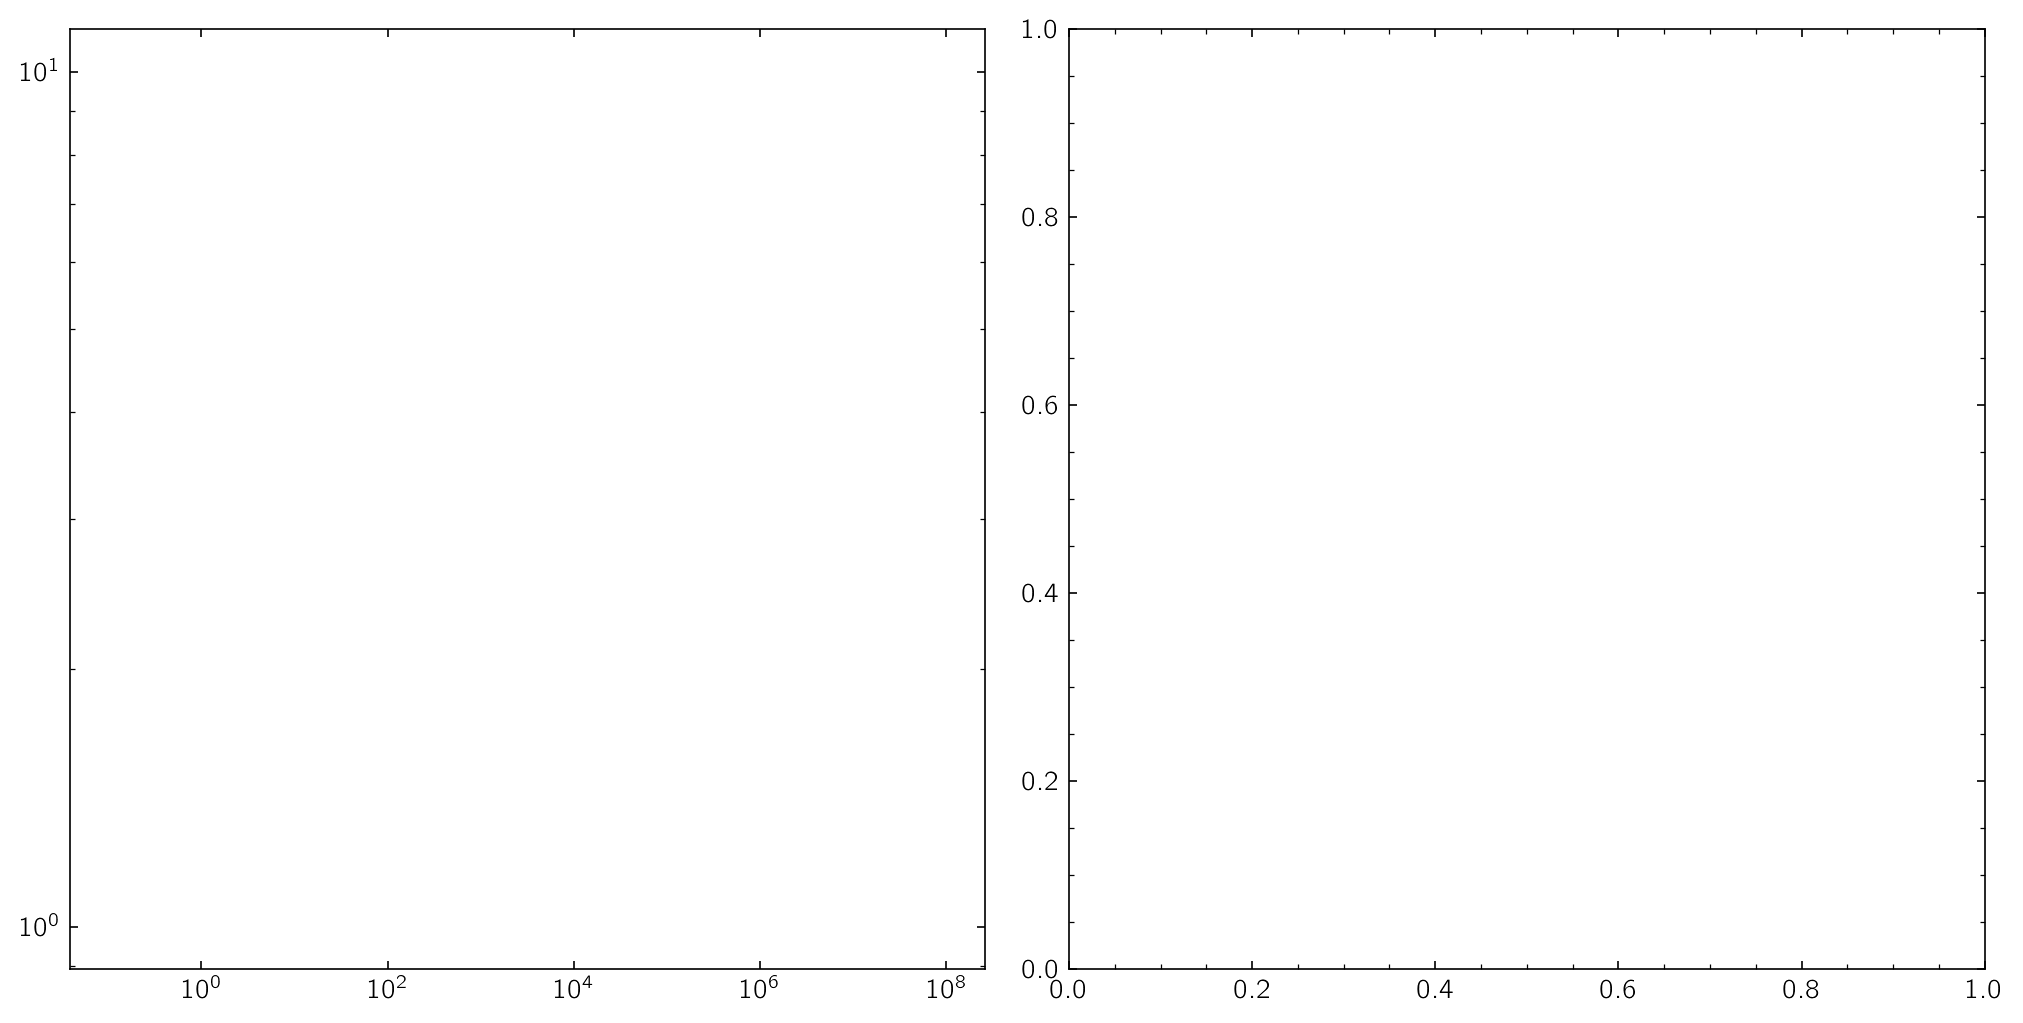

In [3039]:
plot_distributions(rlist=[400,30000], line1=[1,7,1], line2=[0,2,1], line3=[3,7,1], show_fit=False, save=0)

In [3032]:
def plot_contour(i, contour_scale, c_loc, barmax, barmin):
    windinfo = res.post_wind_info[i]

    Mmin = pm['M_MIN']
    Mmax = pm['M_MAX']
    Mcells = pm['M_CELLS']
    vmin = pm['V_MIN']
    vmax = pm['V_MAX']
    vcells = pm['V_CELLS']
    cool = Cooling(pm['COOL_FILE'],const)
    M_bins, mbndry, dm = Utils.genGrid(Mmin, Mmax, Mcells, True, const.Msun)
    v_bins, vbndry, dv = Utils.genGrid(vmin, vmax, vcells, False, const.km)
    M_cloud = np.tile(M_bins, vcells)
    v_cloud = np.repeat(v_bins, Mcells)
    wind = {}
    wind['v'] = windinfo[1]
    wind['rho']= windinfo[2]
    wind['P']= windinfo[3]
    wind['rhoZ']=windinfo[4]
    cloud = {}
    cloud['M'] = M_cloud
    cloud['v'] = v_cloud
    cloud['n'] = 1
    cloud['Z'] = 0.02
    _,_,_,_,ksi = Utils.dot_cloud_calc(wind, cloud, cool.tcool_P, pm)
#        f,_ , _ = Utils.binnings_MC2(i, res, M_bins, v_bins)
    f,_ , _ = Utils.binnings_MC(i, res, mp)

    r = windinfo[0]
    f_mass_rate = 4 * np.pi * r**2 * f * M_bins * const.pc / const.Msun

    fig,ax=plt.subplots(1,1,constrained_layout=True, figsize=(6,6))
    colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
    plot = plt.pcolormesh(M_bins/const.Msun, v_bins/const.km, f_mass_rate.reshape((vcells,Mcells)), 
        norm=colors.LogNorm(), #color limits
        vmax = barmax, 
        vmin = barmin,                          
        cmap=colormap_r) #color map
    cb = fig.colorbar(plot, ax=ax, location="right")
    label = 'Volumetric Mass [M$_\odot$] per parsec at {:2.2f} kpc'.format(r/const.kpc)
    cb.set_label(label) ### PUT YOUR LABEL HERE
#        cb.set_label(r'Volumetric Mass [M$_\odot$]') ### PUT YOUR LABEL HERE
    cb.ax.minorticks_off()
    sc=contour_scale
    levels = [1/sc**5, 1/sc**4, 1/sc**3,1/sc**2, 1/sc, 1, sc, sc**2 , sc**3, sc**4, sc**5]
    contour = ax.contourf(M_bins/const.Msun,v_bins/const.km, ksi.reshape((150,150)), 
                          levels = levels, cmap=cmr.iceburn, 
                          norm=colors.LogNorm(), 
                          #origin = origin, 
                          alpha=0.5, extend='both')
    cb = fig.colorbar(contour, ax=ax, location="top")
    cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
    cb.set_label(r'$\xi = \frac{r_{cl}}{v_{turb} \tau_{cool}}$')
    manual_loc = [(1e1,c_loc), (1e3,c_loc),(1e4,c_loc),(1e5,c_loc), (1e6,c_loc)]
    ax.clabel(contour, fmt='%2.2f', colors='black', fontsize=12, 
              inline_spacing=1,
              manual = manual_loc, 
              inline=0)
    ax.set_xscale('log')
    plt.title("Density of cloud mass vs cloud velocity")  
    return ax, cb


In [268]:
r_curr=400
ax = None
contour_scale=4
c_loc=100


matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4
matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams["figure.dpi"] = 200

def create_contour(r_curr, ax, contour_scale, c_loc):
    if ax is None:
        ax = plt.gca()

    Mcells = pm['M_CELLS']
    vcells = pm['V_CELLS']
    cool = Cooling(pm['COOL_FILE'],const)

    r = np.array([item['r']+0 for item in res.clouds_info_MC])
    i = min(np.where(r>=(r_curr*pc))[0])

    windinfo = res.post_wind_info[i]
    cloudinfo = res.clouds_info_MC[i]

    f,M_bins,v_bins = Utils.binnings_MC(i, res, mp)
    M_cloud = np.tile(M_bins, vcells)
    v_cloud = np.repeat(v_bins, Mcells)
    wind = {}
    wind['v'] = windinfo[1]
    wind['rho']= windinfo[2]
    wind['P']= windinfo[3]
    wind['rhoZ']=windinfo[4]
    cloud = {}
    cloud['M'] = M_cloud
    cloud['v'] = v_cloud
    cloud['n'] = 1
    cloud['Z'] = 0.02

    _,_,_,_,info = Utils.dot_cloud_calc(wind, cloud, cool.tcool_P, pm)

    r = windinfo[0]
#    f_mass = 4 * np.pi * r**2 * f * M_bins
    f_mass = f * M_bins

    f_mass_flux = (f_mass.T * v_bins).T

    colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
    plot = ax.pcolormesh(M_bins/const.Msun, v_bins/const.km, f_mass_flux, 
            norm=colors.LogNorm(), #color limits
    #        vmax = barmax, 
    #        vmin = barmin,                          
            cmap=colormap_r) #color map
#    cb = fig.colorbar(plot, ax=ax, location="right")
#    label = ' Mass flux [kg km s$^{-1}$ cm$^2$]'
#    cb.set_label(label) ### PUT YOUR LABEL HERE
#    cb.ax.minorticks_off()

    var = info['ksi']
#    print(info)
    sc=contour_scale
    levels = [1/sc**5, 1/sc**4, 1/sc**3,1/sc**2, 1/sc, 1, sc, sc**2 , sc**3, sc**4, sc**5]
    contour = ax.contourf(M_bins/const.Msun,v_bins/const.km, var.reshape((vcells,Mcells)), 
                          levels = levels, 
                          cmap=cmr.iceburn, 
                          norm=colors.LogNorm(), 
                          #origin = origin, 
                          alpha=0.5, extend='both')
#    cb = fig.colorbar(contour, ax=ax, location="top")
#    cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
#    cb.set_label(r'$\xi = \frac{r_{cl}}{v_{turb} \tau_{cool}}$')
    manual_loc = [(1e1,c_loc), (1e3,c_loc),(1e4,c_loc),(1e5,c_loc), (1e6,c_loc)]
    ax.clabel(contour, fmt='%2.2f', colors='black', fontsize=12, 
              inline_spacing=1,
              manual = manual_loc, 
              inline=0)
    ax.set_xscale('log')
    return ax, plot, contour

In [273]:
save=1

fig, axes = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(10,5))
ax1, plot1, contour1 = create_contour(r_curr=400, ax=axes[0], contour_scale=4, c_loc=500)
ax2, plot2, contour2 = create_contour(r_curr=30000, ax=axes[1], contour_scale=3.5, c_loc=300)
cb = fig.colorbar(plot2, ax=axes.ravel().tolist(), location="right", shrink=0.8)
label = r'$4\pi r^2 \frac{\partial n}{\partial \log M \cdot \partial v} \cdot M \cdot v$  [g $\cdot$ cm$^{-1}$]'
cb.set_label(label,size=15) ### PUT YOUR LABEL HERE
cb.ax.tick_params(labelsize='small')
cb.ax.minorticks_off()

ax1.set_ylim((0,1360))

cb = fig.colorbar(contour2, ax=axes.ravel().tolist(), location="top", shrink=1)
cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
cb.set_label(r'$\xi = \frac{r_{cl}}{v_{turb} \tau_{cool}}$', size =15)

fig.text(0.47, -0.04, 'cloud mass [M$_\odot$]', ha='center', size=15)
fig.text(-0.04, 0.45, 'cloud velocity [km/s]', va='center', rotation='vertical', size=15)

if save == 1:
    plt.savefig('ksi_contour', bbox_inches='tight')
    plt.clf()

<Figure size 2000x1000 with 0 Axes>

In [2697]:
f_mass_flux

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
data = [res_slope1]

def plot_wind(data, axes, const):
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.top'] = True
    matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams['xtick.minor.visible'] = True
    matplotlib.rcParams['ytick.minor.visible'] = True
    matplotlib.rcParams['lines.dash_capstyle'] = "round"
    matplotlib.rcParams['lines.solid_capstyle'] = "round"
    matplotlib.rcParams['legend.handletextpad'] = 0.4
    matplotlib.rcParams['axes.linewidth'] = 0.6
    matplotlib.rcParams['ytick.major.width'] = 0.6
    matplotlib.rcParams['xtick.major.width'] = 0.6
    matplotlib.rcParams['ytick.minor.width'] = 0.45
    matplotlib.rcParams['xtick.minor.width'] = 0.45
    matplotlib.rcParams['ytick.major.size'] = 2.75
    matplotlib.rcParams['xtick.major.size'] = 2.75
    matplotlib.rcParams['ytick.minor.size'] = 1.75
    matplotlib.rcParams['xtick.minor.size'] = 1.75
    matplotlib.rcParams['legend.handlelength'] = 2
    matplotlib.rcParams["figure.dpi"] = 200


    def v_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _v = [item[1] for item in res.pre_wind_info]
        v_ = [item[1] for item in res.post_wind_info]
        v = np.r_[_v,v_]
        ax.loglog(r,v/const.km)
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$v \; [{\rm km/s}]$')
        ax.set_title('Velocity')
        return ax, plot

    def rho_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _rho = [item[2] for item in res.pre_wind_info]
        rho_ = [item[2] for item in res.post_wind_info]
        rho = np.r_[_rho,rho_]
        ax.loglog(r,rho/(const.mu*const.mp))
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$n \; [{\rm cm}^{-3}]$')
        ax.set_title('Density')
        return ax, plot

    def P_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _P = [item[3] for item in res.pre_wind_info]
        P_ = [item[3] for item in res.post_wind_info]
        P = np.r_[_P,P_]
        ax.loglog(r,P/const.kb, label='123')
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$P \; [{\rm K cm}^{-3}]$')
        ax.set_title('Pressure')
        return ax, plot

    def rhoZ_plot(r, res, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _rhoZ = [item[4] for item in res.pre_wind_info]
        rhoZ_ = [item[4] for item in res.post_wind_info]
        rhoZ = np.r_[_rhoZ,rhoZ_]
        _rho = [item[2] for item in res.pre_wind_info]
        rho_ = [item[2] for item in res.post_wind_info]
        rho = np.r_[_rho,rho_]
        ax.loglog(r,rhoZ / rho / const.ZSun)
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$Z \; [Z_\odot]$')
        ax.set_title('Metallicity')
        return ax

    for item in data:
        ax1 = v_plot(r, item, axes[0])
        ax2 = rho_plot(r, item, axes[1])
        ax3 = P_plot(r, item, axes[2])
        ax4 = rhoZ_plot(r, item, axes[3])
    return ax1, ax2, ax3, ax4

fig,axes = plt.subplots(2,2,sharex=True,constrained_layout=True)
ax_arr = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ax1, ax2, ax3, ax4 = plot_wind(data, ax_arr, const)


NameError: name 'res_slope1' is not defined

In [3130]:
save = 0

data = [res]
#fig,axes = plt.subplots(2,2,sharex=True,constrained_layout=True)
#ax_arr = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
fig,axes = plt.subplots(1,4,sharex=True,constrained_layout=True, figsize=(15,3))
ax_arr = [axes[0], axes[1], axes[2], axes[3]]
ax1, ax2, ax3, ax4 = plot_wind(data, ax_arr, const)
if save == 1:
    plt.savefig('wind_fiducial', bbox_inches='tight')
    plt.clf()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 3000x600 with 0 Axes>

In [3247]:
max(res_fiducial.clouds_info_MC[-1]['v'])/km

1286.7175666680178

In [3250]:
res_fiducial.cloud_vdot

[0]

In [266]:
r_curr=400
ax = None
contour_scale=4
c_loc=100


matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4
matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams["figure.dpi"] = 200

def create_contour(r_curr, ax, contour_scale, c_loc):
    if ax is None:
        ax = plt.gca()

    Mcells = pm['M_CELLS']
    vcells = pm['V_CELLS']
    cool = Cooling(pm['COOL_FILE'],const)

    r = np.array([item['r']+0 for item in res.clouds_info_MC])
    i = min(np.where(r>=(r_curr*pc))[0])

    windinfo = res.post_wind_info[i]
    cloudinfo = res.clouds_info_MC[i]

    f,M_bins,v_bins = Utils.binnings_MC(i, res, pm)
    M_cloud = np.tile(M_bins, vcells)
    v_cloud = np.repeat(v_bins, Mcells)
    wind = {}
    wind['v'] = windinfo[1]
    wind['rho']= windinfo[2]
    wind['P']= windinfo[3]
    wind['rhoZ']=windinfo[4]
    cloud = {}
    cloud['M'] = M_cloud
    cloud['v'] = v_cloud
    cloud['n'] = 1
    cloud['Z'] = 0.02

    _,_,_,_,info = Utils.dot_cloud_calc(wind, cloud, cool.tcool_P, pm)
    (Mdot_grow, Mdot_loss, rho_clouds, r_clouds, info) = Utils.dot_cloud_calc(wind, cloud, cool.tcool_P, pm) 
    (Mdot, vdot, Zdot, pdot_drag) = Utils.get_Mdot_vdot_Zdot(r_curr, Mdot_grow, Mdot_loss, wind, cloud, pm)
    
    r = windinfo[0]
    f_mass = 4 * np.pi * r**2 * f * M_bins
    f_mass_flux = (f_mass.T * v_bins).T
    dlogM = (pm['M_MAX']-pm['M_MIN'])/pm['M_CELLS']
    dv = (pm['V_MAX']-pm['V_MIN'])/pm['V_CELLS']
    f_mass_flux = f_mass_flux / (dlogM * dv)
    
    colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
    plot = ax.pcolormesh(M_bins/const.Msun, v_bins/const.km, f_mass_flux, 
            norm=colors.LogNorm(), #color limits
    #        vmax = barmax, 
    #        vmin = barmin,                          
            cmap=colormap_r) #color map
#    cb = fig.colorbar(plot, ax=ax, location="right")
#    label = ' Mass flux [kg km s$^{-1}$ cm$^2$]'
#    cb.set_label(label) ### PUT YOUR LABEL HERE
#    cb.ax.minorticks_off()

    var = info['ksi']
    var = vdot_over_v = abs(vdot/v_cloud)
#    var = vdot_over_v = abs(vdot)

#    print(info)
    sc=contour_scale
    levels = [1/sc**5, 1/sc**4, 1/sc**3,1/sc**2, 1/sc, 1, sc, sc**2 , sc**3, sc**4, sc**5]
    levels = [1e-17,1e-16,1e-15,1e-14,1e-13,1e-12,1e-11]
#    levels = [1e-6,1.5e-6,2e-6]

    contour = ax.contourf(M_bins/const.Msun,v_bins/const.km, var.reshape((vcells,Mcells)), 
                          levels = levels, 
                          cmap=cmr.iceburn, 
                          norm=colors.LogNorm(), 
                          #origin = origin, 
                          #extend='both', 
                          alpha=0.5)
#    cb = fig.colorbar(contour, ax=ax, location="top")
#    cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
#    cb.set_label(r'$\xi = \frac{r_{cl}}{v_{turb} \tau_{cool}}$')
    manual_loc = [(1e1,c_loc), (1e3,c_loc),(1e4,c_loc),(1e5,c_loc), (1e6,c_loc)]
    manual_loc = [(5,250),(100,500), (100000, 1000)]
    ax.clabel(contour, 
              fmt='%.0e', 
              colors='black', fontsize=12, 
              inline_spacing=1,
              manual = manual_loc, 
              inline=0)
    ax.set_xscale('log')
    return ax, plot, contour

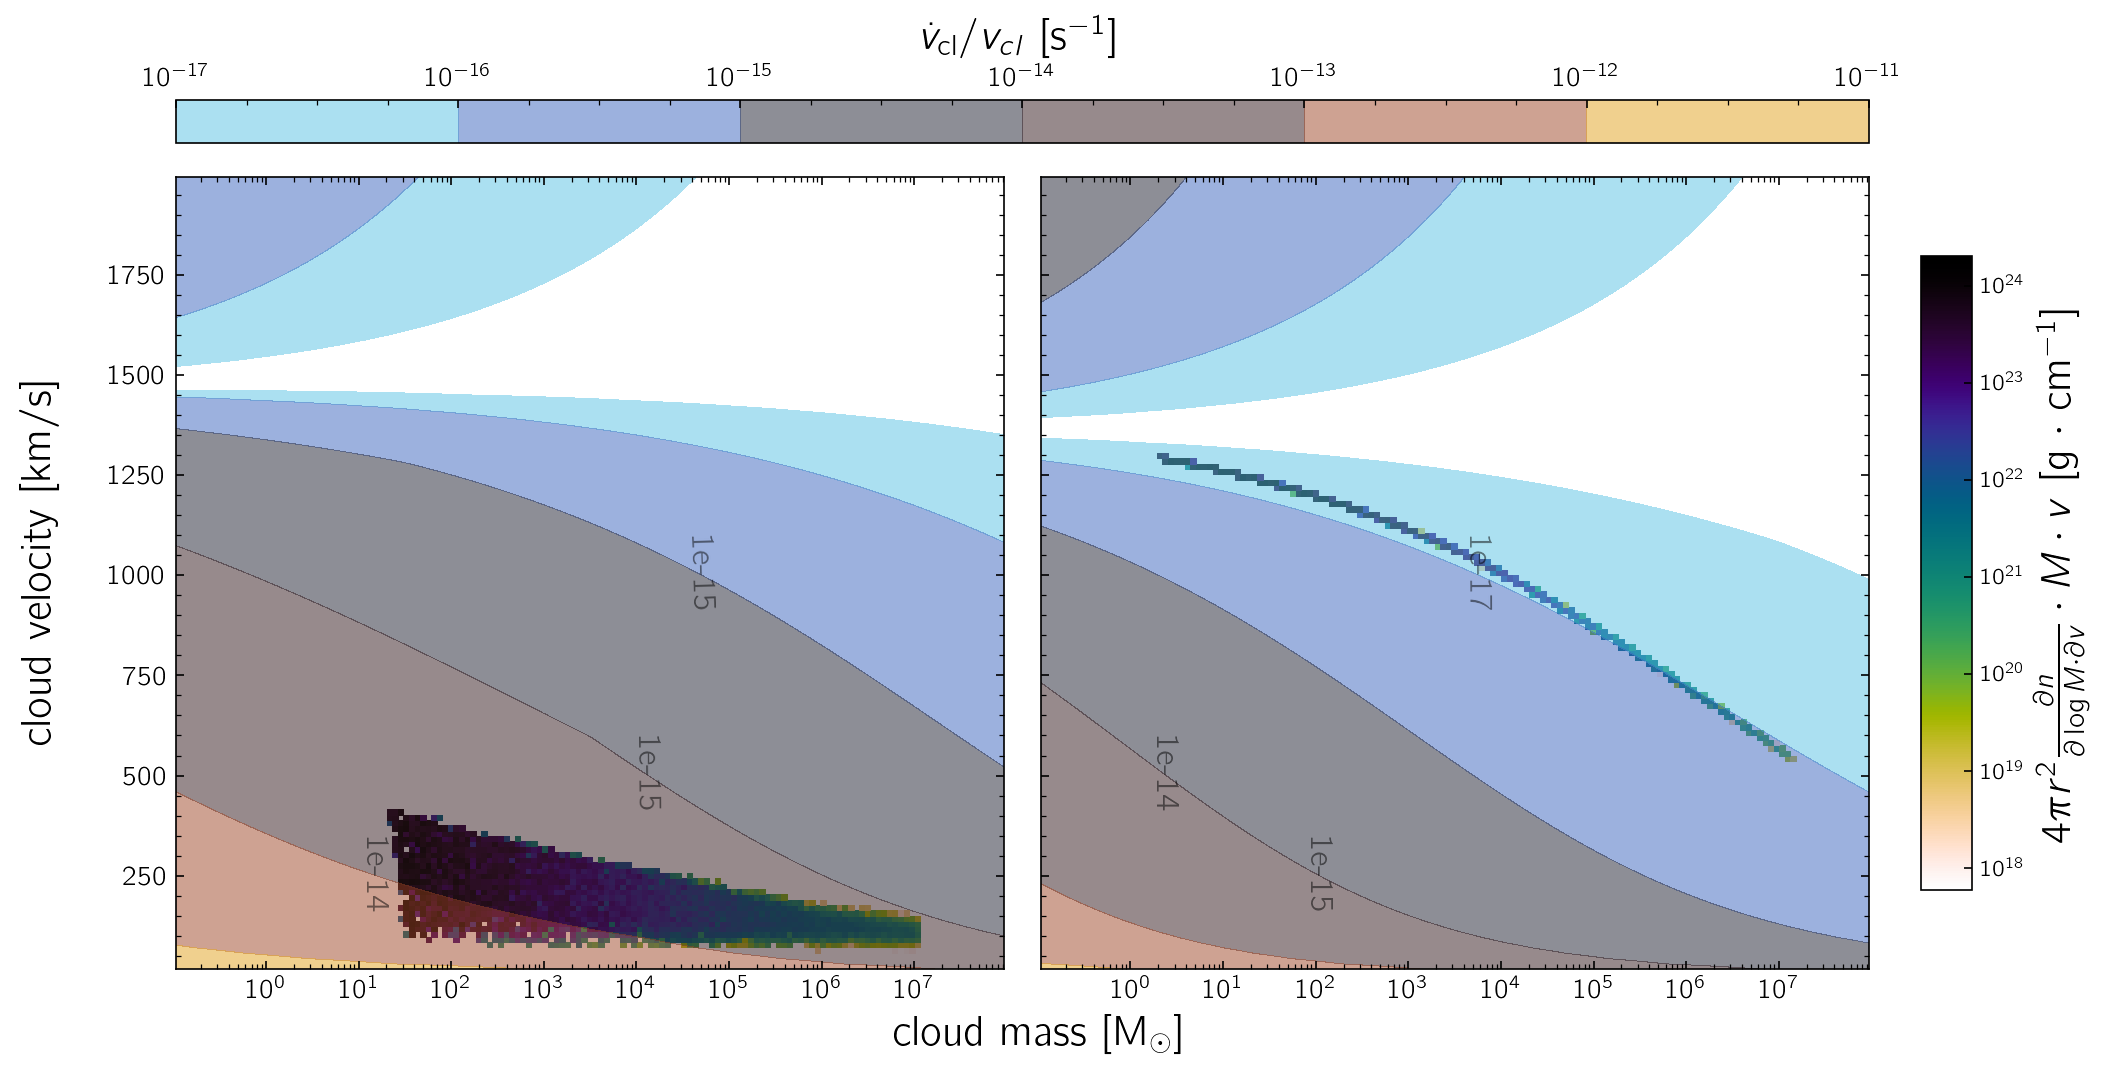

In [267]:
save=0

fig, axes = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(10,5))
ax1, plot1, contour1 = create_contour(r_curr=400, ax=axes[0], contour_scale=4, c_loc=500)
ax2, plot2, contour2 = create_contour(r_curr=30000, ax=axes[1], contour_scale=3.5, c_loc=300)
cb = fig.colorbar(plot2, ax=axes.ravel().tolist(), location="right", shrink=0.8)
label = r'$4\pi r^2 \frac{\partial n}{\partial \log M \cdot \partial v} \cdot M \cdot v$  [g $\cdot$ cm$^{-1}$]'
cb.set_label(label,size=15) ### PUT YOUR LABEL HERE
cb.ax.tick_params(labelsize='small')
cb.ax.minorticks_off()

cb = fig.colorbar(contour2, ax=axes.ravel().tolist(), location="top", shrink=1)
#cb.set_ticklabels([r"$\frac{1}{256}$",r"$\frac{1}{16}$",r"$1$",r"$16$",r"$256$",r"$2^{12}$"])
#cb.set_label(r'$\xi = \frac{r_{cl}}{v_{turb} \tau_{cool}}$', size =15)
cb.set_label(r'$\dot{v}_{\rm cl}/v_{cl}$ [s$^{-1}$]', size =15)

fig.text(0.47, -0.04, 'cloud mass [M$_\odot$]', ha='center', size=15)
fig.text(-0.04, 0.45, 'cloud velocity [km/s]', va='center', rotation='vertical', size=15)

if save == 1:
    plt.savefig('vel_contour', bbox_inches='tight')
    plt.clf()

In [33]:
def plot_wind(data, linestyle, labels, axes, const):
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.top'] = True
    matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams['xtick.minor.visible'] = True
    matplotlib.rcParams['ytick.minor.visible'] = True
    matplotlib.rcParams['lines.dash_capstyle'] = "round"
    matplotlib.rcParams['lines.solid_capstyle'] = "round"
    matplotlib.rcParams['legend.handletextpad'] = 0.4
    matplotlib.rcParams['axes.linewidth'] = 0.6
    matplotlib.rcParams['ytick.major.width'] = 0.6
    matplotlib.rcParams['xtick.major.width'] = 0.6
    matplotlib.rcParams['ytick.minor.width'] = 0.45
    matplotlib.rcParams['xtick.minor.width'] = 0.45
    matplotlib.rcParams['ytick.major.size'] = 2.75
    matplotlib.rcParams['xtick.major.size'] = 2.75
    matplotlib.rcParams['ytick.minor.size'] = 1.75
    matplotlib.rcParams['xtick.minor.size'] = 1.75
    matplotlib.rcParams['legend.handlelength'] = 2
    matplotlib.rcParams["figure.dpi"] = 200


    def v_plot(res,sty,lab, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _v = [item[1] for item in res.pre_wind_info]
        v_ = [item[1] for item in res.post_wind_info]
        v = np.r_[_v,v_]
        ax.loglog(r,v/const.km, linestyle=sty, label=lab)
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$v \; [{\rm km/s}]$')
        ax.set_title('Velocity')
        return ax

    def rho_plot(res,sty,lab, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _rho = [item[2] for item in res.pre_wind_info]
        rho_ = [item[2] for item in res.post_wind_info]
        rho = np.r_[_rho,rho_]
        ax.loglog(r,rho/(const.mu*const.mp), linestyle=sty, label=lab)
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$n \; [{\rm cm}^{-3}]$')
        ax.set_title('Density')
        return ax

    def P_plot(res,sty,lab, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _P = [item[3] for item in res.pre_wind_info]
        P_ = [item[3] for item in res.post_wind_info]
        P = np.r_[_P,P_]
        ax.loglog(r,P/const.kb,linestyle=sty,label=lab)
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$P \; [{\rm K cm}^{-3}]$')
        ax.set_title('Pressure')
        return ax

    def rhoZ_plot(res,sty,lab, ax):
        if ax is None:
            ax = plt.gca()
        _r = [item[0] for item in res.pre_wind_info]
        r_ = [item[0] for item in res.post_wind_info]
        r = np.r_[_r,r_]/const.kpc
        _rhoZ = [item[4] for item in res.pre_wind_info]
        rhoZ_ = [item[4] for item in res.post_wind_info]
        rhoZ = np.r_[_rhoZ,rhoZ_]
        _rho = [item[2] for item in res.pre_wind_info]
        rho_ = [item[2] for item in res.post_wind_info]
        rho = np.r_[_rho,rho_]
        ax.loglog(r,rhoZ / rho / const.ZSun,linestyle=sty, label=lab)
        ax.set_xlabel(r'$r\; [{\rm kpc}]$')
        ax.set_ylabel(r'$Z \; [Z_\odot]$')
        ax.set_title('Metallicity')
        return ax

    for (idx, item) in enumerate(data):
        ax1 = v_plot(item, linestyle[idx],labels[idx], axes[0])
        ax2 = rho_plot(item,linestyle[idx],labels[idx], axes[1])
        ax3 = P_plot(item,linestyle[idx], labels[idx],axes[2])
        ax4 = rhoZ_plot(item,linestyle[idx],labels[idx], axes[3])
    return ax1, ax2, ax3, ax4
        

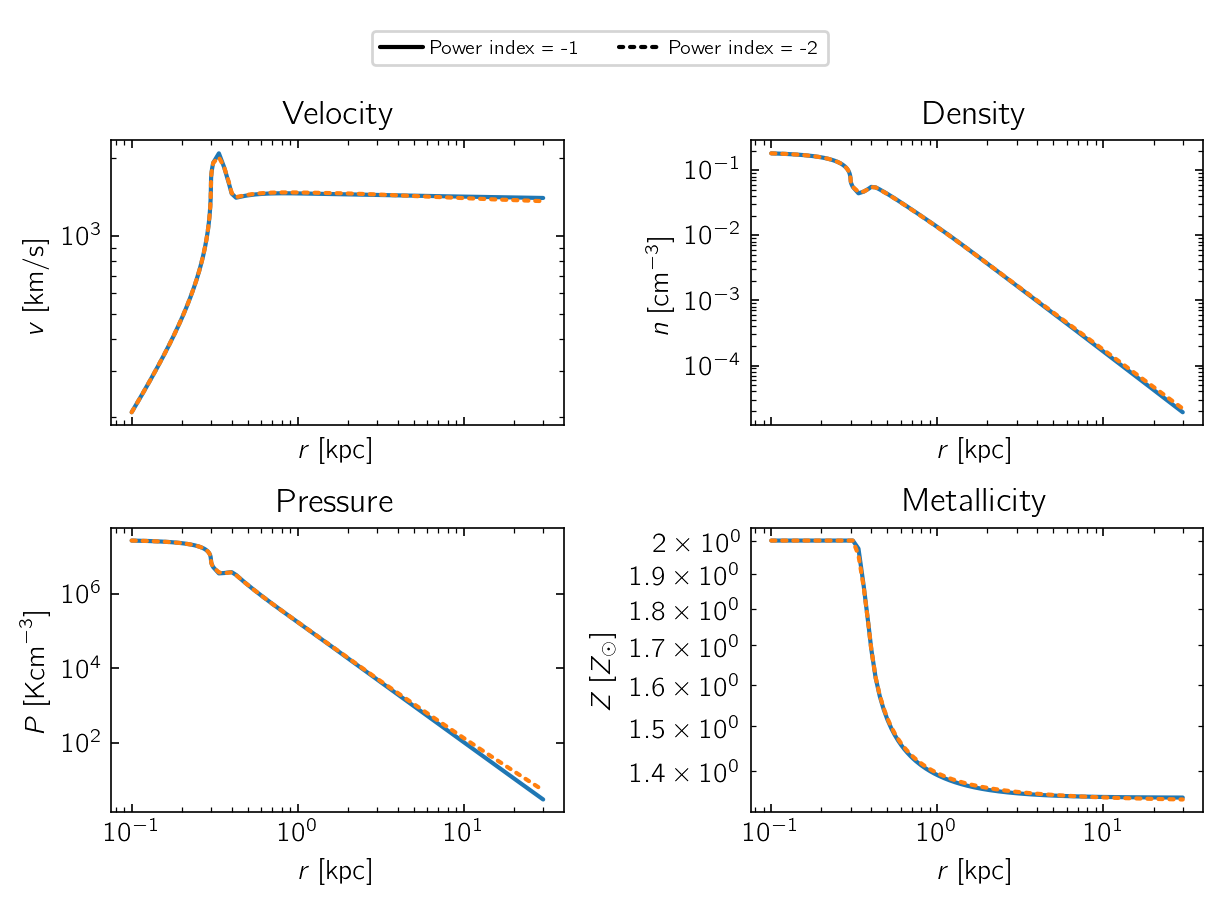

In [52]:
save = 0

data = [res, res_slope2]
lines = ['solid', 'dotted']
labels = [r'Power index = -1',r'Power index = -2' ]
#fig,axes = plt.subplots(2,2,sharex=True,constrained_layout=True)
#ax_arr = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
fig,axes = plt.subplots(2,2,sharex=True,constrained_layout=True)
ax_arr = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ax1, ax2, ax3, ax4 = plot_wind(data, lines, labels, ax_arr, const)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', ls = 'solid'),
                Line2D([0], [0], color='k', ls = 'dotted')]

fig.legend(custom_lines, labels ,fontsize=7, 
           frameon=True, handlelength=2.2, labelspacing=0.5, 
           bbox_to_anchor=(0.5, 1.07), loc='center', ncol=3,
           fancybox=True, shadow=False)


if save == 1:
    plt.savefig('wind_power_slope', bbox_inches='tight')
    plt.clf()

In [153]:
linestyle_tuple = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [110]:
[item[1] for item in linestyle_tuple if item[0]=='dashdotted']

[(0, (3, 5, 1, 5))]

In [115]:
a=[5,4,3,2,1]
[idx for (idx, value) in enumerate(a)]

[0, 1, 2, 3, 4]

In [139]:
labels

['$\x07lpha = 1$',
 '$\x07lpha = 2$',
 '$\x07lpha = 1$',
 '$\x07lpha = 2$',
 '$\x07lpha = 1$',
 '$\x07lpha = 2$',
 '$\x07lpha = 1$',
 '$\x07lpha = 2$']

In [13]:
def plot_distributions(res, rlist, line1, line2, line3, show_fit, save):
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.top'] = True
    matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams['xtick.minor.visible'] = True
    matplotlib.rcParams['ytick.minor.visible'] = True
    matplotlib.rcParams['lines.dash_capstyle'] = "round"
    matplotlib.rcParams['lines.solid_capstyle'] = "round"
    matplotlib.rcParams['legend.handletextpad'] = 0.4
    matplotlib.rcParams['axes.linewidth'] = 0.6
    matplotlib.rcParams['ytick.major.width'] = 0.6
    matplotlib.rcParams['xtick.major.width'] = 0.6
    matplotlib.rcParams['ytick.minor.width'] = 0.45
    matplotlib.rcParams['xtick.minor.width'] = 0.45
    matplotlib.rcParams['ytick.major.size'] = 2.75
    matplotlib.rcParams['xtick.major.size'] = 2.75
    matplotlib.rcParams['ytick.minor.size'] = 1.75
    matplotlib.rcParams['xtick.minor.size'] = 1.75
    matplotlib.rcParams['legend.handlelength'] = 2
    matplotlib.rcParams["figure.dpi"] = 200


    cloud_info = res.clouds_info_MC

    fig,axes = plt.subplots(1,2,constrained_layout=True, figsize=(10,5))


    r = np.array([item['r']+0 for item in cloud_info])
    i1 = min(np.where(r>=(rlist[0]*pc))[0])
    i2 = min(np.where(r>=(rlist[1]*pc))[0])

    f1, Mbins1, vbins1 = Utils.binnings_MC(i1, res, pm)
    dlogM = (pm['M_MAX']-pm['M_MIN'])/pm['M_CELLS']
    mass1 = sum(f1)/dlogM
    legend1 = 'Mass distribution at ' + str(int(cloud_info[i1]['r'] / const.pc)) + ' pc'
    axes[0].loglog(Mbins1/const.Msun, mass1, label = legend1)
    f2, Mbins2, vbins2 = Utils.binnings_MC(steps, res, mp)
    mass2 = sum(f2)/dlogM
    legend2 = 'Mass distribution at ' + str(int(cloud_info[i2]['r'] / const.pc)) + ' pc'
    axes[0].loglog(Mbins2/const.Msun, mass2, label = legend2)


#        mstart = min(np.where(Mbins >= (10**v_mrng[0] * const.Msun))[0])
#        mend = min(np.where(Mbins >= (10**v_mrng[1] * const.Msun))[0])

#        f3 = f1[:,[mstart, mend]]
    f3 = f1
    vel1 = sum(f3.T)
    legend6 = 'velocity distribution at ' + str(int(res.clouds_info_MC[i1]['r'] / const.pc)) + ' pc'
    axes[1].plot(vbins1/const.km, vel1/max(vel1), label = legend6)
#        f4 = f2[:,[mstart, mend]]
    f4 = f2
    vel2 = sum(f4.T)
    legend7 = 'velocity distribution at ' + str(int(res.clouds_info_MC[i2]['r'] / const.pc)) + ' pc'
    axes[1].plot(vbins2/const.km, vel2/max(vel2), label = legend7)

    def getFit(line, Mbins, mass):
        istart = min(np.where(Mbins >= (10**line[0] * const.Msun))[0])
        iend = min(np.where(Mbins >= (10**line[1] * const.Msun))[0])
        x=np.log10(Mbins[istart:iend]).reshape((-1,1))
        y=np.log10(mass[istart:iend])
        model = LinearRegression()
        model.fit(x, y)
        b = model.intercept_ + line[2]
        slope = model.coef_[0]
        line_x =  Mbins[istart:iend]
        line_y = [10**(slope * np.log10(x) + b) for x in line_x]
        return line_x, line_y, slope

    if show_fit == True:
        x1, y1, slope1 = getFit(line1, Mbins1, mass1)
        legend3 = 'Power law index = {:2.2f}'.format(slope1)
        axes[0].loglog(x1/const.Msun, y1, label = legend3)
        x2, y2, slope2 = getFit(line2, Mbins2, mass2)
        legend4 = 'Power law index = {:2.2f}'.format(slope2)
        axes[0].loglog(x2/const.Msun, y2, label = legend4)
        x3, y3, slope3 = getFit(line3, Mbins2, mass2)
        legend5 = 'Power law index = {:2.2f}'.format(slope3)
        axes[0].loglog(x3/const.Msun, y3, label = legend5)


    #axes[0].title('Marginal Distribution of Cloud Mass')
    axes[0].set_xlabel('Mass $[M_\odot]$')
    axes[0].set_ylabel(r'$\frac{\partial n}{\partial \log M}$   [cm$^{-3}$]')
    axes[0].legend(fontsize='small')
    axes[1].set_xlabel('Velocity [km/s]')
    axes[1].set_ylabel('Normalized Relative frequency')
    axes[1].legend(fontsize='small')
    #axes[0].set_ylim((10**(-75), 10**(-54)))
    axes[1].set_ylim((0,1.2))
    axes[1].set_yticks([0,0.5,1])

    if save == 1:
        plt.savefig('cloud_distributions', bbox_inches='tight')
        plt.clf()
    return    

30000.0

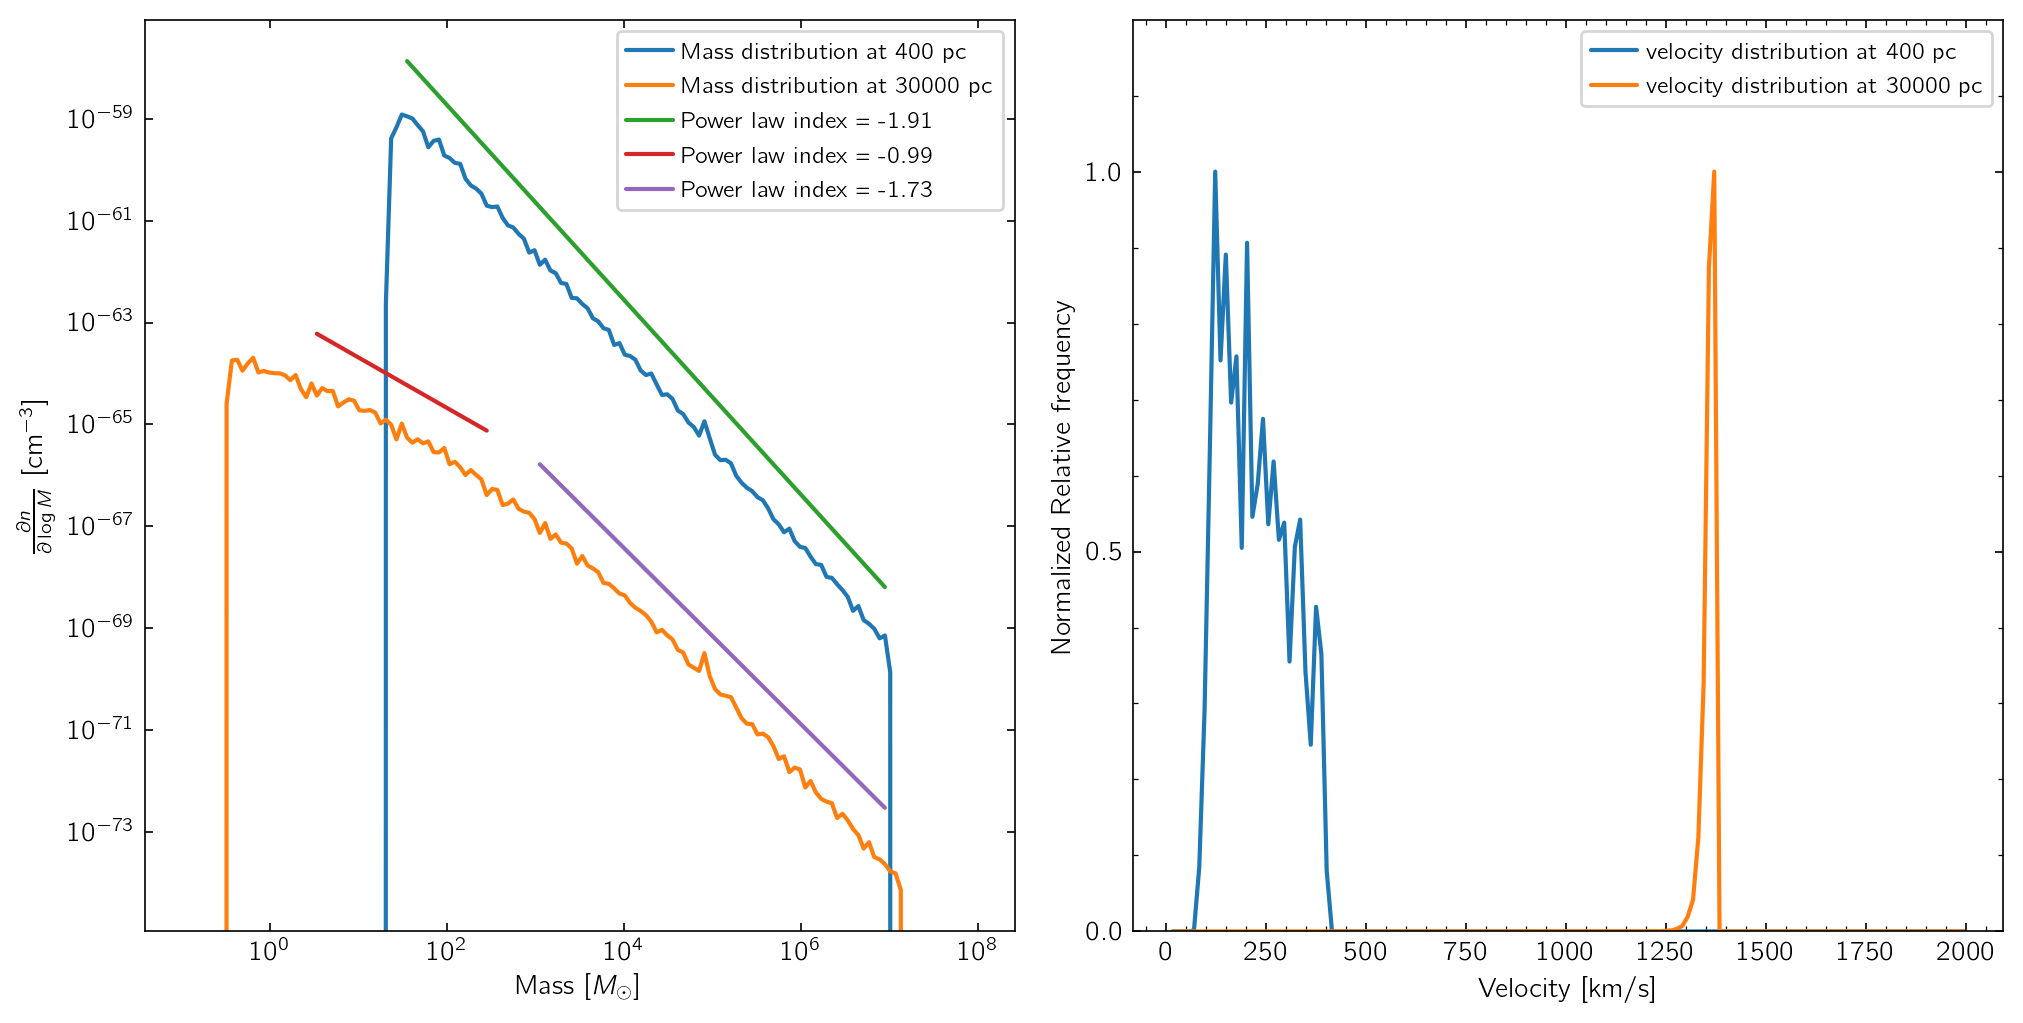

In [14]:
steps= len(res.clouds_info_MC)-1
plot_distributions(res, rlist=[400,30000], line1=[1.5,7,1], line2=[0.5,2.5,1], line3=[3,7,1], show_fit=True, save=0)
res.clouds_info_MC[-1]['r']/pc

In [259]:
def plot_cloud_evo(res, rlist, cnormal, cmap, save):
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.top'] = True
    matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams['xtick.minor.visible'] = True
    matplotlib.rcParams['ytick.minor.visible'] = True
    matplotlib.rcParams['lines.dash_capstyle'] = "round"
    matplotlib.rcParams['lines.solid_capstyle'] = "round"
    matplotlib.rcParams['legend.handletextpad'] = 0.4
    matplotlib.rcParams['axes.linewidth'] = 0.6
    matplotlib.rcParams['ytick.major.width'] = 0.6
    matplotlib.rcParams['xtick.major.width'] = 0.6
    matplotlib.rcParams['ytick.minor.width'] = 0.45
    matplotlib.rcParams['xtick.minor.width'] = 0.45
    matplotlib.rcParams['ytick.major.size'] = 2.75
    matplotlib.rcParams['xtick.major.size'] = 2.75
    matplotlib.rcParams['ytick.minor.size'] = 1.75
    matplotlib.rcParams['xtick.minor.size'] = 1.75
    matplotlib.rcParams['legend.handlelength'] = 2
    matplotlib.rcParams["figure.dpi"] = 200
    if cnormal == 1:
        colormap_n = colors.Normalize()
    else:
        colormap_n = colors.LogNorm()
    if cmap == 1:
        colormap_r = ListedColormap(cmr.rainforest.colors[::-1])
    else:
        colormap_r = palettable.scientific.sequential.Oslo_20_r.mpl_colormap

    cloud_info = res.clouds_info_MC
    r = np.array([item['r']+0 for item in cloud_info])
    i1 = min(np.where(r>=(rlist[0]*pc))[0])
    i2 = min(np.where(r>=(rlist[1]*pc))[0])
    i3 = min(np.where(r>=(rlist[2]*pc))[0])
    i4 = min(np.where(r>=(rlist[3]*pc))[0])
    i5 = min(np.where(r>=(rlist[4]*pc))[0])
    i6 = min(np.where(r>=(rlist[5]*pc))[0])
#    fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,sharex=True, sharey=True,constrained_layout=True)
    fig,axes = plt.subplots(2,3,sharex=True, sharey=True,constrained_layout=True)

    def getMassFlux(i):
        f,Mbins,vbins = Utils.binnings_MC(i, res, pm)
        dlogM = (pm['M_MAX']-pm['M_MIN'])/pm['M_CELLS']
        dv = (pm['V_MAX']-pm['V_MIN'])/pm['V_CELLS']
        mass = 4 * np.pi * cloud_info[i]['r']**2 * f * Mbins
        massFlux = (mass.T * vbins).T
        return massFlux / (dlogM * dv), Mbins, vbins

    massFlux1, Mbins, vbins = getMassFlux(i1)
    axes[0][0].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux1, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux2, Mbins, vbins = getMassFlux(i2)
    axes[0][1].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux2, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux3, Mbins, vbins = getMassFlux(i3)
    axes[0][2].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux3, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux4, Mbins, vbins = getMassFlux(i4)
    axes[1][0].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux4, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux5, Mbins, vbins = getMassFlux(i5)
    axes[1][1].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux5, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    massFlux6, Mbins, vbins = getMassFlux(i6)
    im=axes[1][2].pcolormesh(Mbins/const.Msun, vbins/const.km, massFlux6, 
        norm=colormap_n, #color limits
        cmap=colormap_r) #color map
    plt.xscale('log')
    fig.text(0.45, -0.04, 'cloud mass [M$_\odot$]', ha='center')
    fig.text(-0.04, 0.5, 'cloud velocity [km/s]', va='center', rotation='vertical')
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), location="right", shrink=0.7)
    label = r'$4\pi r^2 \frac{\partial^2 n}{\partial \log M \cdot \partial v} \cdot M \cdot v$  [g $\cdot$ cm$^{-1}$]'
    cb.set_label(label,size='small') ### PUT YOUR LABEL HERE
    cb.ax.tick_params(labelsize='small')
    cb.ax.minorticks_off()
    plt.setp(axes, xticks=[1, 1e3, 1e6])
    axes[0][0].annotate('r=' + str(rlist[0]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[0][1].annotate('r=' + str(rlist[1]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[0][2].annotate('r=' + str(rlist[2]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[1][0].annotate('r=' + str(rlist[3]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[1][1].annotate('r=' + str(rlist[4]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    axes[1][2].annotate('r=' + str(rlist[5]/1000)+' kpc', xy=(0.3, 0.9), xycoords="axes fraction")
    if save == 1:
        plt.savefig('Cloud_evolution', bbox_inches='tight')
        plt.clf()
    return


In [51]:
rlist = [400, 600, 900, 2000, 6000, 30000]
cnormal = 1
cmap = 0
save = 0
plot_cloud_evo(res, rlist, cnormal, cmap, save)

NameError: name 'plot_cloud_evo' is not defined

In [40]:
dump_wind = 0
dump_source = 0
dump_Mdot = 0 
dump_cloud = 0
dump_cloud_retire = 0



const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
MC=1

res = Result(const, pm)
transfer = Transfer(const, pm)
wind = Wind(control, const, pm, res, transfer)
if (MC == 1):
    cloud = CloudMC(control, const, pm, res, transfer)
else:
    cloud = Cloud(control, const, pm, res, transfer)    



#steps= len(control.r_schedule)-1
steps = 0
r_max = 30000* pc
stop = 200000
#beta=[(300,3), (700, 10)]
beta=[(300,1)]

In [41]:
cloud.live

{'id': array([0.]),
 'M': array([7.65599329e+38]),
 'v': array([8212954.83666445]),
 'n': array([3.50798159e-67]),
 'Z': array([0.02])}

In [42]:
wind0 = copy.deepcopy(wind.state)
cloud0 = copy.deepcopy(cloud.live)
def RK4_step(cloud, wind, cloud0, wind0, RK4):
    k_M, k_v, k_Z = cloud.step(transfer, RK4)
    r_curr, r_next, dr = control.get_cloud_r_info()
    if RK4 == 1 or RK4 == 2:
        k_M_next = k_M / 2
        k_v_next = k_v / 2
        k_Z_next = k_Z / 2
    else:
        k_M_next = k_M
        k_v_next = k_v
        k_Z_next = k_Z
    cloud.live['M'] = cloud0['M'] + k_M_next
    cloud.live['v'] = cloud0['v'] + k_v_next
    cloud.live['n'] = cloud0['n'] * (r_curr / r_next) **2 * cloud0['v'] / cloud.live['v']
    cloud.live['Z'] = cloud0['Z'] + k_Z_next
    k_u, k_rho, k_P, k_rhoZ = wind.step(transfer)
    if RK4 == 1 or RK4==2:
        k_u_next = k_u / 2
        k_rho_next = k_rho / 2
        k_P_next = k_P / 2
        k_rhoZ_next = k_rhoZ / 2
    else:
        k_u_next = k_u
        k_rho_next = k_rho
        k_P_next = k_P
        k_rhoZ_next = k_rhoZ
        
    u_next = wind0['v'] + k_u_next
    rho_next = wind0['rho'] + k_rho_next
    P_next = wind0['P'] + k_P_next
    rhoZ_next = wind0['rhoZ'] + k_rhoZ_next
    wind.update_state(u_next, rho_next, P_next, rhoZ_next)
    return k_M, k_v, k_Z, k_u, k_rho, k_P, k_rhoZ

In [43]:
k1 = RK4_step(cloud, wind, cloud0, wind0, 1)
k2 = RK4_step(cloud, wind, cloud0, wind0, 2)
k3 = RK4_step(cloud, wind, cloud0, wind0, 3)
k4 = RK4_step(cloud, wind, cloud0, wind0, 4)
r_curr, r_next, dr = control.get_cloud_r_info()
cloud.live['M'] = cloud0['M'] + k1[0]/6 + k2[0]/3 + k3[0]/3 + k4[0]/6
cloud.live['v'] = cloud0['v'] + k1[1]/6 + k2[1]/3 + k3[1]/3 + k4[1]/6
cloud.live['n'] = cloud0['n'] * (r_curr / r_next) **2 * cloud0['v'] / cloud.live['v']
cloud.live['Z'] = cloud0['Z'] + k1[2]/6 + k2[2]/3 + k3[2]/3 + k4[2]/6
u = wind0['v'] + k1[3]/6 + k2[3]/3 + k3[3]/3 + k4[3]/6
rho = wind0['rho'] + k1[4]/6 + k2[4]/3 + k3[4]/3 + k4[4]/6
P = wind0['P'] + k1[5]/6 + k2[5]/3 + k3[5]/3 + k4[5]/6
rhoZ = wind0['rhoZ'] + k1[6]/6 + k2[6]/3 + k3[6]/3 + k4[6]/6
wind.update_state(u, rho, P, rhoZ)

In [44]:
if control.inject_mode == 1 and r_curr>=control.inject_start and r_next <= control.inject_end \
   and (r_curr-cloud.last_inject_r) > 1 * const.pc:
    id_dist, M_dist, v_dist, n_dist, z_dist = cloud.gen_cloud_power_M_normal_v(cloud.nbs_cloud, r_curr, r_next, cloud.rho_source_target)
    cloud_live['id']= np.r_[cloud_live['id'], id_dist]
    cloud_live['M'] = np.r_[cloud_live['M'],M_dist]
    cloud_live['v'] = np.r_[cloud_live['v'],v_dist]
    cloud_live['n'] = np.r_[cloud_live['n'],n_dist]
    cloud_live['Z'] = np.r_[cloud_live['Z'],z_dist]
    cloud.last_inject_r = r_curr  

In [11]:
class RK4:
    def __init__(self, cloud, wind, transfer, control, res):
        self.wind_state = copy.deepcopy(wind.state)
        self.cloud_state = copy.deepcopy(cloud.live)
        return
    
    def get_k(self, RK4):
        k_M, k_v, k_Z = cloud.step(transfer, RK4)
        r_curr, r_next, dr = control.get_cloud_r_info()
        if RK4 == 1 or RK4 == 2:
            k_M_next = k_M / 2
            k_v_next = k_v / 2
            k_Z_next = k_Z / 2
        else:
            k_M_next = k_M
            k_v_next = k_v
            k_Z_next = k_Z
        cloud.live['M'] = self.cloud_state['M'] + k_M_next
        cloud.live['v'] = self.cloud_state['v'] + k_v_next
        cloud.live['n'] = self.cloud_state['n'] * (r_curr / r_next) **2 * self.cloud_state['v'] / cloud.live['v']
        cloud.live['Z'] = self.cloud_state['Z'] + k_Z_next
        k_u, k_rho, k_P, k_rhoZ = wind.step(transfer)
        if RK4 == 1 or RK4==2:
            k_u_next = k_u / 2
            k_rho_next = k_rho / 2
            k_P_next = k_P / 2
            k_rhoZ_next = k_rhoZ / 2
        else:
            k_u_next = k_u
            k_rho_next = k_rho
            k_P_next = k_P
            k_rhoZ_next = k_rhoZ
        u_next = self.wind_state['v'] + k_u_next
        rho_next = self.wind_state['rho'] + k_rho_next
        P_next = self.wind_state['P'] + k_P_next
        rhoZ_next = self.wind_state['rhoZ'] + k_rhoZ_next
        wind.update_state(u_next, rho_next, P_next, rhoZ_next)
        return k_M, k_v, k_Z, k_u, k_rho, k_P, k_rhoZ
    
    def step(self):
        k1 = self.get_k(1)
        k2 = self.get_k(2)
        k3 = self.get_k(3)
        k4 = self.get_k(4)
        r_curr, r_next, dr = control.get_cloud_r_info()
        cloud.live['M'] = self.cloud_state['M'] + k1[0]/6 + k2[0]/3 + k3[0]/3 + k4[0]/6
        cloud.live['v'] = self.cloud_state['v'] + k1[1]/6 + k2[1]/3 + k3[1]/3 + k4[1]/6
        cloud.live['n'] = self.cloud_state['n'] * (r_curr / r_next) **2 * self.cloud_state['v'] / cloud.live['v']
        cloud.live['Z'] = self.cloud_state['Z'] + k1[2]/6 + k2[2]/3 + k3[2]/3 + k4[2]/6
        u = self.wind_state['v'] + k1[3]/6 + k2[3]/3 + k3[3]/3 + k4[3]/6
        rho = self.wind_state['rho'] + k1[4]/6 + k2[4]/3 + k3[4]/3 + k4[4]/6
        P = self.wind_state['P'] + k1[5]/6 + k2[5]/3 + k3[5]/3 + k4[5]/6
        rhoZ = self.wind_state['rhoZ'] + k1[6]/6 + k2[6]/3 + k3[6]/3 + k4[6]/6
        wind.update_state(u, rho, P, rhoZ)
        if control.inject_mode == 1 and r_curr>=control.inject_start and r_next <= control.inject_end \
           and (r_curr-cloud.last_inject_r) > 1 * const.pc:
            id_dist, M_dist, v_dist, n_dist, z_dist = cloud.gen_cloud_power_M_normal_v(cloud.nbs_cloud, r_curr, r_next, cloud.rho_source_target)
            cloud.live['id']= np.r_[cloud.live['id'], id_dist]
            cloud.live['M'] = np.r_[cloud.live['M'],M_dist]
            cloud.live['v'] = np.r_[cloud.live['v'],v_dist]
            cloud.live['n'] = np.r_[cloud.live['n'],n_dist]
            cloud.live['Z'] = np.r_[cloud.live['Z'],z_dist]
            cloud.last_inject_r = r_curr 

        cloud.update_state(cloud.live, pm)
            
        if ((r_next - res.last_cloud_r_save) >= res.save_interval) or (r_next == control.inject_end) or (r_next == r_max):
            res.add_clouds_info_MC(r_next,cloud.live)
#            res.add_ksi(r_curr, info['ksi'])
            res.last_cloud_r_save = r_next
        control.r_cloud = r_next
        
        if (r_next - res.last_wind_r_save) >= res.save_interval or (r_next == control.inject_end) or (r_next == r_max):
            res.add_post_wind_info((r_next, u, rho, P, rhoZ))
            res.last_wind_r_save = r_next
        control.r_wind = r_next

In [23]:
dump_wind = 0
dump_source = 0
dump_Mdot = 0 
dump_cloud = 0
dump_cloud_retire = 0



const = Const()
pm = Param("Inputs", const).paramDict
control = EvolveControl(const, pm)
MC=1

res = Result(const, pm)
transfer = Transfer(const, pm)
wind = Wind(control, const, pm, res, transfer)
if (MC == 1):
    cloud = CloudMC(control, const, pm, res, transfer)
else:
    cloud = Cloud(control, const, pm, res, transfer)    



#steps= len(control.r_schedule)-1
steps = 0
r_max = 30000* pc
stop = 200000
#beta=[(300,3), (700, 10)]
beta=[(300,20)]
t0=time.time()
while control.terminate == False:    
    rk4 = RK4(cloud, wind, transfer, control, res)
    rk4.step()
    if (steps % 100) == 0:
        print(control.r_cloud / const.pc)
#        print(steps)
#        print(control.delta_r/const.pc)
#        print(control.nbs_inject_clouds)
#    if steps == stop: control.terminate = True
    steps += 1
t1=time.time()
print(t1-t0)

312.32311074788845
324.558071359408
335.0527939957151
345.1209383325837
355.3219777095912
366.33235760199034
377.8601342014805
390.9380622163959
406.9835188047744
454.87198783671806
543.141612588681
683.5333344395341
886.9167006237142
1183.035746690865
1728.7115143770807
2679.706178720553
3679.7061787205366
4679.706178720507
5679.706178720477
6679.706178720448
7679.706178720418
8679.70617872039
9679.706178720358
10679.70617872033
11679.7061787203
12679.70617872027
13679.70617872024
14679.706178720211
15679.70617872018
16679.70617872015
17679.70617872012
18679.70617872009
19679.706178720062
20679.706178720033
21679.706178720004
22679.70617871997
23679.70617871994
24679.706178719964
25679.706178720207
26679.706178720447
27679.70617872069
28679.70617872093
29679.706178721175
343.04217171669006


In [36]:
rk4 = RK4(cloud, wind, transfer, control, res)

In [29]:
rk4.step()
res.clouds_info_MC, res.post_wind_info

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in less_equal
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in less
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in less
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in greater
/Library/Frameworks/Python.framework/Versions/3.7/li

IndexError: list index out of range

In [43]:
rk4.step()
res.clouds_info_MC, res.post_wind_info

([{'id': array([0.]),
   'M': array([1.34807834e+37]),
   'v': array([9968148.06198255]),
   'n': array([1.64145384e-65]),
   'Z': array([0.02]),
   'r': 9.5666e+20}],
 [(9.5666e+20,
   192284305.62992495,
   5.735673890547133e-26,
   7.228278750889031e-10,
   2.2942695562188554e-27)])

In [17]:
wind.state

{'v': 192313863.6998733,
 'rho': 5.734117972300509e-26,
 'P': 7.225010852445369e-10,
 'rhoZ': 2.293647154978858e-27}

In [ ]:
class RK4:
    def __init__(self, cloud, wind):
        